In [1]:
import numpy as np
import tensorflow as tf
from keras import layers
import keras
from keras import Input
from keras.models import load_model
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import randint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate
import os
import SimpleITK as sitk
import h5py
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import cv2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import generator

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [2]:
from os import listdir
from os.path import isfile, join
mypath1 = '/data2/ysdata/3D_Unet/Dataset/CT/'
files1 = [f for f in listdir(mypath1) if f.endswith('.hdr')]

##Read Input Image
CNN_data=[]
for fname1 in sorted(files1):
    try:
        itk_image = sitk.ReadImage(mypath1+fname1)
        image = sitk.GetArrayFromImage(itk_image)
        CNN_data.append(image)
    except RuntimeError:
        pass

print('CNN Image Shape : {}'.format(np.shape(CNN_data)))

CNN Image Shape : (125, 64, 64, 64)


In [3]:
mypath2 = '/data2/ysdata/3D_Unet/Dataset/Mask/'
files2 = [f for f in listdir(mypath2) if f.endswith('.hdr')]

##Read Input Mask
Mask_data=[]
for fname2 in sorted(files2):
    try:
        itk_image = sitk.ReadImage(mypath2+fname2)
        image = sitk.GetArrayFromImage(itk_image)
        Mask_data.append(image)
    except RuntimeError:
        pass

print('Mask Shape : {}'.format(np.shape(Mask_data)))

Mask Shape : (125, 64, 64, 64)


In [4]:
X = np.clip(CNN_data, -200., 200.).astype(np.float32)
y = np.array(Mask_data)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)

X_shape :  (125, 64, 64, 64)
y_shape :  (125, 64, 64, 64)


In [5]:
print("The number of train data : ", X.shape[0])

The number of train data :  125


In [6]:
X=X.reshape(-1, 64,64,64, 1)
y=y.reshape(-1, 64,64,64, 1)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)

X_shape :  (125, 64, 64, 64, 1)
y_shape :  (125, 64, 64, 64, 1)


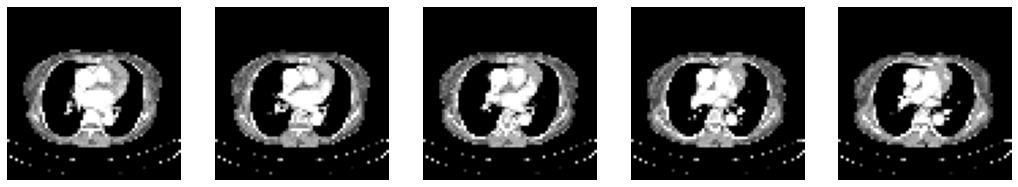

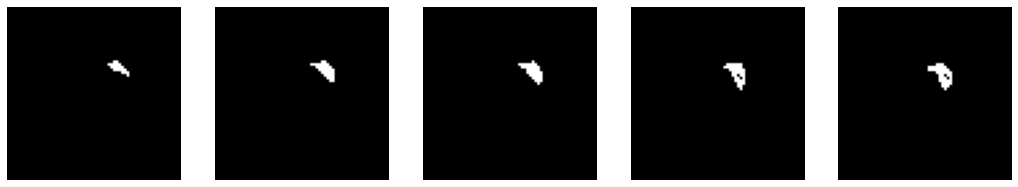

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (18,18))

slice_indices =[34,35,36,37,38]
for ind in range(5):
    X_test_slice = X[:,slice_indices[ind],:,:,:]
    axes[ind].imshow(X_test_slice[2], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (18,18))

slice_indices =[34,35,36,37,38]
for ind in range(5):
    y_test_slice = y[:,slice_indices[ind],:,:,:]
    axes[ind].imshow(y_test_slice[2], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

In [8]:
#The functions return our metric and loss
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -1.0 * dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [9]:
from keras import regularizers
from keras.regularizers import l2

def unet():
#     model = keras.Sequential([
        dropout_rate = 0.2
    
        inputs = Input((64,64,64,1))
        conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(inputs)
        conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Dropout(dropout_rate)(conv1)
        conv1 = concatenate([inputs, conv1], axis=4)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(pool1)
        conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv2)
        conv2 = BatchNormalization()(conv2)
        conv2 = Dropout(dropout_rate)(conv2)
        conc2 = concatenate([pool1, conv2], axis=4)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(pool2)
        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv3)
        conv3 = BatchNormalization()(conv3)
        conv3 = Dropout(dropout_rate)(conv3)
        conc3 = concatenate([pool2, conv3], axis=4)
        pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

        conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(pool3)
        conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Dropout(dropout_rate)(conv4)
        conc4 = concatenate([pool3, conv4], axis=4)
        pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

        conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(pool4)
        conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Dropout(dropout_rate)(conv5)
        conc5 = concatenate([pool4, conv5], axis=4)
        
        up6 = concatenate([UpSampling3D(size=(2, 2, 2))(conv5), conv4], axis=4)
        conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(up6)
        conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Dropout(dropout_rate)(conv6)
        conc6 = concatenate([up6, conv6], axis=4)

        up7 = concatenate([UpSampling3D(size=(2, 2, 2))(conv6), conv3], axis=4)
        conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(up7)
        conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Dropout(dropout_rate)(conv7)
        conc7 = concatenate([up7, conv7], axis=4)

        up8 = concatenate([UpSampling3D(size=(2, 2, 2))(conv7), conv2], axis=4)
        conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(up8)
        conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Dropout(dropout_rate)(conv8)
        conc8 = concatenate([up8, conv8], axis=4)

        up9 = concatenate([UpSampling3D(size=(2, 2, 2))(conv8), conv1], axis=4)
        conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(up9)
        conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same' ,kernel_regularizer=l2(1e-4))(conv9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Dropout(dropout_rate)(conv9)
        conc9 = concatenate([up9, conv9], axis=4)
    

        conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

        model = Model(inputs, conv10)


        return model

In [10]:
from keras.losses import binary_crossentropy

model = unet()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000245), loss= dice_coef_loss, 
              metrics=['accuracy', dice_coef, iou_coef])
model.summary()

2022-06-25 16:01:15.018628: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 16:01:15.706585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9647 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   27680       ['conv3d[0][0]']                 
                                32)                                                           

/usr/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
def data_aug(X_train,y_train,train_batch_size):
    
    image_aug = generator.customImageDataGenerator(
                rotation_range = 20,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2
    )

    bs = 4
    seed = 32

    X_train_datagen = image_aug.flow(X_train, batch_size =bs , seed=seed) # set equal seed number
    y_train_datagen = image_aug.flow(y_train, batch_size =bs, seed=seed) # set equal seed number
    train_generator = zip(X_train_datagen, y_train_datagen)

    return (train_generator)

Fold:  1


/tmp/ipykernel_91672/3924190819.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2478


2022-06-25 16:01:25.242878: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


25/25 [==============================] - 26s 704ms/step - loss: 0.2148 - accuracy: 0.6005 - dice_coef: 0.0055 - iou_coef: 0.0030 - val_loss: 0.1418 - val_accuracy: 0.6695 - val_dice_coef: 0.0097 - val_iou_coef: 0.0053
Epoch 2/2478
25/25 [==============================] - 16s 671ms/step - loss: 0.0993 - accuracy: 0.6747 - dice_coef: 0.0069 - iou_coef: 0.0038 - val_loss: 0.0593 - val_accuracy: 0.6806 - val_dice_coef: 0.0089 - val_iou_coef: 0.0048
Epoch 3/2478
25/25 [==============================] - 17s 683ms/step - loss: 0.0404 - accuracy: 0.7216 - dice_coef: 0.0082 - iou_coef: 0.0044 - val_loss: 0.0224 - val_accuracy: 0.7055 - val_dice_coef: 0.0110 - val_iou_coef: 0.0056
Epoch 4/2478
25/25 [==============================] - 17s 676ms/step - loss: 0.0169 - accuracy: 0.7440 - dice_coef: 0.0088 - iou_coef: 0.0047 - val_loss: 0.0098 - val_accuracy: 0.7352 - val_dice_coef: 0.0099 - val_iou_coef: 0.0052
Epoch 5/2478
25/25 [==============================] - 17s 679ms/step - loss: 0.0062 - acc

25/25 [==============================] - 16s 666ms/step - loss: -0.7621 - accuracy: 0.8768 - dice_coef: 0.7865 - iou_coef: 0.6144 - val_loss: -0.1495 - val_accuracy: 0.8569 - val_dice_coef: 0.1745 - val_iou_coef: 0.1384
Epoch 72/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.7831 - accuracy: 0.8783 - dice_coef: 0.8082 - iou_coef: 0.6178 - val_loss: -0.0413 - val_accuracy: 0.8433 - val_dice_coef: 0.0666 - val_iou_coef: 0.0469
Epoch 73/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.7382 - accuracy: 0.8777 - dice_coef: 0.7645 - iou_coef: 0.5715 - val_loss: -0.2552 - val_accuracy: 0.8525 - val_dice_coef: 0.2822 - val_iou_coef: 0.2150
Epoch 74/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.7931 - accuracy: 0.8773 - dice_coef: 0.8197 - iou_coef: 0.6010 - val_loss: -0.6236 - val_accuracy: 0.8603 - val_dice_coef: 0.6495 - val_iou_coef: 0.5193
Epoch 75/2478
25/25 [==============================] - 16s 665ms/step - loss: 

25/25 [==============================] - 16s 670ms/step - loss: -0.8093 - accuracy: 0.8771 - dice_coef: 0.8287 - iou_coef: 0.6745 - val_loss: -0.7041 - val_accuracy: 0.8541 - val_dice_coef: 0.7235 - val_iou_coef: 0.6139
Epoch 107/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8394 - accuracy: 0.8774 - dice_coef: 0.8588 - iou_coef: 0.6840 - val_loss: -0.6807 - val_accuracy: 0.8563 - val_dice_coef: 0.6999 - val_iou_coef: 0.5982
Epoch 108/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8234 - accuracy: 0.8771 - dice_coef: 0.8425 - iou_coef: 0.6793 - val_loss: 0.0028 - val_accuracy: 0.8605 - val_dice_coef: 0.0163 - val_iou_coef: 0.0138
Epoch 109/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8201 - accuracy: 0.8771 - dice_coef: 0.8391 - iou_coef: 0.6832 - val_loss: -0.6270 - val_accuracy: 0.8554 - val_dice_coef: 0.6459 - val_iou_coef: 0.5406
Epoch 110/2478
25/25 [==============================] - 16s 670ms/step - los

Epoch 141/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8300 - accuracy: 0.8774 - dice_coef: 0.8495 - iou_coef: 0.6901 - val_loss: -0.6927 - val_accuracy: 0.8586 - val_dice_coef: 0.7122 - val_iou_coef: 0.6247
Epoch 142/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8075 - accuracy: 0.8764 - dice_coef: 0.8268 - iou_coef: 0.6990 - val_loss: -0.7038 - val_accuracy: 0.8594 - val_dice_coef: 0.7231 - val_iou_coef: 0.5945
Epoch 143/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8215 - accuracy: 0.8775 - dice_coef: 0.8410 - iou_coef: 0.6858 - val_loss: -0.6910 - val_accuracy: 0.8558 - val_dice_coef: 0.7109 - val_iou_coef: 0.5765
Epoch 144/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8303 - accuracy: 0.8780 - dice_coef: 0.8501 - iou_coef: 0.6959 - val_loss: -0.5541 - val_accuracy: 0.8550 - val_dice_coef: 0.5741 - val_iou_coef: 0.4690
Epoch 145/2478
25/25 [==============================] - 16s 

Epoch 176/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8310 - accuracy: 0.8782 - dice_coef: 0.8495 - iou_coef: 0.7014 - val_loss: -0.6680 - val_accuracy: 0.8573 - val_dice_coef: 0.6869 - val_iou_coef: 0.5701
Epoch 177/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8183 - accuracy: 0.8774 - dice_coef: 0.8372 - iou_coef: 0.7010 - val_loss: -0.6914 - val_accuracy: 0.8567 - val_dice_coef: 0.7102 - val_iou_coef: 0.6043
Epoch 178/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8141 - accuracy: 0.8774 - dice_coef: 0.8329 - iou_coef: 0.6883 - val_loss: -0.5997 - val_accuracy: 0.8587 - val_dice_coef: 0.6184 - val_iou_coef: 0.5188
Epoch 179/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8395 - accuracy: 0.8769 - dice_coef: 0.8586 - iou_coef: 0.7081 - val_loss: -0.6653 - val_accuracy: 0.8582 - val_dice_coef: 0.6847 - val_iou_coef: 0.6009
Epoch 180/2478
25/25 [==============================] - 16s 

Epoch 211/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8658 - accuracy: 0.8773 - dice_coef: 0.8820 - iou_coef: 0.7396 - val_loss: -0.5608 - val_accuracy: 0.8532 - val_dice_coef: 0.5770 - val_iou_coef: 0.4658
Epoch 212/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8351 - accuracy: 0.8779 - dice_coef: 0.8514 - iou_coef: 0.7104 - val_loss: -0.5483 - val_accuracy: 0.8585 - val_dice_coef: 0.5647 - val_iou_coef: 0.5094
Epoch 213/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8519 - accuracy: 0.8774 - dice_coef: 0.8684 - iou_coef: 0.7186 - val_loss: -0.5714 - val_accuracy: 0.8592 - val_dice_coef: 0.5878 - val_iou_coef: 0.4884
Epoch 214/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8447 - accuracy: 0.8781 - dice_coef: 0.8610 - iou_coef: 0.7052 - val_loss: -0.4504 - val_accuracy: 0.8581 - val_dice_coef: 0.4667 - val_iou_coef: 0.3849
Epoch 215/2478
25/25 [==============================] - 16s 

Epoch 246/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8557 - accuracy: 0.8767 - dice_coef: 0.8745 - iou_coef: 0.7124 - val_loss: -0.6508 - val_accuracy: 0.8544 - val_dice_coef: 0.6695 - val_iou_coef: 0.5694
Epoch 247/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8252 - accuracy: 0.8776 - dice_coef: 0.8438 - iou_coef: 0.7099 - val_loss: -0.6623 - val_accuracy: 0.8598 - val_dice_coef: 0.6807 - val_iou_coef: 0.5919
Epoch 248/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8455 - accuracy: 0.8769 - dice_coef: 0.8639 - iou_coef: 0.7140 - val_loss: -0.6037 - val_accuracy: 0.8616 - val_dice_coef: 0.6220 - val_iou_coef: 0.5067
Epoch 249/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8509 - accuracy: 0.8769 - dice_coef: 0.8691 - iou_coef: 0.7047 - val_loss: -0.6954 - val_accuracy: 0.8568 - val_dice_coef: 0.7135 - val_iou_coef: 0.6209
Epoch 250/2478
25/25 [==============================] - 16s 

Epoch 281/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8507 - accuracy: 0.8775 - dice_coef: 0.8677 - iou_coef: 0.7268 - val_loss: -0.6178 - val_accuracy: 0.8644 - val_dice_coef: 0.6347 - val_iou_coef: 0.5126
Epoch 282/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8490 - accuracy: 0.8768 - dice_coef: 0.8658 - iou_coef: 0.7106 - val_loss: -0.5576 - val_accuracy: 0.8524 - val_dice_coef: 0.5743 - val_iou_coef: 0.4707
Epoch 283/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8334 - accuracy: 0.8777 - dice_coef: 0.8502 - iou_coef: 0.7114 - val_loss: -0.6344 - val_accuracy: 0.8559 - val_dice_coef: 0.6511 - val_iou_coef: 0.5446
Epoch 284/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8520 - accuracy: 0.8772 - dice_coef: 0.8686 - iou_coef: 0.7135 - val_loss: -0.5899 - val_accuracy: 0.8569 - val_dice_coef: 0.6065 - val_iou_coef: 0.4729
Epoch 285/2478
25/25 [==============================] - 16s 

Epoch 316/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8337 - accuracy: 0.8778 - dice_coef: 0.8544 - iou_coef: 0.7120 - val_loss: -0.6574 - val_accuracy: 0.8625 - val_dice_coef: 0.6779 - val_iou_coef: 0.5999
Epoch 317/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8417 - accuracy: 0.8782 - dice_coef: 0.8620 - iou_coef: 0.7236 - val_loss: -0.6850 - val_accuracy: 0.8547 - val_dice_coef: 0.7052 - val_iou_coef: 0.5723
Epoch 318/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8414 - accuracy: 0.8774 - dice_coef: 0.8615 - iou_coef: 0.7061 - val_loss: -0.6573 - val_accuracy: 0.8586 - val_dice_coef: 0.6772 - val_iou_coef: 0.5488
Epoch 319/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8405 - accuracy: 0.8773 - dice_coef: 0.8603 - iou_coef: 0.7315 - val_loss: -0.6895 - val_accuracy: 0.8593 - val_dice_coef: 0.7092 - val_iou_coef: 0.5870
Epoch 320/2478
25/25 [==============================] - 16s 

Epoch 351/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8371 - accuracy: 0.8777 - dice_coef: 0.8533 - iou_coef: 0.7228 - val_loss: -0.5921 - val_accuracy: 0.8575 - val_dice_coef: 0.6084 - val_iou_coef: 0.4885
Epoch 352/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8555 - accuracy: 0.8771 - dice_coef: 0.8719 - iou_coef: 0.7316 - val_loss: -0.6503 - val_accuracy: 0.8589 - val_dice_coef: 0.6667 - val_iou_coef: 0.5859
Epoch 353/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8491 - accuracy: 0.8775 - dice_coef: 0.8654 - iou_coef: 0.7409 - val_loss: -0.6461 - val_accuracy: 0.8587 - val_dice_coef: 0.6625 - val_iou_coef: 0.5773
Epoch 354/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8417 - accuracy: 0.8778 - dice_coef: 0.8583 - iou_coef: 0.7288 - val_loss: -0.6397 - val_accuracy: 0.8598 - val_dice_coef: 0.6564 - val_iou_coef: 0.5245
Epoch 355/2478
25/25 [==============================] - 16s 

Epoch 386/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8525 - accuracy: 0.8785 - dice_coef: 0.8680 - iou_coef: 0.7286 - val_loss: -0.5688 - val_accuracy: 0.8540 - val_dice_coef: 0.5843 - val_iou_coef: 0.5216
Epoch 387/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8311 - accuracy: 0.8768 - dice_coef: 0.8469 - iou_coef: 0.7471 - val_loss: -0.6918 - val_accuracy: 0.8623 - val_dice_coef: 0.7079 - val_iou_coef: 0.6195
Epoch 388/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8147 - accuracy: 0.8774 - dice_coef: 0.8313 - iou_coef: 0.6903 - val_loss: -0.1667 - val_accuracy: 0.8467 - val_dice_coef: 0.1846 - val_iou_coef: 0.1296
Epoch 389/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.7970 - accuracy: 0.8780 - dice_coef: 0.8160 - iou_coef: 0.6776 - val_loss: -0.3709 - val_accuracy: 0.8552 - val_dice_coef: 0.3909 - val_iou_coef: 0.3195
Epoch 390/2478
25/25 [==============================] - 16s 

Epoch 421/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8537 - accuracy: 0.8775 - dice_coef: 0.8717 - iou_coef: 0.7310 - val_loss: -0.6804 - val_accuracy: 0.8537 - val_dice_coef: 0.6983 - val_iou_coef: 0.5865
Epoch 422/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8285 - accuracy: 0.8775 - dice_coef: 0.8465 - iou_coef: 0.7272 - val_loss: -0.6968 - val_accuracy: 0.8621 - val_dice_coef: 0.7149 - val_iou_coef: 0.5637
Epoch 423/2478
25/25 [==============================] - 17s 677ms/step - loss: -0.8437 - accuracy: 0.8774 - dice_coef: 0.8617 - iou_coef: 0.7230 - val_loss: -0.6337 - val_accuracy: 0.8596 - val_dice_coef: 0.6516 - val_iou_coef: 0.5154
Epoch 424/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8443 - accuracy: 0.8779 - dice_coef: 0.8621 - iou_coef: 0.7300 - val_loss: -0.5283 - val_accuracy: 0.8554 - val_dice_coef: 0.5460 - val_iou_coef: 0.4638
Epoch 425/2478
25/25 [==============================] - 16s 

Epoch 456/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8445 - accuracy: 0.8777 - dice_coef: 0.8606 - iou_coef: 0.7253 - val_loss: -0.6665 - val_accuracy: 0.8616 - val_dice_coef: 0.6827 - val_iou_coef: 0.5881
Epoch 457/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8587 - accuracy: 0.8771 - dice_coef: 0.8750 - iou_coef: 0.7355 - val_loss: -0.6355 - val_accuracy: 0.8573 - val_dice_coef: 0.6520 - val_iou_coef: 0.5294
Epoch 458/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8662 - accuracy: 0.8776 - dice_coef: 0.8828 - iou_coef: 0.7404 - val_loss: -0.7067 - val_accuracy: 0.8567 - val_dice_coef: 0.7232 - val_iou_coef: 0.6022
Epoch 459/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8306 - accuracy: 0.8767 - dice_coef: 0.8470 - iou_coef: 0.7000 - val_loss: -0.6770 - val_accuracy: 0.8567 - val_dice_coef: 0.6933 - val_iou_coef: 0.5835
Epoch 460/2478
25/25 [==============================] - 16s 

Epoch 491/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8406 - accuracy: 0.8781 - dice_coef: 0.8593 - iou_coef: 0.7344 - val_loss: -0.6110 - val_accuracy: 0.8599 - val_dice_coef: 0.6296 - val_iou_coef: 0.5597
Epoch 492/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8535 - accuracy: 0.8782 - dice_coef: 0.8721 - iou_coef: 0.7151 - val_loss: -0.6959 - val_accuracy: 0.8587 - val_dice_coef: 0.7146 - val_iou_coef: 0.5833
Epoch 493/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8493 - accuracy: 0.8782 - dice_coef: 0.8678 - iou_coef: 0.7158 - val_loss: -0.6863 - val_accuracy: 0.8609 - val_dice_coef: 0.7048 - val_iou_coef: 0.5653
Epoch 494/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8444 - accuracy: 0.8768 - dice_coef: 0.8628 - iou_coef: 0.7237 - val_loss: -0.6649 - val_accuracy: 0.8547 - val_dice_coef: 0.6832 - val_iou_coef: 0.5685
Epoch 495/2478
25/25 [==============================] - 16s 

Epoch 526/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8501 - accuracy: 0.8776 - dice_coef: 0.8720 - iou_coef: 0.7357 - val_loss: -0.6931 - val_accuracy: 0.8545 - val_dice_coef: 0.7149 - val_iou_coef: 0.6268
Epoch 527/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8526 - accuracy: 0.8780 - dice_coef: 0.8743 - iou_coef: 0.7185 - val_loss: -0.6635 - val_accuracy: 0.8603 - val_dice_coef: 0.6851 - val_iou_coef: 0.5946
Epoch 528/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8446 - accuracy: 0.8776 - dice_coef: 0.8664 - iou_coef: 0.7346 - val_loss: -0.6168 - val_accuracy: 0.8544 - val_dice_coef: 0.6387 - val_iou_coef: 0.5479
Epoch 529/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8455 - accuracy: 0.8779 - dice_coef: 0.8672 - iou_coef: 0.7145 - val_loss: -0.6580 - val_accuracy: 0.8573 - val_dice_coef: 0.6796 - val_iou_coef: 0.5939
Epoch 530/2478
25/25 [==============================] - 16s 

Epoch 561/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8596 - accuracy: 0.8775 - dice_coef: 0.8773 - iou_coef: 0.7359 - val_loss: -0.5936 - val_accuracy: 0.8572 - val_dice_coef: 0.6113 - val_iou_coef: 0.5490
Epoch 562/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8654 - accuracy: 0.8769 - dice_coef: 0.8831 - iou_coef: 0.7498 - val_loss: -0.6092 - val_accuracy: 0.8555 - val_dice_coef: 0.6268 - val_iou_coef: 0.5172
Epoch 563/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8348 - accuracy: 0.8773 - dice_coef: 0.8525 - iou_coef: 0.7429 - val_loss: -0.6253 - val_accuracy: 0.8524 - val_dice_coef: 0.6429 - val_iou_coef: 0.5573
Epoch 564/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8505 - accuracy: 0.8770 - dice_coef: 0.8681 - iou_coef: 0.7348 - val_loss: -0.6198 - val_accuracy: 0.8593 - val_dice_coef: 0.6374 - val_iou_coef: 0.5680
Epoch 565/2478
25/25 [==============================] - 16s 

Epoch 596/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8592 - accuracy: 0.8767 - dice_coef: 0.8751 - iou_coef: 0.7391 - val_loss: -0.6658 - val_accuracy: 0.8586 - val_dice_coef: 0.6817 - val_iou_coef: 0.5917
Epoch 597/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8491 - accuracy: 0.8781 - dice_coef: 0.8650 - iou_coef: 0.7165 - val_loss: -0.6277 - val_accuracy: 0.8567 - val_dice_coef: 0.6436 - val_iou_coef: 0.5878
Epoch 598/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8667 - accuracy: 0.8784 - dice_coef: 0.8825 - iou_coef: 0.7416 - val_loss: -0.6892 - val_accuracy: 0.8548 - val_dice_coef: 0.7050 - val_iou_coef: 0.6012
Epoch 599/2478
25/25 [==============================] - 17s 677ms/step - loss: -0.8466 - accuracy: 0.8781 - dice_coef: 0.8623 - iou_coef: 0.7404 - val_loss: -0.6882 - val_accuracy: 0.8545 - val_dice_coef: 0.7040 - val_iou_coef: 0.6094
Epoch 600/2478
25/25 [==============================] - 16s 

Epoch 631/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8580 - accuracy: 0.8777 - dice_coef: 0.8763 - iou_coef: 0.7325 - val_loss: -0.6210 - val_accuracy: 0.8581 - val_dice_coef: 0.6391 - val_iou_coef: 0.5711
Epoch 632/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8565 - accuracy: 0.8774 - dice_coef: 0.8746 - iou_coef: 0.7365 - val_loss: -0.6540 - val_accuracy: 0.8558 - val_dice_coef: 0.6719 - val_iou_coef: 0.6064
Epoch 633/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8327 - accuracy: 0.8772 - dice_coef: 0.8506 - iou_coef: 0.7225 - val_loss: -0.6194 - val_accuracy: 0.8596 - val_dice_coef: 0.6372 - val_iou_coef: 0.5654
Epoch 634/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8432 - accuracy: 0.8773 - dice_coef: 0.8608 - iou_coef: 0.7415 - val_loss: -0.6786 - val_accuracy: 0.8523 - val_dice_coef: 0.6962 - val_iou_coef: 0.6192
Epoch 635/2478
25/25 [==============================] - 16s 

Epoch 666/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8705 - accuracy: 0.8773 - dice_coef: 0.8865 - iou_coef: 0.7400 - val_loss: -0.6584 - val_accuracy: 0.8620 - val_dice_coef: 0.6742 - val_iou_coef: 0.5539
Epoch 667/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8267 - accuracy: 0.8774 - dice_coef: 0.8424 - iou_coef: 0.7301 - val_loss: -0.6734 - val_accuracy: 0.8535 - val_dice_coef: 0.6891 - val_iou_coef: 0.5971
Epoch 668/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8484 - accuracy: 0.8782 - dice_coef: 0.8641 - iou_coef: 0.7296 - val_loss: -0.6983 - val_accuracy: 0.8580 - val_dice_coef: 0.7140 - val_iou_coef: 0.6158
Epoch 669/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8675 - accuracy: 0.8776 - dice_coef: 0.8831 - iou_coef: 0.7577 - val_loss: -0.7034 - val_accuracy: 0.8593 - val_dice_coef: 0.7190 - val_iou_coef: 0.5969
Epoch 670/2478
25/25 [==============================] - 16s 

Epoch 701/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8592 - accuracy: 0.8778 - dice_coef: 0.8763 - iou_coef: 0.7365 - val_loss: -0.6809 - val_accuracy: 0.8563 - val_dice_coef: 0.6980 - val_iou_coef: 0.6129
Epoch 702/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8324 - accuracy: 0.8774 - dice_coef: 0.8495 - iou_coef: 0.7405 - val_loss: -0.6794 - val_accuracy: 0.8564 - val_dice_coef: 0.6964 - val_iou_coef: 0.5931
Epoch 703/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8419 - accuracy: 0.8776 - dice_coef: 0.8589 - iou_coef: 0.7257 - val_loss: -0.6871 - val_accuracy: 0.8546 - val_dice_coef: 0.7040 - val_iou_coef: 0.5543
Epoch 704/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8592 - accuracy: 0.8772 - dice_coef: 0.8762 - iou_coef: 0.7484 - val_loss: -0.6011 - val_accuracy: 0.8617 - val_dice_coef: 0.6181 - val_iou_coef: 0.5353
Epoch 705/2478
25/25 [==============================] - 16s 

Epoch 736/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8688 - accuracy: 0.8772 - dice_coef: 0.8842 - iou_coef: 0.7631 - val_loss: -0.6963 - val_accuracy: 0.8556 - val_dice_coef: 0.7116 - val_iou_coef: 0.6060
Epoch 737/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8487 - accuracy: 0.8781 - dice_coef: 0.8640 - iou_coef: 0.7461 - val_loss: -0.6405 - val_accuracy: 0.8567 - val_dice_coef: 0.6558 - val_iou_coef: 0.5504
Epoch 738/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8615 - accuracy: 0.8779 - dice_coef: 0.8768 - iou_coef: 0.7363 - val_loss: -0.6935 - val_accuracy: 0.8546 - val_dice_coef: 0.7088 - val_iou_coef: 0.5928
Epoch 739/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8599 - accuracy: 0.8778 - dice_coef: 0.8751 - iou_coef: 0.7412 - val_loss: -0.6584 - val_accuracy: 0.8606 - val_dice_coef: 0.6736 - val_iou_coef: 0.5720
Epoch 740/2478
25/25 [==============================] - 16s 

Epoch 771/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8514 - accuracy: 0.8780 - dice_coef: 0.8678 - iou_coef: 0.7516 - val_loss: -0.7358 - val_accuracy: 0.8609 - val_dice_coef: 0.7521 - val_iou_coef: 0.6408
Epoch 772/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8461 - accuracy: 0.8766 - dice_coef: 0.8628 - iou_coef: 0.7177 - val_loss: -0.6907 - val_accuracy: 0.8593 - val_dice_coef: 0.7079 - val_iou_coef: 0.6078
Epoch 773/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8615 - accuracy: 0.8775 - dice_coef: 0.8789 - iou_coef: 0.7421 - val_loss: -0.6577 - val_accuracy: 0.8558 - val_dice_coef: 0.6751 - val_iou_coef: 0.5856
Epoch 774/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8353 - accuracy: 0.8773 - dice_coef: 0.8526 - iou_coef: 0.7259 - val_loss: -0.6529 - val_accuracy: 0.8594 - val_dice_coef: 0.6701 - val_iou_coef: 0.5598
Epoch 775/2478
25/25 [==============================] - 17s 

Epoch 806/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8671 - accuracy: 0.8779 - dice_coef: 0.8821 - iou_coef: 0.7452 - val_loss: -0.6943 - val_accuracy: 0.8568 - val_dice_coef: 0.7093 - val_iou_coef: 0.5995
Epoch 807/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8690 - accuracy: 0.8773 - dice_coef: 0.8839 - iou_coef: 0.7427 - val_loss: -0.6987 - val_accuracy: 0.8538 - val_dice_coef: 0.7135 - val_iou_coef: 0.6251
Epoch 808/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8540 - accuracy: 0.8773 - dice_coef: 0.8689 - iou_coef: 0.7345 - val_loss: -0.7141 - val_accuracy: 0.8537 - val_dice_coef: 0.7290 - val_iou_coef: 0.6447
Epoch 809/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8653 - accuracy: 0.8767 - dice_coef: 0.8801 - iou_coef: 0.7475 - val_loss: -0.7149 - val_accuracy: 0.8564 - val_dice_coef: 0.7298 - val_iou_coef: 0.5993
Epoch 810/2478
25/25 [==============================] - 16s 

Epoch 841/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8615 - accuracy: 0.8781 - dice_coef: 0.8762 - iou_coef: 0.7510 - val_loss: -0.6858 - val_accuracy: 0.8572 - val_dice_coef: 0.7004 - val_iou_coef: 0.6134
Epoch 842/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8400 - accuracy: 0.8775 - dice_coef: 0.8546 - iou_coef: 0.7339 - val_loss: -0.6217 - val_accuracy: 0.8599 - val_dice_coef: 0.6363 - val_iou_coef: 0.5477
Epoch 843/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8608 - accuracy: 0.8763 - dice_coef: 0.8755 - iou_coef: 0.7479 - val_loss: -0.7049 - val_accuracy: 0.8565 - val_dice_coef: 0.7195 - val_iou_coef: 0.6169
Epoch 844/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8602 - accuracy: 0.8771 - dice_coef: 0.8748 - iou_coef: 0.7358 - val_loss: -0.7086 - val_accuracy: 0.8533 - val_dice_coef: 0.7232 - val_iou_coef: 0.6440
Epoch 845/2478
25/25 [==============================] - 16s 

Epoch 876/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8498 - accuracy: 0.8774 - dice_coef: 0.8671 - iou_coef: 0.7361 - val_loss: -0.6688 - val_accuracy: 0.8626 - val_dice_coef: 0.6860 - val_iou_coef: 0.6093
Epoch 877/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8645 - accuracy: 0.8778 - dice_coef: 0.8816 - iou_coef: 0.7447 - val_loss: -0.6447 - val_accuracy: 0.8612 - val_dice_coef: 0.6617 - val_iou_coef: 0.5525
Epoch 878/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8614 - accuracy: 0.8773 - dice_coef: 0.8783 - iou_coef: 0.7521 - val_loss: -0.5961 - val_accuracy: 0.8579 - val_dice_coef: 0.6129 - val_iou_coef: 0.5638
Epoch 879/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8317 - accuracy: 0.8773 - dice_coef: 0.8485 - iou_coef: 0.7441 - val_loss: -0.6222 - val_accuracy: 0.8568 - val_dice_coef: 0.6389 - val_iou_coef: 0.5394
Epoch 880/2478
25/25 [==============================] - 16s 

Epoch 911/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8602 - accuracy: 0.8766 - dice_coef: 0.8753 - iou_coef: 0.7437 - val_loss: -0.7158 - val_accuracy: 0.8528 - val_dice_coef: 0.7309 - val_iou_coef: 0.6164
Epoch 912/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8557 - accuracy: 0.8779 - dice_coef: 0.8708 - iou_coef: 0.7435 - val_loss: -0.5333 - val_accuracy: 0.8544 - val_dice_coef: 0.5485 - val_iou_coef: 0.4890
Epoch 913/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8232 - accuracy: 0.8766 - dice_coef: 0.8388 - iou_coef: 0.7326 - val_loss: -0.4154 - val_accuracy: 0.8584 - val_dice_coef: 0.4310 - val_iou_coef: 0.4328
Epoch 914/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8369 - accuracy: 0.8774 - dice_coef: 0.8527 - iou_coef: 0.7255 - val_loss: -0.5951 - val_accuracy: 0.8603 - val_dice_coef: 0.6112 - val_iou_coef: 0.4765
Epoch 915/2478
25/25 [==============================] - 16s 

Epoch 946/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8685 - accuracy: 0.8784 - dice_coef: 0.8843 - iou_coef: 0.7558 - val_loss: -0.7119 - val_accuracy: 0.8609 - val_dice_coef: 0.7277 - val_iou_coef: 0.6388
Epoch 947/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8752 - accuracy: 0.8778 - dice_coef: 0.8910 - iou_coef: 0.7475 - val_loss: -0.6706 - val_accuracy: 0.8589 - val_dice_coef: 0.6863 - val_iou_coef: 0.6113
Epoch 948/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8585 - accuracy: 0.8780 - dice_coef: 0.8742 - iou_coef: 0.7345 - val_loss: -0.6839 - val_accuracy: 0.8625 - val_dice_coef: 0.6998 - val_iou_coef: 0.6057
Epoch 949/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8373 - accuracy: 0.8771 - dice_coef: 0.8532 - iou_coef: 0.7523 - val_loss: -0.6118 - val_accuracy: 0.8593 - val_dice_coef: 0.6277 - val_iou_coef: 0.5792
Epoch 950/2478
25/25 [==============================] - 16s 

Epoch 981/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8547 - accuracy: 0.8766 - dice_coef: 0.8693 - iou_coef: 0.7493 - val_loss: -0.6610 - val_accuracy: 0.8605 - val_dice_coef: 0.6755 - val_iou_coef: 0.5794
Epoch 982/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8707 - accuracy: 0.8781 - dice_coef: 0.8853 - iou_coef: 0.7580 - val_loss: -0.6778 - val_accuracy: 0.8619 - val_dice_coef: 0.6924 - val_iou_coef: 0.6145
Epoch 983/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8414 - accuracy: 0.8773 - dice_coef: 0.8560 - iou_coef: 0.7444 - val_loss: -0.6812 - val_accuracy: 0.8570 - val_dice_coef: 0.6958 - val_iou_coef: 0.5444
Epoch 984/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8544 - accuracy: 0.8769 - dice_coef: 0.8689 - iou_coef: 0.7516 - val_loss: -0.6458 - val_accuracy: 0.8563 - val_dice_coef: 0.6603 - val_iou_coef: 0.5484
Epoch 985/2478
25/25 [==============================] - 16s 

Epoch 1016/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8546 - accuracy: 0.8770 - dice_coef: 0.8684 - iou_coef: 0.7549 - val_loss: -0.6935 - val_accuracy: 0.8534 - val_dice_coef: 0.7073 - val_iou_coef: 0.5952
Epoch 1017/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8745 - accuracy: 0.8771 - dice_coef: 0.8883 - iou_coef: 0.7533 - val_loss: -0.7137 - val_accuracy: 0.8507 - val_dice_coef: 0.7275 - val_iou_coef: 0.6290
Epoch 1018/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8456 - accuracy: 0.8784 - dice_coef: 0.8594 - iou_coef: 0.7443 - val_loss: -0.6802 - val_accuracy: 0.8564 - val_dice_coef: 0.6941 - val_iou_coef: 0.5933
Epoch 1019/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8691 - accuracy: 0.8780 - dice_coef: 0.8830 - iou_coef: 0.7615 - val_loss: -0.6500 - val_accuracy: 0.8588 - val_dice_coef: 0.6639 - val_iou_coef: 0.5430
Epoch 1020/2478
25/25 [==============================] -

Epoch 1051/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8738 - accuracy: 0.8775 - dice_coef: 0.8887 - iou_coef: 0.7374 - val_loss: -0.7058 - val_accuracy: 0.8519 - val_dice_coef: 0.7206 - val_iou_coef: 0.6269
Epoch 1052/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8669 - accuracy: 0.8773 - dice_coef: 0.8817 - iou_coef: 0.7507 - val_loss: -0.6896 - val_accuracy: 0.8577 - val_dice_coef: 0.7043 - val_iou_coef: 0.5953
Epoch 1053/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8548 - accuracy: 0.8763 - dice_coef: 0.8695 - iou_coef: 0.7382 - val_loss: -0.7076 - val_accuracy: 0.8542 - val_dice_coef: 0.7222 - val_iou_coef: 0.6243
Epoch 1054/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8523 - accuracy: 0.8772 - dice_coef: 0.8669 - iou_coef: 0.7450 - val_loss: -0.6507 - val_accuracy: 0.8530 - val_dice_coef: 0.6652 - val_iou_coef: 0.5992
Epoch 1055/2478
25/25 [==============================] -

Epoch 1086/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8638 - accuracy: 0.8774 - dice_coef: 0.8775 - iou_coef: 0.7433 - val_loss: -0.6786 - val_accuracy: 0.8550 - val_dice_coef: 0.6922 - val_iou_coef: 0.6100
Epoch 1087/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8561 - accuracy: 0.8767 - dice_coef: 0.8697 - iou_coef: 0.7526 - val_loss: -0.6893 - val_accuracy: 0.8644 - val_dice_coef: 0.7028 - val_iou_coef: 0.6227
Epoch 1088/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8718 - accuracy: 0.8775 - dice_coef: 0.8854 - iou_coef: 0.7429 - val_loss: -0.6831 - val_accuracy: 0.8588 - val_dice_coef: 0.6966 - val_iou_coef: 0.6069
Epoch 1089/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8456 - accuracy: 0.8777 - dice_coef: 0.8591 - iou_coef: 0.7336 - val_loss: -0.7039 - val_accuracy: 0.8581 - val_dice_coef: 0.7173 - val_iou_coef: 0.6386
Epoch 1090/2478
25/25 [==============================] -

Epoch 1121/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8732 - accuracy: 0.8773 - dice_coef: 0.8869 - iou_coef: 0.7530 - val_loss: -0.7178 - val_accuracy: 0.8539 - val_dice_coef: 0.7315 - val_iou_coef: 0.6482
Epoch 1122/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8485 - accuracy: 0.8777 - dice_coef: 0.8621 - iou_coef: 0.7416 - val_loss: -0.6300 - val_accuracy: 0.8576 - val_dice_coef: 0.6436 - val_iou_coef: 0.5355
Epoch 1123/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8699 - accuracy: 0.8770 - dice_coef: 0.8835 - iou_coef: 0.7618 - val_loss: -0.7067 - val_accuracy: 0.8595 - val_dice_coef: 0.7203 - val_iou_coef: 0.6129
Epoch 1124/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8638 - accuracy: 0.8770 - dice_coef: 0.8774 - iou_coef: 0.7497 - val_loss: -0.7303 - val_accuracy: 0.8611 - val_dice_coef: 0.7440 - val_iou_coef: 0.6425
Epoch 1125/2478
25/25 [==============================] -

Epoch 1156/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8651 - accuracy: 0.8775 - dice_coef: 0.8783 - iou_coef: 0.7432 - val_loss: -0.7114 - val_accuracy: 0.8621 - val_dice_coef: 0.7246 - val_iou_coef: 0.6397
Epoch 1157/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8761 - accuracy: 0.8777 - dice_coef: 0.8893 - iou_coef: 0.7722 - val_loss: -0.7077 - val_accuracy: 0.8639 - val_dice_coef: 0.7208 - val_iou_coef: 0.6389
Epoch 1158/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8728 - accuracy: 0.8768 - dice_coef: 0.8859 - iou_coef: 0.7576 - val_loss: -0.7091 - val_accuracy: 0.8604 - val_dice_coef: 0.7222 - val_iou_coef: 0.6256
Epoch 1159/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8739 - accuracy: 0.8774 - dice_coef: 0.8870 - iou_coef: 0.7620 - val_loss: -0.7601 - val_accuracy: 0.8590 - val_dice_coef: 0.7732 - val_iou_coef: 0.6540
Epoch 1160/2478
25/25 [==============================] -

Epoch 1191/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8579 - accuracy: 0.8768 - dice_coef: 0.8740 - iou_coef: 0.7566 - val_loss: -0.6923 - val_accuracy: 0.8608 - val_dice_coef: 0.7084 - val_iou_coef: 0.6066
Epoch 1192/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8626 - accuracy: 0.8773 - dice_coef: 0.8786 - iou_coef: 0.7491 - val_loss: -0.7302 - val_accuracy: 0.8583 - val_dice_coef: 0.7461 - val_iou_coef: 0.6469
Epoch 1193/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8594 - accuracy: 0.8764 - dice_coef: 0.8753 - iou_coef: 0.7478 - val_loss: -0.7114 - val_accuracy: 0.8621 - val_dice_coef: 0.7273 - val_iou_coef: 0.6295
Epoch 1194/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8643 - accuracy: 0.8778 - dice_coef: 0.8802 - iou_coef: 0.7501 - val_loss: -0.7291 - val_accuracy: 0.8557 - val_dice_coef: 0.7449 - val_iou_coef: 0.6295
Epoch 1195/2478
25/25 [==============================] -

Epoch 1226/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8467 - accuracy: 0.8778 - dice_coef: 0.8635 - iou_coef: 0.7465 - val_loss: -0.7138 - val_accuracy: 0.8569 - val_dice_coef: 0.7306 - val_iou_coef: 0.6483
Epoch 1227/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8626 - accuracy: 0.8773 - dice_coef: 0.8793 - iou_coef: 0.7486 - val_loss: -0.6983 - val_accuracy: 0.8563 - val_dice_coef: 0.7150 - val_iou_coef: 0.6177
Epoch 1228/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8619 - accuracy: 0.8770 - dice_coef: 0.8785 - iou_coef: 0.7602 - val_loss: -0.7009 - val_accuracy: 0.8556 - val_dice_coef: 0.7174 - val_iou_coef: 0.6326
Epoch 1229/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8489 - accuracy: 0.8777 - dice_coef: 0.8653 - iou_coef: 0.7480 - val_loss: -0.7180 - val_accuracy: 0.8588 - val_dice_coef: 0.7344 - val_iou_coef: 0.6377
Epoch 1230/2478
25/25 [==============================] -

Epoch 1261/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8770 - accuracy: 0.8777 - dice_coef: 0.8920 - iou_coef: 0.7621 - val_loss: -0.7424 - val_accuracy: 0.8563 - val_dice_coef: 0.7573 - val_iou_coef: 0.6554
Epoch 1262/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8566 - accuracy: 0.8778 - dice_coef: 0.8716 - iou_coef: 0.7479 - val_loss: -0.7101 - val_accuracy: 0.8601 - val_dice_coef: 0.7251 - val_iou_coef: 0.6389
Epoch 1263/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8633 - accuracy: 0.8767 - dice_coef: 0.8783 - iou_coef: 0.7516 - val_loss: -0.7160 - val_accuracy: 0.8579 - val_dice_coef: 0.7310 - val_iou_coef: 0.6004
Epoch 1264/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8485 - accuracy: 0.8777 - dice_coef: 0.8635 - iou_coef: 0.7462 - val_loss: -0.7075 - val_accuracy: 0.8557 - val_dice_coef: 0.7225 - val_iou_coef: 0.6147
Epoch 1265/2478
25/25 [==============================] -

Epoch 1296/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8499 - accuracy: 0.8778 - dice_coef: 0.8642 - iou_coef: 0.7494 - val_loss: -0.6673 - val_accuracy: 0.8584 - val_dice_coef: 0.6816 - val_iou_coef: 0.5906
Epoch 1297/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8661 - accuracy: 0.8779 - dice_coef: 0.8804 - iou_coef: 0.7589 - val_loss: -0.6490 - val_accuracy: 0.8569 - val_dice_coef: 0.6632 - val_iou_coef: 0.5798
Epoch 1298/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8574 - accuracy: 0.8773 - dice_coef: 0.8716 - iou_coef: 0.7603 - val_loss: -0.6767 - val_accuracy: 0.8582 - val_dice_coef: 0.6909 - val_iou_coef: 0.6022
Epoch 1299/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8588 - accuracy: 0.8773 - dice_coef: 0.8730 - iou_coef: 0.7584 - val_loss: -0.6583 - val_accuracy: 0.8562 - val_dice_coef: 0.6725 - val_iou_coef: 0.5672
Epoch 1300/2478
25/25 [==============================] -

Epoch 1331/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8695 - accuracy: 0.8780 - dice_coef: 0.8833 - iou_coef: 0.7637 - val_loss: -0.6748 - val_accuracy: 0.8560 - val_dice_coef: 0.6886 - val_iou_coef: 0.6104
Epoch 1332/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8692 - accuracy: 0.8773 - dice_coef: 0.8829 - iou_coef: 0.7616 - val_loss: -0.6749 - val_accuracy: 0.8606 - val_dice_coef: 0.6887 - val_iou_coef: 0.5757
Epoch 1333/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8671 - accuracy: 0.8773 - dice_coef: 0.8809 - iou_coef: 0.7573 - val_loss: -0.6760 - val_accuracy: 0.8589 - val_dice_coef: 0.6898 - val_iou_coef: 0.5925
Epoch 1334/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8593 - accuracy: 0.8777 - dice_coef: 0.8730 - iou_coef: 0.7531 - val_loss: -0.6992 - val_accuracy: 0.8574 - val_dice_coef: 0.7129 - val_iou_coef: 0.6188
Epoch 1335/2478
25/25 [==============================] -

Epoch 1366/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8670 - accuracy: 0.8771 - dice_coef: 0.8812 - iou_coef: 0.7450 - val_loss: -0.7209 - val_accuracy: 0.8571 - val_dice_coef: 0.7350 - val_iou_coef: 0.6221
Epoch 1367/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8716 - accuracy: 0.8770 - dice_coef: 0.8856 - iou_coef: 0.7460 - val_loss: -0.7378 - val_accuracy: 0.8546 - val_dice_coef: 0.7519 - val_iou_coef: 0.6540
Epoch 1368/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8569 - accuracy: 0.8780 - dice_coef: 0.8710 - iou_coef: 0.7632 - val_loss: -0.7144 - val_accuracy: 0.8575 - val_dice_coef: 0.7283 - val_iou_coef: 0.6372
Epoch 1369/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8766 - accuracy: 0.8775 - dice_coef: 0.8905 - iou_coef: 0.7616 - val_loss: -0.7262 - val_accuracy: 0.8550 - val_dice_coef: 0.7402 - val_iou_coef: 0.6328
Epoch 1370/2478
25/25 [==============================] -

Epoch 1401/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8441 - accuracy: 0.8777 - dice_coef: 0.8591 - iou_coef: 0.7380 - val_loss: -0.6382 - val_accuracy: 0.8586 - val_dice_coef: 0.6534 - val_iou_coef: 0.5729
Epoch 1402/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8566 - accuracy: 0.8785 - dice_coef: 0.8719 - iou_coef: 0.7376 - val_loss: -0.6524 - val_accuracy: 0.8578 - val_dice_coef: 0.6678 - val_iou_coef: 0.5818
Epoch 1403/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8387 - accuracy: 0.8779 - dice_coef: 0.8543 - iou_coef: 0.7357 - val_loss: -0.5321 - val_accuracy: 0.8619 - val_dice_coef: 0.5478 - val_iou_coef: 0.4400
Epoch 1404/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8336 - accuracy: 0.8776 - dice_coef: 0.8493 - iou_coef: 0.7393 - val_loss: -0.7844 - val_accuracy: 0.8575 - val_dice_coef: 0.8002 - val_iou_coef: 0.6757
Epoch 1405/2478
25/25 [==============================] -

Epoch 1436/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8524 - accuracy: 0.8766 - dice_coef: 0.8686 - iou_coef: 0.7559 - val_loss: -0.6738 - val_accuracy: 0.8591 - val_dice_coef: 0.6899 - val_iou_coef: 0.6023
Epoch 1437/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8629 - accuracy: 0.8774 - dice_coef: 0.8791 - iou_coef: 0.7519 - val_loss: -0.6641 - val_accuracy: 0.8601 - val_dice_coef: 0.6803 - val_iou_coef: 0.6123
Epoch 1438/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8445 - accuracy: 0.8776 - dice_coef: 0.8607 - iou_coef: 0.7537 - val_loss: -0.6346 - val_accuracy: 0.8538 - val_dice_coef: 0.6507 - val_iou_coef: 0.5884
Epoch 1439/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8666 - accuracy: 0.8770 - dice_coef: 0.8828 - iou_coef: 0.7427 - val_loss: -0.6997 - val_accuracy: 0.8553 - val_dice_coef: 0.7158 - val_iou_coef: 0.6169
Epoch 1440/2478
25/25 [==============================] -

Epoch 1471/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8714 - accuracy: 0.8777 - dice_coef: 0.8863 - iou_coef: 0.7560 - val_loss: -0.7140 - val_accuracy: 0.8603 - val_dice_coef: 0.7289 - val_iou_coef: 0.6263
Epoch 1472/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8635 - accuracy: 0.8768 - dice_coef: 0.8784 - iou_coef: 0.7581 - val_loss: -0.6740 - val_accuracy: 0.8569 - val_dice_coef: 0.6889 - val_iou_coef: 0.6034
Epoch 1473/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8703 - accuracy: 0.8770 - dice_coef: 0.8852 - iou_coef: 0.7579 - val_loss: -0.6920 - val_accuracy: 0.8604 - val_dice_coef: 0.7068 - val_iou_coef: 0.6238
Epoch 1474/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8799 - accuracy: 0.8773 - dice_coef: 0.8948 - iou_coef: 0.7426 - val_loss: -0.6724 - val_accuracy: 0.8614 - val_dice_coef: 0.6872 - val_iou_coef: 0.5914
Epoch 1475/2478
25/25 [==============================] -

Epoch 1506/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8830 - accuracy: 0.8767 - dice_coef: 0.8971 - iou_coef: 0.7704 - val_loss: -0.5316 - val_accuracy: 0.8537 - val_dice_coef: 0.5457 - val_iou_coef: 0.4903
Epoch 1507/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8645 - accuracy: 0.8770 - dice_coef: 0.8786 - iou_coef: 0.7554 - val_loss: -0.5760 - val_accuracy: 0.8600 - val_dice_coef: 0.5901 - val_iou_coef: 0.5239
Epoch 1508/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8731 - accuracy: 0.8778 - dice_coef: 0.8872 - iou_coef: 0.7611 - val_loss: -0.6880 - val_accuracy: 0.8618 - val_dice_coef: 0.7021 - val_iou_coef: 0.5935
Epoch 1509/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8632 - accuracy: 0.8780 - dice_coef: 0.8773 - iou_coef: 0.7582 - val_loss: -0.7138 - val_accuracy: 0.8591 - val_dice_coef: 0.7279 - val_iou_coef: 0.6280
Epoch 1510/2478
25/25 [==============================] -

Epoch 1541/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8682 - accuracy: 0.8778 - dice_coef: 0.8819 - iou_coef: 0.7515 - val_loss: -0.6675 - val_accuracy: 0.8583 - val_dice_coef: 0.6812 - val_iou_coef: 0.5963
Epoch 1542/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8853 - accuracy: 0.8767 - dice_coef: 0.8990 - iou_coef: 0.7690 - val_loss: -0.6803 - val_accuracy: 0.8542 - val_dice_coef: 0.6940 - val_iou_coef: 0.6074
Epoch 1543/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8612 - accuracy: 0.8772 - dice_coef: 0.8748 - iou_coef: 0.7598 - val_loss: -0.7025 - val_accuracy: 0.8527 - val_dice_coef: 0.7162 - val_iou_coef: 0.6245
Epoch 1544/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8717 - accuracy: 0.8771 - dice_coef: 0.8854 - iou_coef: 0.7613 - val_loss: -0.6704 - val_accuracy: 0.8611 - val_dice_coef: 0.6840 - val_iou_coef: 0.5925
Epoch 1545/2478
25/25 [==============================] -

Epoch 1576/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8737 - accuracy: 0.8773 - dice_coef: 0.8883 - iou_coef: 0.7768 - val_loss: -0.6950 - val_accuracy: 0.8612 - val_dice_coef: 0.7095 - val_iou_coef: 0.6265
Epoch 1577/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8632 - accuracy: 0.8774 - dice_coef: 0.8778 - iou_coef: 0.7789 - val_loss: -0.6867 - val_accuracy: 0.8568 - val_dice_coef: 0.7012 - val_iou_coef: 0.6119
Epoch 1578/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8703 - accuracy: 0.8774 - dice_coef: 0.8848 - iou_coef: 0.7579 - val_loss: -0.7443 - val_accuracy: 0.8583 - val_dice_coef: 0.7587 - val_iou_coef: 0.6246
Epoch 1579/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8593 - accuracy: 0.8774 - dice_coef: 0.8737 - iou_coef: 0.7540 - val_loss: -0.6922 - val_accuracy: 0.8545 - val_dice_coef: 0.7065 - val_iou_coef: 0.6140
Epoch 1580/2478
25/25 [==============================] -

Epoch 1611/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8471 - accuracy: 0.8772 - dice_coef: 0.8613 - iou_coef: 0.7479 - val_loss: -0.7276 - val_accuracy: 0.8585 - val_dice_coef: 0.7418 - val_iou_coef: 0.6422
Epoch 1612/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8646 - accuracy: 0.8764 - dice_coef: 0.8788 - iou_coef: 0.7570 - val_loss: -0.7251 - val_accuracy: 0.8543 - val_dice_coef: 0.7393 - val_iou_coef: 0.6377
Epoch 1613/2478
25/25 [==============================] - 17s 674ms/step - loss: -0.8608 - accuracy: 0.8781 - dice_coef: 0.8749 - iou_coef: 0.7574 - val_loss: -0.7032 - val_accuracy: 0.8602 - val_dice_coef: 0.7172 - val_iou_coef: 0.6214
Epoch 1614/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8691 - accuracy: 0.8783 - dice_coef: 0.8831 - iou_coef: 0.7661 - val_loss: -0.7135 - val_accuracy: 0.8547 - val_dice_coef: 0.7275 - val_iou_coef: 0.6420
Epoch 1615/2478
25/25 [==============================] -

Epoch 1646/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8064 - accuracy: 0.8773 - dice_coef: 0.8218 - iou_coef: 0.6942 - val_loss: -0.1762 - val_accuracy: 0.8522 - val_dice_coef: 0.1922 - val_iou_coef: 0.1659
Epoch 1647/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8091 - accuracy: 0.8779 - dice_coef: 0.8258 - iou_coef: 0.7188 - val_loss: -0.1786 - val_accuracy: 0.8492 - val_dice_coef: 0.1962 - val_iou_coef: 0.1200
Epoch 1648/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8076 - accuracy: 0.8776 - dice_coef: 0.8254 - iou_coef: 0.6732 - val_loss: -0.6525 - val_accuracy: 0.8609 - val_dice_coef: 0.6703 - val_iou_coef: 0.5685
Epoch 1649/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8214 - accuracy: 0.8771 - dice_coef: 0.8390 - iou_coef: 0.7083 - val_loss: -0.6370 - val_accuracy: 0.8553 - val_dice_coef: 0.6545 - val_iou_coef: 0.5491
Epoch 1650/2478
25/25 [==============================] -

Epoch 1681/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8759 - accuracy: 0.8776 - dice_coef: 0.8909 - iou_coef: 0.7664 - val_loss: -0.6086 - val_accuracy: 0.8570 - val_dice_coef: 0.6235 - val_iou_coef: 0.5707
Epoch 1682/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8536 - accuracy: 0.8774 - dice_coef: 0.8686 - iou_coef: 0.7560 - val_loss: -0.6526 - val_accuracy: 0.8565 - val_dice_coef: 0.6676 - val_iou_coef: 0.5853
Epoch 1683/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8649 - accuracy: 0.8774 - dice_coef: 0.8799 - iou_coef: 0.7565 - val_loss: -0.6898 - val_accuracy: 0.8573 - val_dice_coef: 0.7048 - val_iou_coef: 0.6130
Epoch 1684/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8534 - accuracy: 0.8776 - dice_coef: 0.8684 - iou_coef: 0.7408 - val_loss: -0.7115 - val_accuracy: 0.8574 - val_dice_coef: 0.7264 - val_iou_coef: 0.6275
Epoch 1685/2478
25/25 [==============================] -

Epoch 1716/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8581 - accuracy: 0.8768 - dice_coef: 0.8725 - iou_coef: 0.7533 - val_loss: -0.7150 - val_accuracy: 0.8577 - val_dice_coef: 0.7295 - val_iou_coef: 0.6096
Epoch 1717/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8718 - accuracy: 0.8774 - dice_coef: 0.8863 - iou_coef: 0.7651 - val_loss: -0.6517 - val_accuracy: 0.8548 - val_dice_coef: 0.6661 - val_iou_coef: 0.5850
Epoch 1718/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8633 - accuracy: 0.8775 - dice_coef: 0.8777 - iou_coef: 0.7580 - val_loss: -0.6509 - val_accuracy: 0.8579 - val_dice_coef: 0.6652 - val_iou_coef: 0.5875
Epoch 1719/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8858 - accuracy: 0.8778 - dice_coef: 0.9001 - iou_coef: 0.7888 - val_loss: -0.7063 - val_accuracy: 0.8581 - val_dice_coef: 0.7206 - val_iou_coef: 0.6057
Epoch 1720/2478
25/25 [==============================] -

Epoch 1751/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8728 - accuracy: 0.8775 - dice_coef: 0.8868 - iou_coef: 0.7669 - val_loss: -0.7239 - val_accuracy: 0.8531 - val_dice_coef: 0.7379 - val_iou_coef: 0.6367
Epoch 1752/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8714 - accuracy: 0.8775 - dice_coef: 0.8854 - iou_coef: 0.7626 - val_loss: -0.7762 - val_accuracy: 0.8534 - val_dice_coef: 0.7901 - val_iou_coef: 0.6721
Epoch 1753/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8728 - accuracy: 0.8766 - dice_coef: 0.8867 - iou_coef: 0.7706 - val_loss: -0.6964 - val_accuracy: 0.8554 - val_dice_coef: 0.7102 - val_iou_coef: 0.6135
Epoch 1754/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8604 - accuracy: 0.8777 - dice_coef: 0.8743 - iou_coef: 0.7667 - val_loss: -0.6922 - val_accuracy: 0.8587 - val_dice_coef: 0.7061 - val_iou_coef: 0.6251
Epoch 1755/2478
25/25 [==============================] -

Epoch 1786/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8541 - accuracy: 0.8775 - dice_coef: 0.8689 - iou_coef: 0.7487 - val_loss: -0.4279 - val_accuracy: 0.8582 - val_dice_coef: 0.4428 - val_iou_coef: 0.3490
Epoch 1787/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8616 - accuracy: 0.8770 - dice_coef: 0.8764 - iou_coef: 0.7418 - val_loss: -0.2503 - val_accuracy: 0.8542 - val_dice_coef: 0.2652 - val_iou_coef: 0.3059
Epoch 1788/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8528 - accuracy: 0.8778 - dice_coef: 0.8677 - iou_coef: 0.7575 - val_loss: -0.5451 - val_accuracy: 0.8564 - val_dice_coef: 0.5600 - val_iou_coef: 0.4908
Epoch 1789/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8553 - accuracy: 0.8774 - dice_coef: 0.8701 - iou_coef: 0.7583 - val_loss: -0.6692 - val_accuracy: 0.8611 - val_dice_coef: 0.6840 - val_iou_coef: 0.5914
Epoch 1790/2478
25/25 [==============================] -

Epoch 1821/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8700 - accuracy: 0.8776 - dice_coef: 0.8838 - iou_coef: 0.7617 - val_loss: -0.7046 - val_accuracy: 0.8582 - val_dice_coef: 0.7184 - val_iou_coef: 0.6229
Epoch 1822/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8689 - accuracy: 0.8775 - dice_coef: 0.8826 - iou_coef: 0.7599 - val_loss: -0.7139 - val_accuracy: 0.8560 - val_dice_coef: 0.7276 - val_iou_coef: 0.6237
Epoch 1823/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8659 - accuracy: 0.8774 - dice_coef: 0.8797 - iou_coef: 0.7656 - val_loss: -0.6845 - val_accuracy: 0.8560 - val_dice_coef: 0.6982 - val_iou_coef: 0.6095
Epoch 1824/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8745 - accuracy: 0.8777 - dice_coef: 0.8882 - iou_coef: 0.7724 - val_loss: -0.6522 - val_accuracy: 0.8555 - val_dice_coef: 0.6659 - val_iou_coef: 0.5898
Epoch 1825/2478
25/25 [==============================] -

Epoch 1856/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8536 - accuracy: 0.8775 - dice_coef: 0.8673 - iou_coef: 0.7555 - val_loss: -0.6864 - val_accuracy: 0.8610 - val_dice_coef: 0.7001 - val_iou_coef: 0.6220
Epoch 1857/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8771 - accuracy: 0.8781 - dice_coef: 0.8908 - iou_coef: 0.7562 - val_loss: -0.6872 - val_accuracy: 0.8570 - val_dice_coef: 0.7009 - val_iou_coef: 0.6146
Epoch 1858/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8733 - accuracy: 0.8777 - dice_coef: 0.8870 - iou_coef: 0.7588 - val_loss: -0.7127 - val_accuracy: 0.8625 - val_dice_coef: 0.7264 - val_iou_coef: 0.6313
Epoch 1859/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8707 - accuracy: 0.8770 - dice_coef: 0.8844 - iou_coef: 0.7572 - val_loss: -0.6642 - val_accuracy: 0.8611 - val_dice_coef: 0.6778 - val_iou_coef: 0.6103
Epoch 1860/2478
25/25 [==============================] -

Epoch 1891/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8634 - accuracy: 0.8771 - dice_coef: 0.8786 - iou_coef: 0.7713 - val_loss: -0.5798 - val_accuracy: 0.8604 - val_dice_coef: 0.5950 - val_iou_coef: 0.5711
Epoch 1892/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8699 - accuracy: 0.8775 - dice_coef: 0.8852 - iou_coef: 0.7501 - val_loss: -0.6734 - val_accuracy: 0.8532 - val_dice_coef: 0.6888 - val_iou_coef: 0.6112
Epoch 1893/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8639 - accuracy: 0.8775 - dice_coef: 0.8794 - iou_coef: 0.7530 - val_loss: -0.6503 - val_accuracy: 0.8520 - val_dice_coef: 0.6657 - val_iou_coef: 0.5594
Epoch 1894/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8535 - accuracy: 0.8779 - dice_coef: 0.8689 - iou_coef: 0.7514 - val_loss: -0.5448 - val_accuracy: 0.8590 - val_dice_coef: 0.5602 - val_iou_coef: 0.4656
Epoch 1895/2478
25/25 [==============================] -

Epoch 1926/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8515 - accuracy: 0.8773 - dice_coef: 0.8656 - iou_coef: 0.7641 - val_loss: -0.6458 - val_accuracy: 0.8557 - val_dice_coef: 0.6599 - val_iou_coef: 0.5726
Epoch 1927/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8648 - accuracy: 0.8780 - dice_coef: 0.8789 - iou_coef: 0.7447 - val_loss: -0.6771 - val_accuracy: 0.8581 - val_dice_coef: 0.6912 - val_iou_coef: 0.5706
Epoch 1928/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8708 - accuracy: 0.8770 - dice_coef: 0.8850 - iou_coef: 0.7653 - val_loss: -0.6700 - val_accuracy: 0.8568 - val_dice_coef: 0.6841 - val_iou_coef: 0.6017
Epoch 1929/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8702 - accuracy: 0.8778 - dice_coef: 0.8843 - iou_coef: 0.7767 - val_loss: -0.6603 - val_accuracy: 0.8571 - val_dice_coef: 0.6744 - val_iou_coef: 0.5931
Epoch 1930/2478
25/25 [==============================] -

Epoch 1961/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8518 - accuracy: 0.8778 - dice_coef: 0.8658 - iou_coef: 0.7597 - val_loss: -0.6926 - val_accuracy: 0.8570 - val_dice_coef: 0.7066 - val_iou_coef: 0.6129
Epoch 1962/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8632 - accuracy: 0.8766 - dice_coef: 0.8772 - iou_coef: 0.7439 - val_loss: -0.7264 - val_accuracy: 0.8556 - val_dice_coef: 0.7404 - val_iou_coef: 0.6400
Epoch 1963/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8896 - accuracy: 0.8768 - dice_coef: 0.9036 - iou_coef: 0.7774 - val_loss: -0.6923 - val_accuracy: 0.8575 - val_dice_coef: 0.7062 - val_iou_coef: 0.6234
Epoch 1964/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8822 - accuracy: 0.8774 - dice_coef: 0.8962 - iou_coef: 0.7746 - val_loss: -0.6923 - val_accuracy: 0.8595 - val_dice_coef: 0.7062 - val_iou_coef: 0.6086
Epoch 1965/2478
25/25 [==============================] -

Epoch 1996/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8619 - accuracy: 0.8780 - dice_coef: 0.8756 - iou_coef: 0.7503 - val_loss: -0.7185 - val_accuracy: 0.8584 - val_dice_coef: 0.7322 - val_iou_coef: 0.6256
Epoch 1997/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8486 - accuracy: 0.8774 - dice_coef: 0.8622 - iou_coef: 0.7657 - val_loss: -0.7215 - val_accuracy: 0.8527 - val_dice_coef: 0.7351 - val_iou_coef: 0.6486
Epoch 1998/2478
25/25 [==============================] - 17s 681ms/step - loss: -0.8793 - accuracy: 0.8774 - dice_coef: 0.8929 - iou_coef: 0.7512 - val_loss: -0.7388 - val_accuracy: 0.8596 - val_dice_coef: 0.7524 - val_iou_coef: 0.6465
Epoch 1999/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8691 - accuracy: 0.8778 - dice_coef: 0.8827 - iou_coef: 0.7616 - val_loss: -0.6881 - val_accuracy: 0.8610 - val_dice_coef: 0.7017 - val_iou_coef: 0.5978
Epoch 2000/2478
25/25 [==============================] -

Epoch 2031/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8587 - accuracy: 0.8778 - dice_coef: 0.8726 - iou_coef: 0.7751 - val_loss: -0.7129 - val_accuracy: 0.8572 - val_dice_coef: 0.7268 - val_iou_coef: 0.6280
Epoch 2032/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8698 - accuracy: 0.8778 - dice_coef: 0.8837 - iou_coef: 0.7644 - val_loss: -0.7037 - val_accuracy: 0.8583 - val_dice_coef: 0.7175 - val_iou_coef: 0.6340
Epoch 2033/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8800 - accuracy: 0.8774 - dice_coef: 0.8938 - iou_coef: 0.7728 - val_loss: -0.6943 - val_accuracy: 0.8544 - val_dice_coef: 0.7081 - val_iou_coef: 0.6053
Epoch 2034/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8880 - accuracy: 0.8780 - dice_coef: 0.9018 - iou_coef: 0.7775 - val_loss: -0.6952 - val_accuracy: 0.8575 - val_dice_coef: 0.7090 - val_iou_coef: 0.6094
Epoch 2035/2478
25/25 [==============================] -

Epoch 2066/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8600 - accuracy: 0.8778 - dice_coef: 0.8748 - iou_coef: 0.7556 - val_loss: -0.7123 - val_accuracy: 0.8629 - val_dice_coef: 0.7272 - val_iou_coef: 0.6326
Epoch 2067/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8831 - accuracy: 0.8771 - dice_coef: 0.8980 - iou_coef: 0.7695 - val_loss: -0.7111 - val_accuracy: 0.8608 - val_dice_coef: 0.7259 - val_iou_coef: 0.6278
Epoch 2068/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8728 - accuracy: 0.8777 - dice_coef: 0.8876 - iou_coef: 0.7588 - val_loss: -0.7443 - val_accuracy: 0.8584 - val_dice_coef: 0.7590 - val_iou_coef: 0.6426
Epoch 2069/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8624 - accuracy: 0.8773 - dice_coef: 0.8771 - iou_coef: 0.7598 - val_loss: -0.7224 - val_accuracy: 0.8613 - val_dice_coef: 0.7371 - val_iou_coef: 0.6196
Epoch 2070/2478
25/25 [==============================] -

Epoch 2101/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8349 - accuracy: 0.8769 - dice_coef: 0.8502 - iou_coef: 0.7378 - val_loss: -0.6952 - val_accuracy: 0.8546 - val_dice_coef: 0.7105 - val_iou_coef: 0.5968
Epoch 2102/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8533 - accuracy: 0.8773 - dice_coef: 0.8687 - iou_coef: 0.7445 - val_loss: -0.6245 - val_accuracy: 0.8599 - val_dice_coef: 0.6398 - val_iou_coef: 0.5528
Epoch 2103/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8556 - accuracy: 0.8782 - dice_coef: 0.8709 - iou_coef: 0.7610 - val_loss: -0.6067 - val_accuracy: 0.8579 - val_dice_coef: 0.6220 - val_iou_coef: 0.5316
Epoch 2104/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8617 - accuracy: 0.8777 - dice_coef: 0.8769 - iou_coef: 0.7553 - val_loss: -0.6811 - val_accuracy: 0.8641 - val_dice_coef: 0.6963 - val_iou_coef: 0.6207
Epoch 2105/2478
25/25 [==============================] -

Epoch 2136/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8714 - accuracy: 0.8765 - dice_coef: 0.8859 - iou_coef: 0.7739 - val_loss: -0.6818 - val_accuracy: 0.8614 - val_dice_coef: 0.6963 - val_iou_coef: 0.6050
Epoch 2137/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8598 - accuracy: 0.8772 - dice_coef: 0.8742 - iou_coef: 0.7825 - val_loss: -0.6988 - val_accuracy: 0.8561 - val_dice_coef: 0.7133 - val_iou_coef: 0.6432
Epoch 2138/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8562 - accuracy: 0.8769 - dice_coef: 0.8707 - iou_coef: 0.7621 - val_loss: -0.6883 - val_accuracy: 0.8588 - val_dice_coef: 0.7028 - val_iou_coef: 0.6357
Epoch 2139/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8566 - accuracy: 0.8777 - dice_coef: 0.8710 - iou_coef: 0.7621 - val_loss: -0.6783 - val_accuracy: 0.8517 - val_dice_coef: 0.6928 - val_iou_coef: 0.5863
Epoch 2140/2478
25/25 [==============================] -

Epoch 2171/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8708 - accuracy: 0.8777 - dice_coef: 0.8849 - iou_coef: 0.7719 - val_loss: -0.7225 - val_accuracy: 0.8541 - val_dice_coef: 0.7365 - val_iou_coef: 0.6419
Epoch 2172/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8733 - accuracy: 0.8771 - dice_coef: 0.8874 - iou_coef: 0.7709 - val_loss: -0.7248 - val_accuracy: 0.8583 - val_dice_coef: 0.7389 - val_iou_coef: 0.6304
Epoch 2173/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8535 - accuracy: 0.8763 - dice_coef: 0.8675 - iou_coef: 0.7674 - val_loss: -0.7123 - val_accuracy: 0.8595 - val_dice_coef: 0.7263 - val_iou_coef: 0.6263
Epoch 2174/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8751 - accuracy: 0.8773 - dice_coef: 0.8891 - iou_coef: 0.7639 - val_loss: -0.6408 - val_accuracy: 0.8556 - val_dice_coef: 0.6548 - val_iou_coef: 0.6048
Epoch 2175/2478
25/25 [==============================] -

Epoch 2206/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8713 - accuracy: 0.8774 - dice_coef: 0.8857 - iou_coef: 0.7513 - val_loss: -0.7202 - val_accuracy: 0.8555 - val_dice_coef: 0.7346 - val_iou_coef: 0.6395
Epoch 2207/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8517 - accuracy: 0.8778 - dice_coef: 0.8661 - iou_coef: 0.7376 - val_loss: -0.6887 - val_accuracy: 0.8608 - val_dice_coef: 0.7031 - val_iou_coef: 0.5969
Epoch 2208/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8741 - accuracy: 0.8774 - dice_coef: 0.8884 - iou_coef: 0.7525 - val_loss: -0.7426 - val_accuracy: 0.8549 - val_dice_coef: 0.7569 - val_iou_coef: 0.6378
Epoch 2209/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8745 - accuracy: 0.8776 - dice_coef: 0.8888 - iou_coef: 0.7673 - val_loss: -0.7196 - val_accuracy: 0.8533 - val_dice_coef: 0.7338 - val_iou_coef: 0.6362
Epoch 2210/2478
25/25 [==============================] -

Epoch 2241/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8707 - accuracy: 0.8769 - dice_coef: 0.8851 - iou_coef: 0.7607 - val_loss: -0.7200 - val_accuracy: 0.8584 - val_dice_coef: 0.7344 - val_iou_coef: 0.6392
Epoch 2242/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8730 - accuracy: 0.8771 - dice_coef: 0.8874 - iou_coef: 0.7613 - val_loss: -0.7053 - val_accuracy: 0.8534 - val_dice_coef: 0.7198 - val_iou_coef: 0.6402
Epoch 2243/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8453 - accuracy: 0.8779 - dice_coef: 0.8597 - iou_coef: 0.7496 - val_loss: -0.7051 - val_accuracy: 0.8619 - val_dice_coef: 0.7195 - val_iou_coef: 0.6280
Epoch 2244/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8811 - accuracy: 0.8776 - dice_coef: 0.8955 - iou_coef: 0.7549 - val_loss: -0.7216 - val_accuracy: 0.8566 - val_dice_coef: 0.7360 - val_iou_coef: 0.6424
Epoch 2245/2478
25/25 [==============================] -

Epoch 2276/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8737 - accuracy: 0.8780 - dice_coef: 0.8876 - iou_coef: 0.7654 - val_loss: -0.7145 - val_accuracy: 0.8551 - val_dice_coef: 0.7284 - val_iou_coef: 0.6401
Epoch 2277/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8679 - accuracy: 0.8766 - dice_coef: 0.8818 - iou_coef: 0.7831 - val_loss: -0.7032 - val_accuracy: 0.8587 - val_dice_coef: 0.7172 - val_iou_coef: 0.6295
Epoch 2278/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8653 - accuracy: 0.8778 - dice_coef: 0.8792 - iou_coef: 0.7614 - val_loss: -0.7080 - val_accuracy: 0.8549 - val_dice_coef: 0.7219 - val_iou_coef: 0.6231
Epoch 2279/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8616 - accuracy: 0.8778 - dice_coef: 0.8756 - iou_coef: 0.7597 - val_loss: -0.7211 - val_accuracy: 0.8568 - val_dice_coef: 0.7351 - val_iou_coef: 0.6379
Epoch 2280/2478
25/25 [==============================] -

Epoch 2311/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8776 - accuracy: 0.8773 - dice_coef: 0.8920 - iou_coef: 0.7711 - val_loss: -0.7023 - val_accuracy: 0.8571 - val_dice_coef: 0.7167 - val_iou_coef: 0.6217
Epoch 2312/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8703 - accuracy: 0.8770 - dice_coef: 0.8846 - iou_coef: 0.7750 - val_loss: -0.6883 - val_accuracy: 0.8529 - val_dice_coef: 0.7027 - val_iou_coef: 0.6120
Epoch 2313/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8613 - accuracy: 0.8777 - dice_coef: 0.8758 - iou_coef: 0.7555 - val_loss: -0.7058 - val_accuracy: 0.8552 - val_dice_coef: 0.7203 - val_iou_coef: 0.6343
Epoch 2314/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8659 - accuracy: 0.8781 - dice_coef: 0.8804 - iou_coef: 0.7605 - val_loss: -0.7165 - val_accuracy: 0.8589 - val_dice_coef: 0.7310 - val_iou_coef: 0.6215
Epoch 2315/2478
25/25 [==============================] -

Epoch 2346/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8530 - accuracy: 0.8776 - dice_coef: 0.8680 - iou_coef: 0.7451 - val_loss: -0.6963 - val_accuracy: 0.8587 - val_dice_coef: 0.7113 - val_iou_coef: 0.6031
Epoch 2347/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8568 - accuracy: 0.8781 - dice_coef: 0.8718 - iou_coef: 0.7591 - val_loss: -0.6635 - val_accuracy: 0.8596 - val_dice_coef: 0.6784 - val_iou_coef: 0.6042
Epoch 2348/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8767 - accuracy: 0.8776 - dice_coef: 0.8916 - iou_coef: 0.7754 - val_loss: -0.6945 - val_accuracy: 0.8586 - val_dice_coef: 0.7094 - val_iou_coef: 0.6272
Epoch 2349/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8703 - accuracy: 0.8767 - dice_coef: 0.8852 - iou_coef: 0.7612 - val_loss: -0.6972 - val_accuracy: 0.8564 - val_dice_coef: 0.7121 - val_iou_coef: 0.6179
Epoch 2350/2478
25/25 [==============================] -

Epoch 2381/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8806 - accuracy: 0.8774 - dice_coef: 0.8952 - iou_coef: 0.7779 - val_loss: -0.6482 - val_accuracy: 0.8550 - val_dice_coef: 0.6628 - val_iou_coef: 0.5750
Epoch 2382/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8683 - accuracy: 0.8773 - dice_coef: 0.8829 - iou_coef: 0.7568 - val_loss: -0.6527 - val_accuracy: 0.8595 - val_dice_coef: 0.6673 - val_iou_coef: 0.5521
Epoch 2383/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8808 - accuracy: 0.8777 - dice_coef: 0.8954 - iou_coef: 0.7647 - val_loss: -0.7070 - val_accuracy: 0.8603 - val_dice_coef: 0.7216 - val_iou_coef: 0.6249
Epoch 2384/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8654 - accuracy: 0.8783 - dice_coef: 0.8800 - iou_coef: 0.7710 - val_loss: -0.7048 - val_accuracy: 0.8534 - val_dice_coef: 0.7194 - val_iou_coef: 0.6314
Epoch 2385/2478
25/25 [==============================] -

Epoch 2416/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8691 - accuracy: 0.8767 - dice_coef: 0.8835 - iou_coef: 0.7512 - val_loss: -0.7137 - val_accuracy: 0.8549 - val_dice_coef: 0.7280 - val_iou_coef: 0.6263
Epoch 2417/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8602 - accuracy: 0.8776 - dice_coef: 0.8745 - iou_coef: 0.7586 - val_loss: -0.7095 - val_accuracy: 0.8575 - val_dice_coef: 0.7238 - val_iou_coef: 0.6241
Epoch 2418/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8538 - accuracy: 0.8771 - dice_coef: 0.8682 - iou_coef: 0.7494 - val_loss: -0.7188 - val_accuracy: 0.8603 - val_dice_coef: 0.7332 - val_iou_coef: 0.6274
Epoch 2419/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8781 - accuracy: 0.8771 - dice_coef: 0.8926 - iou_coef: 0.7802 - val_loss: -0.7409 - val_accuracy: 0.8578 - val_dice_coef: 0.7554 - val_iou_coef: 0.6423
Epoch 2420/2478
25/25 [==============================] -

Epoch 2451/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8801 - accuracy: 0.8772 - dice_coef: 0.8943 - iou_coef: 0.7655 - val_loss: -0.6515 - val_accuracy: 0.8574 - val_dice_coef: 0.6657 - val_iou_coef: 0.5694
Epoch 2452/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8568 - accuracy: 0.8775 - dice_coef: 0.8709 - iou_coef: 0.7558 - val_loss: -0.6827 - val_accuracy: 0.8530 - val_dice_coef: 0.6968 - val_iou_coef: 0.6138
Epoch 2453/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8769 - accuracy: 0.8781 - dice_coef: 0.8909 - iou_coef: 0.7744 - val_loss: -0.6898 - val_accuracy: 0.8553 - val_dice_coef: 0.7039 - val_iou_coef: 0.6225
Epoch 2454/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8599 - accuracy: 0.8764 - dice_coef: 0.8739 - iou_coef: 0.7552 - val_loss: -0.6952 - val_accuracy: 0.8607 - val_dice_coef: 0.7092 - val_iou_coef: 0.6233
Epoch 2455/2478
25/25 [==============================] -

25/25 [==============================] - 16s 668ms/step - loss: -0.8805 - accuracy: 0.8710 - dice_coef: 0.8950 - iou_coef: 0.7729 - val_loss: -0.6941 - val_accuracy: 0.8787 - val_dice_coef: 0.7086 - val_iou_coef: 0.5955
Epoch 43/2478
25/25 [==============================] - 17s 675ms/step - loss: -0.8690 - accuracy: 0.8709 - dice_coef: 0.8835 - iou_coef: 0.7736 - val_loss: -0.6838 - val_accuracy: 0.8805 - val_dice_coef: 0.6984 - val_iou_coef: 0.5833
Epoch 44/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8672 - accuracy: 0.8704 - dice_coef: 0.8817 - iou_coef: 0.7848 - val_loss: -0.7362 - val_accuracy: 0.8813 - val_dice_coef: 0.7507 - val_iou_coef: 0.6150
Epoch 45/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8500 - accuracy: 0.8706 - dice_coef: 0.8645 - iou_coef: 0.7673 - val_loss: -0.7029 - val_accuracy: 0.8825 - val_dice_coef: 0.7175 - val_iou_coef: 0.6129
Epoch 46/2478
25/25 [==============================] - 16s 664ms/step - loss: 

25/25 [==============================] - 16s 663ms/step - loss: -0.8853 - accuracy: 0.8710 - dice_coef: 0.8992 - iou_coef: 0.7863 - val_loss: -0.7011 - val_accuracy: 0.8834 - val_dice_coef: 0.7150 - val_iou_coef: 0.5884
Epoch 113/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8601 - accuracy: 0.8708 - dice_coef: 0.8740 - iou_coef: 0.7819 - val_loss: -0.7349 - val_accuracy: 0.8883 - val_dice_coef: 0.7488 - val_iou_coef: 0.6292
Epoch 114/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8719 - accuracy: 0.8720 - dice_coef: 0.8858 - iou_coef: 0.7793 - val_loss: -0.6991 - val_accuracy: 0.8791 - val_dice_coef: 0.7130 - val_iou_coef: 0.6313
Epoch 115/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8733 - accuracy: 0.8714 - dice_coef: 0.8871 - iou_coef: 0.7776 - val_loss: -0.7339 - val_accuracy: 0.8823 - val_dice_coef: 0.7477 - val_iou_coef: 0.6092
Epoch 116/2478
25/25 [==============================] - 16s 668ms/step - lo

Epoch 147/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8800 - accuracy: 0.8712 - dice_coef: 0.8943 - iou_coef: 0.7806 - val_loss: -0.7694 - val_accuracy: 0.8798 - val_dice_coef: 0.7836 - val_iou_coef: 0.6325
Epoch 148/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8724 - accuracy: 0.8713 - dice_coef: 0.8866 - iou_coef: 0.7714 - val_loss: -0.7015 - val_accuracy: 0.8815 - val_dice_coef: 0.7157 - val_iou_coef: 0.5649
Epoch 149/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8806 - accuracy: 0.8706 - dice_coef: 0.8948 - iou_coef: 0.7838 - val_loss: -0.7214 - val_accuracy: 0.8774 - val_dice_coef: 0.7355 - val_iou_coef: 0.6211
Epoch 150/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8868 - accuracy: 0.8721 - dice_coef: 0.9010 - iou_coef: 0.7856 - val_loss: -0.7429 - val_accuracy: 0.8823 - val_dice_coef: 0.7571 - val_iou_coef: 0.6080
Epoch 151/2478
25/25 [==============================] - 16s 

Epoch 182/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8764 - accuracy: 0.8711 - dice_coef: 0.8900 - iou_coef: 0.7840 - val_loss: -0.7297 - val_accuracy: 0.8867 - val_dice_coef: 0.7434 - val_iou_coef: 0.6296
Epoch 183/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8843 - accuracy: 0.8715 - dice_coef: 0.8980 - iou_coef: 0.7943 - val_loss: -0.7416 - val_accuracy: 0.8825 - val_dice_coef: 0.7553 - val_iou_coef: 0.5861
Epoch 184/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8525 - accuracy: 0.8713 - dice_coef: 0.8661 - iou_coef: 0.7764 - val_loss: -0.7201 - val_accuracy: 0.8790 - val_dice_coef: 0.7337 - val_iou_coef: 0.6157
Epoch 185/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8800 - accuracy: 0.8713 - dice_coef: 0.8936 - iou_coef: 0.7878 - val_loss: -0.7203 - val_accuracy: 0.8817 - val_dice_coef: 0.7340 - val_iou_coef: 0.6004
Epoch 186/2478
25/25 [==============================] - 16s 

Epoch 217/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8834 - accuracy: 0.8708 - dice_coef: 0.8971 - iou_coef: 0.7979 - val_loss: -0.7099 - val_accuracy: 0.8796 - val_dice_coef: 0.7236 - val_iou_coef: 0.6124
Epoch 218/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8840 - accuracy: 0.8715 - dice_coef: 0.8977 - iou_coef: 0.7880 - val_loss: -0.7367 - val_accuracy: 0.8795 - val_dice_coef: 0.7504 - val_iou_coef: 0.6143
Epoch 219/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8697 - accuracy: 0.8720 - dice_coef: 0.8834 - iou_coef: 0.7855 - val_loss: -0.7606 - val_accuracy: 0.8826 - val_dice_coef: 0.7743 - val_iou_coef: 0.6578
Epoch 220/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8871 - accuracy: 0.8703 - dice_coef: 0.9008 - iou_coef: 0.7795 - val_loss: -0.7303 - val_accuracy: 0.8833 - val_dice_coef: 0.7440 - val_iou_coef: 0.6061
Epoch 221/2478
25/25 [==============================] - 16s 

Epoch 252/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8601 - accuracy: 0.8707 - dice_coef: 0.8739 - iou_coef: 0.7726 - val_loss: -0.6728 - val_accuracy: 0.8825 - val_dice_coef: 0.6866 - val_iou_coef: 0.5564
Epoch 253/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8845 - accuracy: 0.8719 - dice_coef: 0.8983 - iou_coef: 0.7869 - val_loss: -0.7325 - val_accuracy: 0.8805 - val_dice_coef: 0.7463 - val_iou_coef: 0.6099
Epoch 254/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8640 - accuracy: 0.8712 - dice_coef: 0.8777 - iou_coef: 0.7791 - val_loss: -0.7073 - val_accuracy: 0.8828 - val_dice_coef: 0.7210 - val_iou_coef: 0.5618
Epoch 255/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8724 - accuracy: 0.8712 - dice_coef: 0.8861 - iou_coef: 0.7829 - val_loss: -0.7129 - val_accuracy: 0.8875 - val_dice_coef: 0.7266 - val_iou_coef: 0.5670
Epoch 256/2478
25/25 [==============================] - 16s 

Epoch 287/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8873 - accuracy: 0.8707 - dice_coef: 0.9010 - iou_coef: 0.7979 - val_loss: -0.7442 - val_accuracy: 0.8814 - val_dice_coef: 0.7579 - val_iou_coef: 0.6261
Epoch 288/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8868 - accuracy: 0.8713 - dice_coef: 0.9005 - iou_coef: 0.7966 - val_loss: -0.6819 - val_accuracy: 0.8789 - val_dice_coef: 0.6956 - val_iou_coef: 0.5773
Epoch 289/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8928 - accuracy: 0.8717 - dice_coef: 0.9065 - iou_coef: 0.7983 - val_loss: -0.7299 - val_accuracy: 0.8836 - val_dice_coef: 0.7436 - val_iou_coef: 0.5967
Epoch 290/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8747 - accuracy: 0.8706 - dice_coef: 0.8884 - iou_coef: 0.7862 - val_loss: -0.6703 - val_accuracy: 0.8819 - val_dice_coef: 0.6840 - val_iou_coef: 0.5863
Epoch 291/2478
25/25 [==============================] - 16s 

Epoch 322/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8656 - accuracy: 0.8710 - dice_coef: 0.8795 - iou_coef: 0.7820 - val_loss: -0.7250 - val_accuracy: 0.8794 - val_dice_coef: 0.7390 - val_iou_coef: 0.5809
Epoch 323/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8718 - accuracy: 0.8715 - dice_coef: 0.8857 - iou_coef: 0.7816 - val_loss: -0.6702 - val_accuracy: 0.8805 - val_dice_coef: 0.6841 - val_iou_coef: 0.5963
Epoch 324/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8881 - accuracy: 0.8723 - dice_coef: 0.9020 - iou_coef: 0.7899 - val_loss: -0.6930 - val_accuracy: 0.8801 - val_dice_coef: 0.7069 - val_iou_coef: 0.5848
Epoch 325/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8783 - accuracy: 0.8710 - dice_coef: 0.8922 - iou_coef: 0.7876 - val_loss: -0.6627 - val_accuracy: 0.8832 - val_dice_coef: 0.6766 - val_iou_coef: 0.5626
Epoch 326/2478
25/25 [==============================] - 16s 

Epoch 357/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8614 - accuracy: 0.8709 - dice_coef: 0.8750 - iou_coef: 0.7805 - val_loss: -0.6474 - val_accuracy: 0.8807 - val_dice_coef: 0.6609 - val_iou_coef: 0.5450
Epoch 358/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8650 - accuracy: 0.8717 - dice_coef: 0.8785 - iou_coef: 0.7785 - val_loss: -0.7119 - val_accuracy: 0.8840 - val_dice_coef: 0.7254 - val_iou_coef: 0.5876
Epoch 359/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8804 - accuracy: 0.8707 - dice_coef: 0.8939 - iou_coef: 0.7855 - val_loss: -0.6952 - val_accuracy: 0.8823 - val_dice_coef: 0.7088 - val_iou_coef: 0.5818
Epoch 360/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8867 - accuracy: 0.8708 - dice_coef: 0.9002 - iou_coef: 0.7981 - val_loss: -0.7567 - val_accuracy: 0.8791 - val_dice_coef: 0.7702 - val_iou_coef: 0.6363
Epoch 361/2478
25/25 [==============================] - 16s 

Epoch 392/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8863 - accuracy: 0.8708 - dice_coef: 0.9000 - iou_coef: 0.7859 - val_loss: -0.7109 - val_accuracy: 0.8816 - val_dice_coef: 0.7246 - val_iou_coef: 0.5653
Epoch 393/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8874 - accuracy: 0.8726 - dice_coef: 0.9010 - iou_coef: 0.7896 - val_loss: -0.7434 - val_accuracy: 0.8809 - val_dice_coef: 0.7570 - val_iou_coef: 0.6131
Epoch 394/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8727 - accuracy: 0.8704 - dice_coef: 0.8864 - iou_coef: 0.7806 - val_loss: -0.7315 - val_accuracy: 0.8807 - val_dice_coef: 0.7451 - val_iou_coef: 0.5928
Epoch 395/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8910 - accuracy: 0.8710 - dice_coef: 0.9046 - iou_coef: 0.7901 - val_loss: -0.6963 - val_accuracy: 0.8843 - val_dice_coef: 0.7099 - val_iou_coef: 0.5490
Epoch 396/2478
25/25 [==============================] - 16s 

Epoch 427/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8624 - accuracy: 0.8706 - dice_coef: 0.8761 - iou_coef: 0.7787 - val_loss: -0.7446 - val_accuracy: 0.8818 - val_dice_coef: 0.7583 - val_iou_coef: 0.6409
Epoch 428/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8754 - accuracy: 0.8718 - dice_coef: 0.8891 - iou_coef: 0.7655 - val_loss: -0.7201 - val_accuracy: 0.8818 - val_dice_coef: 0.7338 - val_iou_coef: 0.5477
Epoch 429/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8855 - accuracy: 0.8713 - dice_coef: 0.8992 - iou_coef: 0.8010 - val_loss: -0.7151 - val_accuracy: 0.8824 - val_dice_coef: 0.7288 - val_iou_coef: 0.5773
Epoch 430/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8721 - accuracy: 0.8721 - dice_coef: 0.8858 - iou_coef: 0.7717 - val_loss: -0.7321 - val_accuracy: 0.8787 - val_dice_coef: 0.7457 - val_iou_coef: 0.6304
Epoch 431/2478
25/25 [==============================] - 16s 

Epoch 462/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8825 - accuracy: 0.8701 - dice_coef: 0.8965 - iou_coef: 0.7906 - val_loss: -0.6969 - val_accuracy: 0.8797 - val_dice_coef: 0.7109 - val_iou_coef: 0.6167
Epoch 463/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8842 - accuracy: 0.8707 - dice_coef: 0.8982 - iou_coef: 0.7891 - val_loss: -0.7275 - val_accuracy: 0.8803 - val_dice_coef: 0.7415 - val_iou_coef: 0.5930
Epoch 464/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8700 - accuracy: 0.8707 - dice_coef: 0.8840 - iou_coef: 0.7898 - val_loss: -0.7362 - val_accuracy: 0.8808 - val_dice_coef: 0.7501 - val_iou_coef: 0.5992
Epoch 465/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8767 - accuracy: 0.8709 - dice_coef: 0.8907 - iou_coef: 0.7853 - val_loss: -0.7225 - val_accuracy: 0.8796 - val_dice_coef: 0.7365 - val_iou_coef: 0.5822
Epoch 466/2478
25/25 [==============================] - 16s 

Epoch 497/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8822 - accuracy: 0.8726 - dice_coef: 0.8960 - iou_coef: 0.7911 - val_loss: -0.7441 - val_accuracy: 0.8800 - val_dice_coef: 0.7579 - val_iou_coef: 0.6021
Epoch 498/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8692 - accuracy: 0.8712 - dice_coef: 0.8830 - iou_coef: 0.7869 - val_loss: -0.6944 - val_accuracy: 0.8803 - val_dice_coef: 0.7082 - val_iou_coef: 0.6080
Epoch 499/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8847 - accuracy: 0.8712 - dice_coef: 0.8985 - iou_coef: 0.7971 - val_loss: -0.7092 - val_accuracy: 0.8790 - val_dice_coef: 0.7230 - val_iou_coef: 0.5585
Epoch 500/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8747 - accuracy: 0.8716 - dice_coef: 0.8885 - iou_coef: 0.7803 - val_loss: -0.6594 - val_accuracy: 0.8790 - val_dice_coef: 0.6732 - val_iou_coef: 0.5159
Epoch 501/2478
25/25 [==============================] - 16s 

Epoch 532/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8833 - accuracy: 0.8717 - dice_coef: 0.8972 - iou_coef: 0.8038 - val_loss: -0.6264 - val_accuracy: 0.8882 - val_dice_coef: 0.6404 - val_iou_coef: 0.5694
Epoch 533/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8659 - accuracy: 0.8714 - dice_coef: 0.8798 - iou_coef: 0.7833 - val_loss: -0.6874 - val_accuracy: 0.8812 - val_dice_coef: 0.7013 - val_iou_coef: 0.5610
Epoch 534/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8812 - accuracy: 0.8707 - dice_coef: 0.8951 - iou_coef: 0.7785 - val_loss: -0.7360 - val_accuracy: 0.8837 - val_dice_coef: 0.7500 - val_iou_coef: 0.5849
Epoch 535/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8878 - accuracy: 0.8719 - dice_coef: 0.9017 - iou_coef: 0.7974 - val_loss: -0.7211 - val_accuracy: 0.8800 - val_dice_coef: 0.7351 - val_iou_coef: 0.5922
Epoch 536/2478
25/25 [==============================] - 16s 

Epoch 567/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8690 - accuracy: 0.8708 - dice_coef: 0.8827 - iou_coef: 0.7795 - val_loss: -0.7281 - val_accuracy: 0.8827 - val_dice_coef: 0.7418 - val_iou_coef: 0.5627
Epoch 568/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8853 - accuracy: 0.8724 - dice_coef: 0.8990 - iou_coef: 0.7870 - val_loss: -0.7324 - val_accuracy: 0.8787 - val_dice_coef: 0.7461 - val_iou_coef: 0.5980
Epoch 569/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8908 - accuracy: 0.8714 - dice_coef: 0.9045 - iou_coef: 0.7957 - val_loss: -0.6903 - val_accuracy: 0.8893 - val_dice_coef: 0.7040 - val_iou_coef: 0.5958
Epoch 570/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8896 - accuracy: 0.8706 - dice_coef: 0.9033 - iou_coef: 0.7916 - val_loss: -0.6701 - val_accuracy: 0.8793 - val_dice_coef: 0.6838 - val_iou_coef: 0.5575
Epoch 571/2478
25/25 [==============================] - 16s 

Epoch 602/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8832 - accuracy: 0.8711 - dice_coef: 0.8971 - iou_coef: 0.8079 - val_loss: -0.7313 - val_accuracy: 0.8818 - val_dice_coef: 0.7452 - val_iou_coef: 0.5933
Epoch 603/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8854 - accuracy: 0.8713 - dice_coef: 0.8993 - iou_coef: 0.7993 - val_loss: -0.6761 - val_accuracy: 0.8899 - val_dice_coef: 0.6899 - val_iou_coef: 0.6586
Epoch 604/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8853 - accuracy: 0.8717 - dice_coef: 0.8991 - iou_coef: 0.7894 - val_loss: -0.7177 - val_accuracy: 0.8798 - val_dice_coef: 0.7316 - val_iou_coef: 0.5980
Epoch 605/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8876 - accuracy: 0.8705 - dice_coef: 0.9015 - iou_coef: 0.7887 - val_loss: -0.7173 - val_accuracy: 0.8818 - val_dice_coef: 0.7313 - val_iou_coef: 0.5989
Epoch 606/2478
25/25 [==============================] - 16s 

Epoch 637/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8677 - accuracy: 0.8712 - dice_coef: 0.8819 - iou_coef: 0.7831 - val_loss: -0.7122 - val_accuracy: 0.8809 - val_dice_coef: 0.7264 - val_iou_coef: 0.5883
Epoch 638/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8816 - accuracy: 0.8712 - dice_coef: 0.8957 - iou_coef: 0.7952 - val_loss: -0.6873 - val_accuracy: 0.8840 - val_dice_coef: 0.7014 - val_iou_coef: 0.5637
Epoch 639/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8838 - accuracy: 0.8714 - dice_coef: 0.8979 - iou_coef: 0.7973 - val_loss: -0.6410 - val_accuracy: 0.8839 - val_dice_coef: 0.6552 - val_iou_coef: 0.5680
Epoch 640/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8881 - accuracy: 0.8719 - dice_coef: 0.9022 - iou_coef: 0.7967 - val_loss: -0.6858 - val_accuracy: 0.8849 - val_dice_coef: 0.6999 - val_iou_coef: 0.5940
Epoch 641/2478
25/25 [==============================] - 16s 

Epoch 672/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.9010 - accuracy: 0.8713 - dice_coef: 0.9150 - iou_coef: 0.8076 - val_loss: -0.7386 - val_accuracy: 0.8850 - val_dice_coef: 0.7526 - val_iou_coef: 0.6137
Epoch 673/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8788 - accuracy: 0.8711 - dice_coef: 0.8928 - iou_coef: 0.7935 - val_loss: -0.6987 - val_accuracy: 0.8832 - val_dice_coef: 0.7126 - val_iou_coef: 0.5901
Epoch 674/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8971 - accuracy: 0.8715 - dice_coef: 0.9110 - iou_coef: 0.8111 - val_loss: -0.7124 - val_accuracy: 0.8793 - val_dice_coef: 0.7263 - val_iou_coef: 0.6059
Epoch 675/2478
25/25 [==============================] - 17s 677ms/step - loss: -0.8854 - accuracy: 0.8709 - dice_coef: 0.8993 - iou_coef: 0.7923 - val_loss: -0.6217 - val_accuracy: 0.8799 - val_dice_coef: 0.6357 - val_iou_coef: 0.5429
Epoch 676/2478
25/25 [==============================] - 16s 

Epoch 707/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8721 - accuracy: 0.8705 - dice_coef: 0.8859 - iou_coef: 0.7864 - val_loss: -0.7140 - val_accuracy: 0.8802 - val_dice_coef: 0.7277 - val_iou_coef: 0.5960
Epoch 708/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8951 - accuracy: 0.8714 - dice_coef: 0.9088 - iou_coef: 0.8032 - val_loss: -0.7238 - val_accuracy: 0.8776 - val_dice_coef: 0.7376 - val_iou_coef: 0.6158
Epoch 709/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8793 - accuracy: 0.8706 - dice_coef: 0.8930 - iou_coef: 0.7892 - val_loss: -0.7025 - val_accuracy: 0.8801 - val_dice_coef: 0.7162 - val_iou_coef: 0.5656
Epoch 710/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.9005 - accuracy: 0.8717 - dice_coef: 0.9142 - iou_coef: 0.8075 - val_loss: -0.7014 - val_accuracy: 0.8814 - val_dice_coef: 0.7151 - val_iou_coef: 0.5931
Epoch 711/2478
25/25 [==============================] - 16s 

Epoch 742/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8817 - accuracy: 0.8715 - dice_coef: 0.8957 - iou_coef: 0.7968 - val_loss: -0.6987 - val_accuracy: 0.8799 - val_dice_coef: 0.7127 - val_iou_coef: 0.5370
Epoch 743/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8875 - accuracy: 0.8710 - dice_coef: 0.9014 - iou_coef: 0.7949 - val_loss: -0.6973 - val_accuracy: 0.8877 - val_dice_coef: 0.7112 - val_iou_coef: 0.5387
Epoch 744/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8982 - accuracy: 0.8718 - dice_coef: 0.9122 - iou_coef: 0.7954 - val_loss: -0.6764 - val_accuracy: 0.8803 - val_dice_coef: 0.6903 - val_iou_coef: 0.5610
Epoch 745/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8959 - accuracy: 0.8714 - dice_coef: 0.9098 - iou_coef: 0.8064 - val_loss: -0.7307 - val_accuracy: 0.8815 - val_dice_coef: 0.7446 - val_iou_coef: 0.6015
Epoch 746/2478
25/25 [==============================] - 16s 

Epoch 777/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8940 - accuracy: 0.8718 - dice_coef: 0.9079 - iou_coef: 0.8075 - val_loss: -0.7173 - val_accuracy: 0.8820 - val_dice_coef: 0.7312 - val_iou_coef: 0.5537
Epoch 778/2478
25/25 [==============================] - 17s 674ms/step - loss: -0.8794 - accuracy: 0.8708 - dice_coef: 0.8933 - iou_coef: 0.8055 - val_loss: -0.7320 - val_accuracy: 0.8824 - val_dice_coef: 0.7459 - val_iou_coef: 0.5900
Epoch 779/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8825 - accuracy: 0.8704 - dice_coef: 0.8964 - iou_coef: 0.7929 - val_loss: -0.7281 - val_accuracy: 0.8788 - val_dice_coef: 0.7419 - val_iou_coef: 0.5893
Epoch 780/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8832 - accuracy: 0.8714 - dice_coef: 0.8971 - iou_coef: 0.7875 - val_loss: -0.7099 - val_accuracy: 0.8812 - val_dice_coef: 0.7238 - val_iou_coef: 0.5780
Epoch 781/2478
25/25 [==============================] - 16s 

Epoch 812/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8820 - accuracy: 0.8705 - dice_coef: 0.8954 - iou_coef: 0.8007 - val_loss: -0.6311 - val_accuracy: 0.8803 - val_dice_coef: 0.6445 - val_iou_coef: 0.6020
Epoch 813/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8881 - accuracy: 0.8709 - dice_coef: 0.9015 - iou_coef: 0.8022 - val_loss: -0.7508 - val_accuracy: 0.8814 - val_dice_coef: 0.7642 - val_iou_coef: 0.5949
Epoch 814/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8932 - accuracy: 0.8720 - dice_coef: 0.9066 - iou_coef: 0.8118 - val_loss: -0.6591 - val_accuracy: 0.8802 - val_dice_coef: 0.6725 - val_iou_coef: 0.5505
Epoch 815/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8861 - accuracy: 0.8702 - dice_coef: 0.8996 - iou_coef: 0.7964 - val_loss: -0.6957 - val_accuracy: 0.8813 - val_dice_coef: 0.7091 - val_iou_coef: 0.6133
Epoch 816/2478
25/25 [==============================] - 16s 

Epoch 847/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8921 - accuracy: 0.8721 - dice_coef: 0.9065 - iou_coef: 0.8050 - val_loss: -0.5229 - val_accuracy: 0.8819 - val_dice_coef: 0.5373 - val_iou_coef: 0.4500
Epoch 848/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8630 - accuracy: 0.8716 - dice_coef: 0.8774 - iou_coef: 0.7808 - val_loss: -0.6754 - val_accuracy: 0.8864 - val_dice_coef: 0.6897 - val_iou_coef: 0.5579
Epoch 849/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8938 - accuracy: 0.8718 - dice_coef: 0.9081 - iou_coef: 0.8045 - val_loss: -0.6981 - val_accuracy: 0.8833 - val_dice_coef: 0.7124 - val_iou_coef: 0.5518
Epoch 850/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8777 - accuracy: 0.8710 - dice_coef: 0.8921 - iou_coef: 0.7955 - val_loss: -0.6339 - val_accuracy: 0.8871 - val_dice_coef: 0.6482 - val_iou_coef: 0.5347
Epoch 851/2478
25/25 [==============================] - 16s 

Epoch 882/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8887 - accuracy: 0.8718 - dice_coef: 0.9026 - iou_coef: 0.8050 - val_loss: -0.6742 - val_accuracy: 0.8807 - val_dice_coef: 0.6880 - val_iou_coef: 0.5388
Epoch 883/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8868 - accuracy: 0.8710 - dice_coef: 0.9007 - iou_coef: 0.7849 - val_loss: -0.6471 - val_accuracy: 0.8851 - val_dice_coef: 0.6609 - val_iou_coef: 0.5230
Epoch 884/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8753 - accuracy: 0.8719 - dice_coef: 0.8892 - iou_coef: 0.7959 - val_loss: -0.7185 - val_accuracy: 0.8853 - val_dice_coef: 0.7324 - val_iou_coef: 0.5838
Epoch 885/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8938 - accuracy: 0.8705 - dice_coef: 0.9076 - iou_coef: 0.8056 - val_loss: -0.7343 - val_accuracy: 0.8797 - val_dice_coef: 0.7481 - val_iou_coef: 0.6479
Epoch 886/2478
25/25 [==============================] - 16s 

Epoch 917/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8748 - accuracy: 0.8705 - dice_coef: 0.8884 - iou_coef: 0.7934 - val_loss: -0.5817 - val_accuracy: 0.8831 - val_dice_coef: 0.5954 - val_iou_coef: 0.4948
Epoch 918/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8832 - accuracy: 0.8703 - dice_coef: 0.8968 - iou_coef: 0.7981 - val_loss: -0.7041 - val_accuracy: 0.8769 - val_dice_coef: 0.7177 - val_iou_coef: 0.6168
Epoch 919/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8894 - accuracy: 0.8714 - dice_coef: 0.9030 - iou_coef: 0.8096 - val_loss: -0.6644 - val_accuracy: 0.8814 - val_dice_coef: 0.6780 - val_iou_coef: 0.5787
Epoch 920/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8841 - accuracy: 0.8732 - dice_coef: 0.8977 - iou_coef: 0.7970 - val_loss: -0.7023 - val_accuracy: 0.8801 - val_dice_coef: 0.7159 - val_iou_coef: 0.5877
Epoch 921/2478
25/25 [==============================] - 16s 

Epoch 952/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8901 - accuracy: 0.8711 - dice_coef: 0.9038 - iou_coef: 0.7989 - val_loss: -0.6684 - val_accuracy: 0.8899 - val_dice_coef: 0.6822 - val_iou_coef: 0.5179
Epoch 953/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8812 - accuracy: 0.8719 - dice_coef: 0.8949 - iou_coef: 0.8016 - val_loss: -0.4630 - val_accuracy: 0.8795 - val_dice_coef: 0.4767 - val_iou_coef: 0.4480
Epoch 954/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8912 - accuracy: 0.8712 - dice_coef: 0.9049 - iou_coef: 0.8139 - val_loss: -0.6054 - val_accuracy: 0.8884 - val_dice_coef: 0.6192 - val_iou_coef: 0.5500
Epoch 955/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8941 - accuracy: 0.8716 - dice_coef: 0.9078 - iou_coef: 0.8010 - val_loss: -0.6900 - val_accuracy: 0.8786 - val_dice_coef: 0.7037 - val_iou_coef: 0.5630
Epoch 956/2478
25/25 [==============================] - 16s 

Epoch 987/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8876 - accuracy: 0.8703 - dice_coef: 0.9013 - iou_coef: 0.8025 - val_loss: -0.7085 - val_accuracy: 0.8826 - val_dice_coef: 0.7222 - val_iou_coef: 0.5722
Epoch 988/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8816 - accuracy: 0.8717 - dice_coef: 0.8953 - iou_coef: 0.8077 - val_loss: -0.6869 - val_accuracy: 0.8835 - val_dice_coef: 0.7007 - val_iou_coef: 0.5140
Epoch 989/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8879 - accuracy: 0.8711 - dice_coef: 0.9016 - iou_coef: 0.7923 - val_loss: -0.5889 - val_accuracy: 0.8801 - val_dice_coef: 0.6026 - val_iou_coef: 0.5568
Epoch 990/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8809 - accuracy: 0.8709 - dice_coef: 0.8946 - iou_coef: 0.7918 - val_loss: -0.6658 - val_accuracy: 0.8771 - val_dice_coef: 0.6795 - val_iou_coef: 0.5657
Epoch 991/2478
25/25 [==============================] - 16s 

Epoch 1022/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8919 - accuracy: 0.8713 - dice_coef: 0.9054 - iou_coef: 0.8020 - val_loss: -0.7168 - val_accuracy: 0.8755 - val_dice_coef: 0.7302 - val_iou_coef: 0.5684
Epoch 1023/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8917 - accuracy: 0.8713 - dice_coef: 0.9052 - iou_coef: 0.7995 - val_loss: -0.7198 - val_accuracy: 0.8799 - val_dice_coef: 0.7332 - val_iou_coef: 0.6276
Epoch 1024/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8928 - accuracy: 0.8712 - dice_coef: 0.9062 - iou_coef: 0.7979 - val_loss: -0.7249 - val_accuracy: 0.8791 - val_dice_coef: 0.7383 - val_iou_coef: 0.5753
Epoch 1025/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8754 - accuracy: 0.8704 - dice_coef: 0.8888 - iou_coef: 0.7890 - val_loss: -0.6118 - val_accuracy: 0.8823 - val_dice_coef: 0.6253 - val_iou_coef: 0.5535
Epoch 1026/2478
25/25 [==============================] -

Epoch 1057/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8976 - accuracy: 0.8706 - dice_coef: 0.9113 - iou_coef: 0.8051 - val_loss: -0.7161 - val_accuracy: 0.8820 - val_dice_coef: 0.7299 - val_iou_coef: 0.5825
Epoch 1058/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8592 - accuracy: 0.8710 - dice_coef: 0.8731 - iou_coef: 0.7650 - val_loss: -0.6463 - val_accuracy: 0.8830 - val_dice_coef: 0.6604 - val_iou_coef: 0.5448
Epoch 1059/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8473 - accuracy: 0.8709 - dice_coef: 0.8618 - iou_coef: 0.7541 - val_loss: -0.5401 - val_accuracy: 0.8779 - val_dice_coef: 0.5548 - val_iou_coef: 0.4089
Epoch 1060/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8628 - accuracy: 0.8712 - dice_coef: 0.8775 - iou_coef: 0.7691 - val_loss: -0.7122 - val_accuracy: 0.8829 - val_dice_coef: 0.7269 - val_iou_coef: 0.5671
Epoch 1061/2478
25/25 [==============================] -

Epoch 1092/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8821 - accuracy: 0.8712 - dice_coef: 0.8963 - iou_coef: 0.8046 - val_loss: -0.7270 - val_accuracy: 0.8827 - val_dice_coef: 0.7412 - val_iou_coef: 0.5741
Epoch 1093/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8828 - accuracy: 0.8707 - dice_coef: 0.8970 - iou_coef: 0.7993 - val_loss: -0.6812 - val_accuracy: 0.8863 - val_dice_coef: 0.6954 - val_iou_coef: 0.5769
Epoch 1094/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8796 - accuracy: 0.8714 - dice_coef: 0.8938 - iou_coef: 0.7907 - val_loss: -0.5819 - val_accuracy: 0.8875 - val_dice_coef: 0.5961 - val_iou_coef: 0.5411
Epoch 1095/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8802 - accuracy: 0.8710 - dice_coef: 0.8943 - iou_coef: 0.7924 - val_loss: -0.7212 - val_accuracy: 0.8888 - val_dice_coef: 0.7354 - val_iou_coef: 0.6276
Epoch 1096/2478
25/25 [==============================] -

Epoch 1127/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8886 - accuracy: 0.8710 - dice_coef: 0.9024 - iou_coef: 0.8052 - val_loss: -0.7062 - val_accuracy: 0.8796 - val_dice_coef: 0.7200 - val_iou_coef: 0.6130
Epoch 1128/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8763 - accuracy: 0.8716 - dice_coef: 0.8901 - iou_coef: 0.7956 - val_loss: -0.7234 - val_accuracy: 0.8795 - val_dice_coef: 0.7372 - val_iou_coef: 0.5758
Epoch 1129/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.9013 - accuracy: 0.8713 - dice_coef: 0.9151 - iou_coef: 0.8117 - val_loss: -0.7062 - val_accuracy: 0.8857 - val_dice_coef: 0.7200 - val_iou_coef: 0.5847
Epoch 1130/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8843 - accuracy: 0.8713 - dice_coef: 0.8980 - iou_coef: 0.7999 - val_loss: -0.7175 - val_accuracy: 0.8787 - val_dice_coef: 0.7313 - val_iou_coef: 0.6013
Epoch 1131/2478
25/25 [==============================] -

Epoch 1162/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8697 - accuracy: 0.8719 - dice_coef: 0.8833 - iou_coef: 0.7915 - val_loss: -0.6467 - val_accuracy: 0.8846 - val_dice_coef: 0.6603 - val_iou_coef: 0.5313
Epoch 1163/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8889 - accuracy: 0.8712 - dice_coef: 0.9025 - iou_coef: 0.7949 - val_loss: -0.7422 - val_accuracy: 0.8815 - val_dice_coef: 0.7558 - val_iou_coef: 0.5697
Epoch 1164/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8655 - accuracy: 0.8716 - dice_coef: 0.8791 - iou_coef: 0.7819 - val_loss: -0.6688 - val_accuracy: 0.8783 - val_dice_coef: 0.6824 - val_iou_coef: 0.5549
Epoch 1165/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8904 - accuracy: 0.8713 - dice_coef: 0.9040 - iou_coef: 0.8020 - val_loss: -0.7088 - val_accuracy: 0.8830 - val_dice_coef: 0.7224 - val_iou_coef: 0.5616
Epoch 1166/2478
25/25 [==============================] -

Epoch 1197/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8739 - accuracy: 0.8710 - dice_coef: 0.8874 - iou_coef: 0.7987 - val_loss: -0.6932 - val_accuracy: 0.8841 - val_dice_coef: 0.7067 - val_iou_coef: 0.5363
Epoch 1198/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8869 - accuracy: 0.8722 - dice_coef: 0.9004 - iou_coef: 0.7838 - val_loss: -0.7379 - val_accuracy: 0.8800 - val_dice_coef: 0.7515 - val_iou_coef: 0.5865
Epoch 1199/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8918 - accuracy: 0.8713 - dice_coef: 0.9054 - iou_coef: 0.8102 - val_loss: -0.7069 - val_accuracy: 0.8787 - val_dice_coef: 0.7204 - val_iou_coef: 0.5809
Epoch 1200/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8817 - accuracy: 0.8707 - dice_coef: 0.8952 - iou_coef: 0.7908 - val_loss: -0.6516 - val_accuracy: 0.8825 - val_dice_coef: 0.6652 - val_iou_coef: 0.5419
Epoch 1201/2478
25/25 [==============================] -

Epoch 1232/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8825 - accuracy: 0.8715 - dice_coef: 0.8966 - iou_coef: 0.7958 - val_loss: -0.7077 - val_accuracy: 0.8803 - val_dice_coef: 0.7218 - val_iou_coef: 0.5534
Epoch 1233/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8868 - accuracy: 0.8712 - dice_coef: 0.9008 - iou_coef: 0.8026 - val_loss: -0.7085 - val_accuracy: 0.8797 - val_dice_coef: 0.7225 - val_iou_coef: 0.6183
Epoch 1234/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8912 - accuracy: 0.8705 - dice_coef: 0.9052 - iou_coef: 0.8029 - val_loss: -0.6843 - val_accuracy: 0.8817 - val_dice_coef: 0.6983 - val_iou_coef: 0.5582
Epoch 1235/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8849 - accuracy: 0.8713 - dice_coef: 0.8989 - iou_coef: 0.7976 - val_loss: -0.6988 - val_accuracy: 0.8835 - val_dice_coef: 0.7127 - val_iou_coef: 0.5949
Epoch 1236/2478
25/25 [==============================] -

Epoch 1267/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8877 - accuracy: 0.8714 - dice_coef: 0.9016 - iou_coef: 0.8010 - val_loss: -0.7043 - val_accuracy: 0.8826 - val_dice_coef: 0.7182 - val_iou_coef: 0.5600
Epoch 1268/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8906 - accuracy: 0.8708 - dice_coef: 0.9045 - iou_coef: 0.8003 - val_loss: -0.6956 - val_accuracy: 0.8824 - val_dice_coef: 0.7095 - val_iou_coef: 0.5653
Epoch 1269/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9032 - accuracy: 0.8716 - dice_coef: 0.9171 - iou_coef: 0.8162 - val_loss: -0.7047 - val_accuracy: 0.8835 - val_dice_coef: 0.7186 - val_iou_coef: 0.5533
Epoch 1270/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8727 - accuracy: 0.8711 - dice_coef: 0.8866 - iou_coef: 0.7858 - val_loss: -0.7057 - val_accuracy: 0.8794 - val_dice_coef: 0.7196 - val_iou_coef: 0.5590
Epoch 1271/2478
25/25 [==============================] -

Epoch 1302/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8914 - accuracy: 0.8716 - dice_coef: 0.9053 - iou_coef: 0.8002 - val_loss: -0.7202 - val_accuracy: 0.8828 - val_dice_coef: 0.7341 - val_iou_coef: 0.5909
Epoch 1303/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8980 - accuracy: 0.8713 - dice_coef: 0.9119 - iou_coef: 0.8057 - val_loss: -0.6691 - val_accuracy: 0.8806 - val_dice_coef: 0.6829 - val_iou_coef: 0.5390
Epoch 1304/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8914 - accuracy: 0.8713 - dice_coef: 0.9053 - iou_coef: 0.8066 - val_loss: -0.7057 - val_accuracy: 0.8798 - val_dice_coef: 0.7196 - val_iou_coef: 0.5716
Epoch 1305/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8976 - accuracy: 0.8724 - dice_coef: 0.9114 - iou_coef: 0.8061 - val_loss: -0.7261 - val_accuracy: 0.8798 - val_dice_coef: 0.7399 - val_iou_coef: 0.6199
Epoch 1306/2478
25/25 [==============================] -

Epoch 1337/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8842 - accuracy: 0.8713 - dice_coef: 0.8979 - iou_coef: 0.8037 - val_loss: -0.6862 - val_accuracy: 0.8796 - val_dice_coef: 0.6999 - val_iou_coef: 0.5707
Epoch 1338/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8781 - accuracy: 0.8705 - dice_coef: 0.8918 - iou_coef: 0.7779 - val_loss: -0.4979 - val_accuracy: 0.8879 - val_dice_coef: 0.5116 - val_iou_coef: 0.3766
Epoch 1339/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8904 - accuracy: 0.8713 - dice_coef: 0.9042 - iou_coef: 0.7962 - val_loss: -0.6893 - val_accuracy: 0.8824 - val_dice_coef: 0.7031 - val_iou_coef: 0.5321
Epoch 1340/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8956 - accuracy: 0.8710 - dice_coef: 0.9094 - iou_coef: 0.8095 - val_loss: -0.6733 - val_accuracy: 0.8803 - val_dice_coef: 0.6871 - val_iou_coef: 0.5419
Epoch 1341/2478
25/25 [==============================] -

Epoch 1372/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8986 - accuracy: 0.8710 - dice_coef: 0.9120 - iou_coef: 0.8089 - val_loss: -0.7117 - val_accuracy: 0.8796 - val_dice_coef: 0.7251 - val_iou_coef: 0.5623
Epoch 1373/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8897 - accuracy: 0.8709 - dice_coef: 0.9031 - iou_coef: 0.8028 - val_loss: -0.6847 - val_accuracy: 0.8810 - val_dice_coef: 0.6981 - val_iou_coef: 0.5554
Epoch 1374/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.9030 - accuracy: 0.8717 - dice_coef: 0.9164 - iou_coef: 0.8184 - val_loss: -0.7001 - val_accuracy: 0.8831 - val_dice_coef: 0.7135 - val_iou_coef: 0.6045
Epoch 1375/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8887 - accuracy: 0.8719 - dice_coef: 0.9021 - iou_coef: 0.7983 - val_loss: -0.6545 - val_accuracy: 0.8864 - val_dice_coef: 0.6679 - val_iou_coef: 0.5638
Epoch 1376/2478
25/25 [==============================] -

Epoch 1407/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8868 - accuracy: 0.8709 - dice_coef: 0.9002 - iou_coef: 0.7972 - val_loss: -0.7036 - val_accuracy: 0.8839 - val_dice_coef: 0.7170 - val_iou_coef: 0.5648
Epoch 1408/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8913 - accuracy: 0.8717 - dice_coef: 0.9048 - iou_coef: 0.8104 - val_loss: -0.7173 - val_accuracy: 0.8812 - val_dice_coef: 0.7308 - val_iou_coef: 0.5669
Epoch 1409/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8998 - accuracy: 0.8710 - dice_coef: 0.9133 - iou_coef: 0.8015 - val_loss: -0.7135 - val_accuracy: 0.8806 - val_dice_coef: 0.7269 - val_iou_coef: 0.5656
Epoch 1410/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8751 - accuracy: 0.8710 - dice_coef: 0.8886 - iou_coef: 0.7888 - val_loss: -0.6410 - val_accuracy: 0.8797 - val_dice_coef: 0.6546 - val_iou_coef: 0.5415
Epoch 1411/2478
25/25 [==============================] -

Epoch 1442/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8892 - accuracy: 0.8703 - dice_coef: 0.9032 - iou_coef: 0.8031 - val_loss: -0.7314 - val_accuracy: 0.8799 - val_dice_coef: 0.7455 - val_iou_coef: 0.5997
Epoch 1443/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8891 - accuracy: 0.8709 - dice_coef: 0.9031 - iou_coef: 0.7994 - val_loss: -0.7284 - val_accuracy: 0.8886 - val_dice_coef: 0.7424 - val_iou_coef: 0.6193
Epoch 1444/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8778 - accuracy: 0.8711 - dice_coef: 0.8918 - iou_coef: 0.7991 - val_loss: -0.6835 - val_accuracy: 0.8798 - val_dice_coef: 0.6975 - val_iou_coef: 0.6040
Epoch 1445/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8919 - accuracy: 0.8715 - dice_coef: 0.9059 - iou_coef: 0.7982 - val_loss: -0.7119 - val_accuracy: 0.8788 - val_dice_coef: 0.7259 - val_iou_coef: 0.6298
Epoch 1446/2478
25/25 [==============================] -

Epoch 1477/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8967 - accuracy: 0.8720 - dice_coef: 0.9105 - iou_coef: 0.8011 - val_loss: -0.7258 - val_accuracy: 0.8843 - val_dice_coef: 0.7395 - val_iou_coef: 0.6102
Epoch 1478/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8943 - accuracy: 0.8713 - dice_coef: 0.9080 - iou_coef: 0.8080 - val_loss: -0.7090 - val_accuracy: 0.8841 - val_dice_coef: 0.7228 - val_iou_coef: 0.5910
Epoch 1479/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8959 - accuracy: 0.8710 - dice_coef: 0.9097 - iou_coef: 0.8087 - val_loss: -0.7107 - val_accuracy: 0.8809 - val_dice_coef: 0.7244 - val_iou_coef: 0.6037
Epoch 1480/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8842 - accuracy: 0.8727 - dice_coef: 0.8980 - iou_coef: 0.7989 - val_loss: -0.7017 - val_accuracy: 0.8833 - val_dice_coef: 0.7154 - val_iou_coef: 0.5813
Epoch 1481/2478
25/25 [==============================] -

Epoch 1512/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.9016 - accuracy: 0.8702 - dice_coef: 0.9154 - iou_coef: 0.8020 - val_loss: -0.6941 - val_accuracy: 0.8824 - val_dice_coef: 0.7079 - val_iou_coef: 0.5519
Epoch 1513/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8773 - accuracy: 0.8713 - dice_coef: 0.8911 - iou_coef: 0.8096 - val_loss: -0.7131 - val_accuracy: 0.8820 - val_dice_coef: 0.7269 - val_iou_coef: 0.5987
Epoch 1514/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8709 - accuracy: 0.8714 - dice_coef: 0.8846 - iou_coef: 0.7945 - val_loss: -0.6337 - val_accuracy: 0.8835 - val_dice_coef: 0.6475 - val_iou_coef: 0.5683
Epoch 1515/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8977 - accuracy: 0.8714 - dice_coef: 0.9114 - iou_coef: 0.8085 - val_loss: -0.7117 - val_accuracy: 0.8829 - val_dice_coef: 0.7254 - val_iou_coef: 0.5696
Epoch 1516/2478
25/25 [==============================] -

Epoch 1547/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8956 - accuracy: 0.8712 - dice_coef: 0.9093 - iou_coef: 0.8162 - val_loss: -0.6565 - val_accuracy: 0.8817 - val_dice_coef: 0.6702 - val_iou_coef: 0.5625
Epoch 1548/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8860 - accuracy: 0.8715 - dice_coef: 0.8996 - iou_coef: 0.8046 - val_loss: -0.7179 - val_accuracy: 0.8872 - val_dice_coef: 0.7316 - val_iou_coef: 0.5653
Epoch 1549/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.9060 - accuracy: 0.8717 - dice_coef: 0.9196 - iou_coef: 0.8186 - val_loss: -0.6977 - val_accuracy: 0.8882 - val_dice_coef: 0.7113 - val_iou_coef: 0.5701
Epoch 1550/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8912 - accuracy: 0.8719 - dice_coef: 0.9048 - iou_coef: 0.8091 - val_loss: -0.6905 - val_accuracy: 0.8795 - val_dice_coef: 0.7041 - val_iou_coef: 0.5550
Epoch 1551/2478
25/25 [==============================] -

Epoch 1582/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9040 - accuracy: 0.8709 - dice_coef: 0.9176 - iou_coef: 0.8061 - val_loss: -0.6862 - val_accuracy: 0.8839 - val_dice_coef: 0.6998 - val_iou_coef: 0.5842
Epoch 1583/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8773 - accuracy: 0.8704 - dice_coef: 0.8909 - iou_coef: 0.7949 - val_loss: -0.6746 - val_accuracy: 0.8816 - val_dice_coef: 0.6881 - val_iou_coef: 0.5607
Epoch 1584/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8712 - accuracy: 0.8711 - dice_coef: 0.8848 - iou_coef: 0.7842 - val_loss: -0.7066 - val_accuracy: 0.8810 - val_dice_coef: 0.7201 - val_iou_coef: 0.6038
Epoch 1585/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.9017 - accuracy: 0.8711 - dice_coef: 0.9153 - iou_coef: 0.8170 - val_loss: -0.7209 - val_accuracy: 0.8847 - val_dice_coef: 0.7344 - val_iou_coef: 0.5651
Epoch 1586/2478
25/25 [==============================] -

Epoch 1617/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8460 - accuracy: 0.8715 - dice_coef: 0.8604 - iou_coef: 0.7717 - val_loss: -0.6426 - val_accuracy: 0.8799 - val_dice_coef: 0.6571 - val_iou_coef: 0.5175
Epoch 1618/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8615 - accuracy: 0.8708 - dice_coef: 0.8760 - iou_coef: 0.7724 - val_loss: -0.7159 - val_accuracy: 0.8792 - val_dice_coef: 0.7304 - val_iou_coef: 0.5891
Epoch 1619/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8590 - accuracy: 0.8708 - dice_coef: 0.8735 - iou_coef: 0.7680 - val_loss: -0.7256 - val_accuracy: 0.8849 - val_dice_coef: 0.7401 - val_iou_coef: 0.5872
Epoch 1620/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8725 - accuracy: 0.8708 - dice_coef: 0.8870 - iou_coef: 0.7948 - val_loss: -0.7084 - val_accuracy: 0.8801 - val_dice_coef: 0.7228 - val_iou_coef: 0.5696
Epoch 1621/2478
25/25 [==============================] -

Epoch 1652/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8906 - accuracy: 0.8713 - dice_coef: 0.9045 - iou_coef: 0.7982 - val_loss: -0.7228 - val_accuracy: 0.8873 - val_dice_coef: 0.7367 - val_iou_coef: 0.5582
Epoch 1653/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8989 - accuracy: 0.8711 - dice_coef: 0.9128 - iou_coef: 0.8151 - val_loss: -0.6872 - val_accuracy: 0.8798 - val_dice_coef: 0.7011 - val_iou_coef: 0.5711
Epoch 1654/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8991 - accuracy: 0.8705 - dice_coef: 0.9129 - iou_coef: 0.8120 - val_loss: -0.7156 - val_accuracy: 0.8783 - val_dice_coef: 0.7295 - val_iou_coef: 0.5902
Epoch 1655/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8847 - accuracy: 0.8711 - dice_coef: 0.8985 - iou_coef: 0.8039 - val_loss: -0.7064 - val_accuracy: 0.8815 - val_dice_coef: 0.7203 - val_iou_coef: 0.5997
Epoch 1656/2478
25/25 [==============================] -

Epoch 1687/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8912 - accuracy: 0.8707 - dice_coef: 0.9048 - iou_coef: 0.7990 - val_loss: -0.6939 - val_accuracy: 0.8817 - val_dice_coef: 0.7074 - val_iou_coef: 0.5625
Epoch 1688/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8959 - accuracy: 0.8705 - dice_coef: 0.9094 - iou_coef: 0.8035 - val_loss: -0.7300 - val_accuracy: 0.8828 - val_dice_coef: 0.7435 - val_iou_coef: 0.6022
Epoch 1689/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8884 - accuracy: 0.8708 - dice_coef: 0.9019 - iou_coef: 0.8046 - val_loss: -0.7092 - val_accuracy: 0.8789 - val_dice_coef: 0.7227 - val_iou_coef: 0.5634
Epoch 1690/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8851 - accuracy: 0.8731 - dice_coef: 0.8986 - iou_coef: 0.7958 - val_loss: -0.7111 - val_accuracy: 0.8836 - val_dice_coef: 0.7246 - val_iou_coef: 0.5879
Epoch 1691/2478
25/25 [==============================] -

Epoch 1722/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8923 - accuracy: 0.8715 - dice_coef: 0.9059 - iou_coef: 0.7982 - val_loss: -0.7037 - val_accuracy: 0.8782 - val_dice_coef: 0.7172 - val_iou_coef: 0.5736
Epoch 1723/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8800 - accuracy: 0.8711 - dice_coef: 0.8935 - iou_coef: 0.7952 - val_loss: -0.7046 - val_accuracy: 0.8844 - val_dice_coef: 0.7181 - val_iou_coef: 0.5359
Epoch 1724/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8882 - accuracy: 0.8713 - dice_coef: 0.9017 - iou_coef: 0.7876 - val_loss: -0.7212 - val_accuracy: 0.8816 - val_dice_coef: 0.7347 - val_iou_coef: 0.5751
Epoch 1725/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8955 - accuracy: 0.8707 - dice_coef: 0.9091 - iou_coef: 0.8005 - val_loss: -0.7112 - val_accuracy: 0.8839 - val_dice_coef: 0.7247 - val_iou_coef: 0.5806
Epoch 1726/2478
25/25 [==============================] -

Epoch 1757/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8880 - accuracy: 0.8710 - dice_coef: 0.9017 - iou_coef: 0.7989 - val_loss: -0.7238 - val_accuracy: 0.8788 - val_dice_coef: 0.7374 - val_iou_coef: 0.5564
Epoch 1758/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8993 - accuracy: 0.8713 - dice_coef: 0.9129 - iou_coef: 0.8148 - val_loss: -0.6883 - val_accuracy: 0.8804 - val_dice_coef: 0.7019 - val_iou_coef: 0.5660
Epoch 1759/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8791 - accuracy: 0.8716 - dice_coef: 0.8927 - iou_coef: 0.7855 - val_loss: -0.6827 - val_accuracy: 0.8835 - val_dice_coef: 0.6963 - val_iou_coef: 0.5828
Epoch 1760/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8894 - accuracy: 0.8706 - dice_coef: 0.9030 - iou_coef: 0.7940 - val_loss: -0.6843 - val_accuracy: 0.8770 - val_dice_coef: 0.6979 - val_iou_coef: 0.5673
Epoch 1761/2478
25/25 [==============================] -

Epoch 1792/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8850 - accuracy: 0.8712 - dice_coef: 0.8989 - iou_coef: 0.8008 - val_loss: -0.6502 - val_accuracy: 0.8813 - val_dice_coef: 0.6641 - val_iou_coef: 0.5443
Epoch 1793/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8793 - accuracy: 0.8708 - dice_coef: 0.8932 - iou_coef: 0.8018 - val_loss: -0.6943 - val_accuracy: 0.8813 - val_dice_coef: 0.7081 - val_iou_coef: 0.5448
Epoch 1794/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8804 - accuracy: 0.8706 - dice_coef: 0.8942 - iou_coef: 0.7995 - val_loss: -0.7014 - val_accuracy: 0.8832 - val_dice_coef: 0.7153 - val_iou_coef: 0.5589
Epoch 1795/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8783 - accuracy: 0.8721 - dice_coef: 0.8921 - iou_coef: 0.7994 - val_loss: -0.6948 - val_accuracy: 0.8826 - val_dice_coef: 0.7087 - val_iou_coef: 0.5582
Epoch 1796/2478
25/25 [==============================] -

Epoch 1827/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8988 - accuracy: 0.8716 - dice_coef: 0.9124 - iou_coef: 0.8183 - val_loss: -0.6979 - val_accuracy: 0.8837 - val_dice_coef: 0.7115 - val_iou_coef: 0.5375
Epoch 1828/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8976 - accuracy: 0.8716 - dice_coef: 0.9112 - iou_coef: 0.7992 - val_loss: -0.7105 - val_accuracy: 0.8794 - val_dice_coef: 0.7241 - val_iou_coef: 0.5673
Epoch 1829/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8843 - accuracy: 0.8717 - dice_coef: 0.8979 - iou_coef: 0.8066 - val_loss: -0.6939 - val_accuracy: 0.8831 - val_dice_coef: 0.7074 - val_iou_coef: 0.5605
Epoch 1830/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8849 - accuracy: 0.8708 - dice_coef: 0.8985 - iou_coef: 0.7968 - val_loss: -0.7512 - val_accuracy: 0.8795 - val_dice_coef: 0.7648 - val_iou_coef: 0.6106
Epoch 1831/2478
25/25 [==============================] -

Epoch 1862/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8746 - accuracy: 0.8714 - dice_coef: 0.8881 - iou_coef: 0.7949 - val_loss: -0.6774 - val_accuracy: 0.8823 - val_dice_coef: 0.6909 - val_iou_coef: 0.5316
Epoch 1863/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8849 - accuracy: 0.8714 - dice_coef: 0.8984 - iou_coef: 0.7965 - val_loss: -0.7051 - val_accuracy: 0.8782 - val_dice_coef: 0.7186 - val_iou_coef: 0.5557
Epoch 1864/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8911 - accuracy: 0.8705 - dice_coef: 0.9046 - iou_coef: 0.8042 - val_loss: -0.7064 - val_accuracy: 0.8839 - val_dice_coef: 0.7198 - val_iou_coef: 0.5903
Epoch 1865/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8883 - accuracy: 0.8704 - dice_coef: 0.9018 - iou_coef: 0.8167 - val_loss: -0.7182 - val_accuracy: 0.8810 - val_dice_coef: 0.7317 - val_iou_coef: 0.5344
Epoch 1866/2478
25/25 [==============================] -

Epoch 1897/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8957 - accuracy: 0.8711 - dice_coef: 0.9093 - iou_coef: 0.8086 - val_loss: -0.7095 - val_accuracy: 0.8799 - val_dice_coef: 0.7231 - val_iou_coef: 0.5606
Epoch 1898/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8843 - accuracy: 0.8719 - dice_coef: 0.8978 - iou_coef: 0.7948 - val_loss: -0.6444 - val_accuracy: 0.8804 - val_dice_coef: 0.6579 - val_iou_coef: 0.5368
Epoch 1899/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8939 - accuracy: 0.8715 - dice_coef: 0.9074 - iou_coef: 0.8074 - val_loss: -0.6963 - val_accuracy: 0.8805 - val_dice_coef: 0.7099 - val_iou_coef: 0.5593
Epoch 1900/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8872 - accuracy: 0.8713 - dice_coef: 0.9007 - iou_coef: 0.8046 - val_loss: -0.6811 - val_accuracy: 0.8839 - val_dice_coef: 0.6946 - val_iou_coef: 0.5378
Epoch 1901/2478
25/25 [==============================] -

Epoch 1932/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8727 - accuracy: 0.8711 - dice_coef: 0.8873 - iou_coef: 0.7619 - val_loss: -0.6960 - val_accuracy: 0.8844 - val_dice_coef: 0.7106 - val_iou_coef: 0.5763
Epoch 1933/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8215 - accuracy: 0.8720 - dice_coef: 0.8362 - iou_coef: 0.7484 - val_loss: -0.7007 - val_accuracy: 0.8775 - val_dice_coef: 0.7154 - val_iou_coef: 0.5411
Epoch 1934/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8517 - accuracy: 0.8703 - dice_coef: 0.8664 - iou_coef: 0.7570 - val_loss: -0.6579 - val_accuracy: 0.8805 - val_dice_coef: 0.6726 - val_iou_coef: 0.5286
Epoch 1935/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8605 - accuracy: 0.8718 - dice_coef: 0.8752 - iou_coef: 0.7792 - val_loss: -0.6571 - val_accuracy: 0.8841 - val_dice_coef: 0.6718 - val_iou_coef: 0.5186
Epoch 1936/2478
25/25 [==============================] -

Epoch 1967/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8902 - accuracy: 0.8709 - dice_coef: 0.9044 - iou_coef: 0.8014 - val_loss: -0.6816 - val_accuracy: 0.8832 - val_dice_coef: 0.6959 - val_iou_coef: 0.5840
Epoch 1968/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8916 - accuracy: 0.8712 - dice_coef: 0.9059 - iou_coef: 0.7944 - val_loss: -0.7138 - val_accuracy: 0.8843 - val_dice_coef: 0.7280 - val_iou_coef: 0.5279
Epoch 1969/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8797 - accuracy: 0.8707 - dice_coef: 0.8940 - iou_coef: 0.8046 - val_loss: -0.6913 - val_accuracy: 0.8792 - val_dice_coef: 0.7055 - val_iou_coef: 0.5817
Epoch 1970/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8995 - accuracy: 0.8711 - dice_coef: 0.9137 - iou_coef: 0.8113 - val_loss: -0.7223 - val_accuracy: 0.8799 - val_dice_coef: 0.7365 - val_iou_coef: 0.5549
Epoch 1971/2478
25/25 [==============================] -

Epoch 2002/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8972 - accuracy: 0.8716 - dice_coef: 0.9111 - iou_coef: 0.8101 - val_loss: -0.6934 - val_accuracy: 0.8793 - val_dice_coef: 0.7073 - val_iou_coef: 0.5710
Epoch 2003/2478
25/25 [==============================] - 17s 678ms/step - loss: -0.8908 - accuracy: 0.8706 - dice_coef: 0.9046 - iou_coef: 0.8063 - val_loss: -0.6099 - val_accuracy: 0.8819 - val_dice_coef: 0.6237 - val_iou_coef: 0.5496
Epoch 2004/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.9022 - accuracy: 0.8713 - dice_coef: 0.9160 - iou_coef: 0.8103 - val_loss: -0.7065 - val_accuracy: 0.8816 - val_dice_coef: 0.7204 - val_iou_coef: 0.5983
Epoch 2005/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8850 - accuracy: 0.8708 - dice_coef: 0.8989 - iou_coef: 0.8087 - val_loss: -0.7056 - val_accuracy: 0.8780 - val_dice_coef: 0.7194 - val_iou_coef: 0.5546
Epoch 2006/2478
25/25 [==============================] -

Epoch 2037/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8856 - accuracy: 0.8723 - dice_coef: 0.8993 - iou_coef: 0.8097 - val_loss: -0.7046 - val_accuracy: 0.8819 - val_dice_coef: 0.7183 - val_iou_coef: 0.5599
Epoch 2038/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8884 - accuracy: 0.8707 - dice_coef: 0.9021 - iou_coef: 0.8023 - val_loss: -0.6692 - val_accuracy: 0.8788 - val_dice_coef: 0.6829 - val_iou_coef: 0.5612
Epoch 2039/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.9014 - accuracy: 0.8715 - dice_coef: 0.9151 - iou_coef: 0.8145 - val_loss: -0.6989 - val_accuracy: 0.8836 - val_dice_coef: 0.7126 - val_iou_coef: 0.5362
Epoch 2040/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8910 - accuracy: 0.8718 - dice_coef: 0.9047 - iou_coef: 0.8131 - val_loss: -0.7147 - val_accuracy: 0.8838 - val_dice_coef: 0.7284 - val_iou_coef: 0.5918
Epoch 2041/2478
25/25 [==============================] -

Epoch 2072/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8764 - accuracy: 0.8717 - dice_coef: 0.8898 - iou_coef: 0.7907 - val_loss: -0.7090 - val_accuracy: 0.8808 - val_dice_coef: 0.7225 - val_iou_coef: 0.6105
Epoch 2073/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8995 - accuracy: 0.8703 - dice_coef: 0.9129 - iou_coef: 0.8106 - val_loss: -0.7088 - val_accuracy: 0.8869 - val_dice_coef: 0.7223 - val_iou_coef: 0.5556
Epoch 2074/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8870 - accuracy: 0.8712 - dice_coef: 0.9004 - iou_coef: 0.8044 - val_loss: -0.7063 - val_accuracy: 0.8780 - val_dice_coef: 0.7197 - val_iou_coef: 0.5854
Epoch 2075/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.9006 - accuracy: 0.8712 - dice_coef: 0.9140 - iou_coef: 0.8217 - val_loss: -0.7180 - val_accuracy: 0.8797 - val_dice_coef: 0.7314 - val_iou_coef: 0.6118
Epoch 2076/2478
25/25 [==============================] -

Epoch 2107/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8974 - accuracy: 0.8718 - dice_coef: 0.9113 - iou_coef: 0.8074 - val_loss: -0.6704 - val_accuracy: 0.8777 - val_dice_coef: 0.6843 - val_iou_coef: 0.5814
Epoch 2108/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8968 - accuracy: 0.8705 - dice_coef: 0.9107 - iou_coef: 0.7922 - val_loss: -0.6015 - val_accuracy: 0.8805 - val_dice_coef: 0.6154 - val_iou_coef: 0.5149
Epoch 2109/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8770 - accuracy: 0.8718 - dice_coef: 0.8909 - iou_coef: 0.7969 - val_loss: -0.6788 - val_accuracy: 0.8797 - val_dice_coef: 0.6926 - val_iou_coef: 0.5124
Epoch 2110/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8722 - accuracy: 0.8709 - dice_coef: 0.8861 - iou_coef: 0.8054 - val_loss: -0.7939 - val_accuracy: 0.8823 - val_dice_coef: 0.8078 - val_iou_coef: 0.6091
Epoch 2111/2478
25/25 [==============================] -

Epoch 2142/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8820 - accuracy: 0.8721 - dice_coef: 0.8956 - iou_coef: 0.8015 - val_loss: -0.6742 - val_accuracy: 0.8822 - val_dice_coef: 0.6878 - val_iou_coef: 0.5388
Epoch 2143/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8845 - accuracy: 0.8718 - dice_coef: 0.8981 - iou_coef: 0.8025 - val_loss: -0.6902 - val_accuracy: 0.8782 - val_dice_coef: 0.7038 - val_iou_coef: 0.5721
Epoch 2144/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8951 - accuracy: 0.8711 - dice_coef: 0.9087 - iou_coef: 0.8051 - val_loss: -0.7292 - val_accuracy: 0.8825 - val_dice_coef: 0.7428 - val_iou_coef: 0.5862
Epoch 2145/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8975 - accuracy: 0.8715 - dice_coef: 0.9111 - iou_coef: 0.8139 - val_loss: -0.6310 - val_accuracy: 0.8812 - val_dice_coef: 0.6446 - val_iou_coef: 0.5672
Epoch 2146/2478
25/25 [==============================] -

Epoch 2177/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8923 - accuracy: 0.8704 - dice_coef: 0.9057 - iou_coef: 0.8115 - val_loss: -0.7045 - val_accuracy: 0.8835 - val_dice_coef: 0.7179 - val_iou_coef: 0.5360
Epoch 2178/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8906 - accuracy: 0.8712 - dice_coef: 0.9040 - iou_coef: 0.8119 - val_loss: -0.6471 - val_accuracy: 0.8878 - val_dice_coef: 0.6605 - val_iou_coef: 0.5171
Epoch 2179/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8859 - accuracy: 0.8724 - dice_coef: 0.8993 - iou_coef: 0.7976 - val_loss: -0.6955 - val_accuracy: 0.8780 - val_dice_coef: 0.7089 - val_iou_coef: 0.5548
Epoch 2180/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8890 - accuracy: 0.8710 - dice_coef: 0.9024 - iou_coef: 0.8068 - val_loss: -0.6624 - val_accuracy: 0.8797 - val_dice_coef: 0.6758 - val_iou_coef: 0.5685
Epoch 2181/2478
25/25 [==============================] -

Epoch 2212/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8971 - accuracy: 0.8715 - dice_coef: 0.9106 - iou_coef: 0.8090 - val_loss: -0.6733 - val_accuracy: 0.8874 - val_dice_coef: 0.6867 - val_iou_coef: 0.5343
Epoch 2213/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8859 - accuracy: 0.8715 - dice_coef: 0.8994 - iou_coef: 0.8046 - val_loss: -0.7176 - val_accuracy: 0.8789 - val_dice_coef: 0.7311 - val_iou_coef: 0.5776
Epoch 2214/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9021 - accuracy: 0.8713 - dice_coef: 0.9155 - iou_coef: 0.8174 - val_loss: -0.6797 - val_accuracy: 0.8826 - val_dice_coef: 0.6932 - val_iou_coef: 0.5775
Epoch 2215/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8889 - accuracy: 0.8715 - dice_coef: 0.9023 - iou_coef: 0.8149 - val_loss: -0.7176 - val_accuracy: 0.8787 - val_dice_coef: 0.7311 - val_iou_coef: 0.5690
Epoch 2216/2478
25/25 [==============================] -

Epoch 2247/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8815 - accuracy: 0.8711 - dice_coef: 0.8948 - iou_coef: 0.7978 - val_loss: -0.6621 - val_accuracy: 0.8827 - val_dice_coef: 0.6754 - val_iou_coef: 0.5574
Epoch 2248/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8938 - accuracy: 0.8707 - dice_coef: 0.9071 - iou_coef: 0.8038 - val_loss: -0.6990 - val_accuracy: 0.8823 - val_dice_coef: 0.7123 - val_iou_coef: 0.6170
Epoch 2249/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8676 - accuracy: 0.8705 - dice_coef: 0.8809 - iou_coef: 0.7888 - val_loss: -0.6088 - val_accuracy: 0.8797 - val_dice_coef: 0.6221 - val_iou_coef: 0.5512
Epoch 2250/2478
25/25 [==============================] - 17s 675ms/step - loss: -0.8927 - accuracy: 0.8707 - dice_coef: 0.9060 - iou_coef: 0.7967 - val_loss: -0.7339 - val_accuracy: 0.8806 - val_dice_coef: 0.7472 - val_iou_coef: 0.5885
Epoch 2251/2478
25/25 [==============================] -

Epoch 2282/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8944 - accuracy: 0.8713 - dice_coef: 0.9076 - iou_coef: 0.8043 - val_loss: -0.7152 - val_accuracy: 0.8766 - val_dice_coef: 0.7285 - val_iou_coef: 0.6035
Epoch 2283/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8862 - accuracy: 0.8716 - dice_coef: 0.8995 - iou_coef: 0.8112 - val_loss: -0.7090 - val_accuracy: 0.8789 - val_dice_coef: 0.7223 - val_iou_coef: 0.5676
Epoch 2284/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8925 - accuracy: 0.8711 - dice_coef: 0.9057 - iou_coef: 0.8168 - val_loss: -0.6562 - val_accuracy: 0.8809 - val_dice_coef: 0.6695 - val_iou_coef: 0.5483
Epoch 2285/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8835 - accuracy: 0.8712 - dice_coef: 0.8968 - iou_coef: 0.8055 - val_loss: -0.6760 - val_accuracy: 0.8872 - val_dice_coef: 0.6892 - val_iou_coef: 0.5469
Epoch 2286/2478
25/25 [==============================] -

Epoch 2317/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8822 - accuracy: 0.8709 - dice_coef: 0.8957 - iou_coef: 0.7880 - val_loss: -0.6560 - val_accuracy: 0.8872 - val_dice_coef: 0.6695 - val_iou_coef: 0.5363
Epoch 2318/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8740 - accuracy: 0.8715 - dice_coef: 0.8876 - iou_coef: 0.7920 - val_loss: -0.6940 - val_accuracy: 0.8829 - val_dice_coef: 0.7077 - val_iou_coef: 0.5579
Epoch 2319/2478
25/25 [==============================] - 17s 682ms/step - loss: -0.8791 - accuracy: 0.8712 - dice_coef: 0.8929 - iou_coef: 0.7865 - val_loss: -0.7167 - val_accuracy: 0.8793 - val_dice_coef: 0.7305 - val_iou_coef: 0.6023
Epoch 2320/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8854 - accuracy: 0.8707 - dice_coef: 0.8992 - iou_coef: 0.8064 - val_loss: -0.6854 - val_accuracy: 0.8832 - val_dice_coef: 0.6992 - val_iou_coef: 0.5715
Epoch 2321/2478
25/25 [==============================] -

Epoch 2352/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8858 - accuracy: 0.8721 - dice_coef: 0.8994 - iou_coef: 0.8084 - val_loss: -0.7139 - val_accuracy: 0.8822 - val_dice_coef: 0.7276 - val_iou_coef: 0.5824
Epoch 2353/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8900 - accuracy: 0.8712 - dice_coef: 0.9036 - iou_coef: 0.8124 - val_loss: -0.7244 - val_accuracy: 0.8798 - val_dice_coef: 0.7381 - val_iou_coef: 0.6055
Epoch 2354/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8975 - accuracy: 0.8718 - dice_coef: 0.9112 - iou_coef: 0.8173 - val_loss: -0.6678 - val_accuracy: 0.8860 - val_dice_coef: 0.6814 - val_iou_coef: 0.5214
Epoch 2355/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8859 - accuracy: 0.8713 - dice_coef: 0.8996 - iou_coef: 0.8191 - val_loss: -0.7273 - val_accuracy: 0.8810 - val_dice_coef: 0.7410 - val_iou_coef: 0.5711
Epoch 2356/2478
25/25 [==============================] -

Epoch 2387/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8865 - accuracy: 0.8713 - dice_coef: 0.8999 - iou_coef: 0.7989 - val_loss: -0.6646 - val_accuracy: 0.8784 - val_dice_coef: 0.6780 - val_iou_coef: 0.5521
Epoch 2388/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8808 - accuracy: 0.8713 - dice_coef: 0.8942 - iou_coef: 0.8018 - val_loss: -0.6598 - val_accuracy: 0.8810 - val_dice_coef: 0.6732 - val_iou_coef: 0.5374
Epoch 2389/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8970 - accuracy: 0.8707 - dice_coef: 0.9105 - iou_coef: 0.8103 - val_loss: -0.6987 - val_accuracy: 0.8819 - val_dice_coef: 0.7121 - val_iou_coef: 0.5533
Epoch 2390/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8994 - accuracy: 0.8713 - dice_coef: 0.9128 - iou_coef: 0.8118 - val_loss: -0.7210 - val_accuracy: 0.8827 - val_dice_coef: 0.7344 - val_iou_coef: 0.5341
Epoch 2391/2478
25/25 [==============================] -

Epoch 2422/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8898 - accuracy: 0.8712 - dice_coef: 0.9037 - iou_coef: 0.7956 - val_loss: -0.7024 - val_accuracy: 0.8848 - val_dice_coef: 0.7163 - val_iou_coef: 0.5514
Epoch 2423/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8653 - accuracy: 0.8711 - dice_coef: 0.8792 - iou_coef: 0.7871 - val_loss: -0.7564 - val_accuracy: 0.8832 - val_dice_coef: 0.7703 - val_iou_coef: 0.5698
Epoch 2424/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8826 - accuracy: 0.8712 - dice_coef: 0.8965 - iou_coef: 0.8022 - val_loss: -0.6488 - val_accuracy: 0.8840 - val_dice_coef: 0.6626 - val_iou_coef: 0.5179
Epoch 2425/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8949 - accuracy: 0.8700 - dice_coef: 0.9087 - iou_coef: 0.8055 - val_loss: -0.7141 - val_accuracy: 0.8792 - val_dice_coef: 0.7279 - val_iou_coef: 0.5364
Epoch 2426/2478
25/25 [==============================] -

Epoch 2457/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8900 - accuracy: 0.8707 - dice_coef: 0.9036 - iou_coef: 0.8016 - val_loss: -0.6370 - val_accuracy: 0.8836 - val_dice_coef: 0.6505 - val_iou_coef: 0.5236
Epoch 2458/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8827 - accuracy: 0.8707 - dice_coef: 0.8962 - iou_coef: 0.8068 - val_loss: -0.7036 - val_accuracy: 0.8818 - val_dice_coef: 0.7171 - val_iou_coef: 0.5761
Epoch 2459/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8953 - accuracy: 0.8720 - dice_coef: 0.9089 - iou_coef: 0.8095 - val_loss: -0.7149 - val_accuracy: 0.8804 - val_dice_coef: 0.7284 - val_iou_coef: 0.5156
Epoch 2460/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8848 - accuracy: 0.8708 - dice_coef: 0.8983 - iou_coef: 0.8052 - val_loss: -0.6911 - val_accuracy: 0.8807 - val_dice_coef: 0.7047 - val_iou_coef: 0.5709
Epoch 2461/2478
25/25 [==============================] -

25/25 [==============================] - 16s 671ms/step - loss: -0.8681 - accuracy: 0.8746 - dice_coef: 0.8821 - iou_coef: 0.7715 - val_loss: -0.7505 - val_accuracy: 0.8672 - val_dice_coef: 0.7644 - val_iou_coef: 0.6601
Epoch 49/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8844 - accuracy: 0.8743 - dice_coef: 0.8984 - iou_coef: 0.7854 - val_loss: -0.7508 - val_accuracy: 0.8682 - val_dice_coef: 0.7648 - val_iou_coef: 0.6766
Epoch 50/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.9009 - accuracy: 0.8743 - dice_coef: 0.9149 - iou_coef: 0.7879 - val_loss: -0.7538 - val_accuracy: 0.8662 - val_dice_coef: 0.7678 - val_iou_coef: 0.6859
Epoch 51/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8816 - accuracy: 0.8757 - dice_coef: 0.8956 - iou_coef: 0.7684 - val_loss: -0.7323 - val_accuracy: 0.8656 - val_dice_coef: 0.7463 - val_iou_coef: 0.6383
Epoch 52/2478
25/25 [==============================] - 16s 670ms/step - loss: 

Epoch 118/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8820 - accuracy: 0.8749 - dice_coef: 0.8964 - iou_coef: 0.7798 - val_loss: -0.7533 - val_accuracy: 0.8653 - val_dice_coef: 0.7677 - val_iou_coef: 0.6894
Epoch 119/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8846 - accuracy: 0.8759 - dice_coef: 0.8989 - iou_coef: 0.7861 - val_loss: -0.7323 - val_accuracy: 0.8702 - val_dice_coef: 0.7467 - val_iou_coef: 0.6306
Epoch 120/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8920 - accuracy: 0.8746 - dice_coef: 0.9064 - iou_coef: 0.7793 - val_loss: -0.7599 - val_accuracy: 0.8678 - val_dice_coef: 0.7743 - val_iou_coef: 0.6613
Epoch 121/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8888 - accuracy: 0.8745 - dice_coef: 0.9032 - iou_coef: 0.7879 - val_loss: -0.7235 - val_accuracy: 0.8707 - val_dice_coef: 0.7379 - val_iou_coef: 0.6732
Epoch 122/2478
25/25 [==============================] - 16s 

Epoch 153/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8643 - accuracy: 0.8760 - dice_coef: 0.8788 - iou_coef: 0.7635 - val_loss: -0.7470 - val_accuracy: 0.8650 - val_dice_coef: 0.7615 - val_iou_coef: 0.6368
Epoch 154/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8507 - accuracy: 0.8743 - dice_coef: 0.8652 - iou_coef: 0.7458 - val_loss: -0.7458 - val_accuracy: 0.8658 - val_dice_coef: 0.7603 - val_iou_coef: 0.6709
Epoch 155/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8856 - accuracy: 0.8745 - dice_coef: 0.9002 - iou_coef: 0.7754 - val_loss: -0.7449 - val_accuracy: 0.8666 - val_dice_coef: 0.7595 - val_iou_coef: 0.6341
Epoch 156/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8904 - accuracy: 0.8747 - dice_coef: 0.9050 - iou_coef: 0.7742 - val_loss: -0.7367 - val_accuracy: 0.8672 - val_dice_coef: 0.7513 - val_iou_coef: 0.6495
Epoch 157/2478
25/25 [==============================] - 16s 

Epoch 188/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8882 - accuracy: 0.8750 - dice_coef: 0.9026 - iou_coef: 0.7937 - val_loss: -0.7617 - val_accuracy: 0.8709 - val_dice_coef: 0.7761 - val_iou_coef: 0.6654
Epoch 189/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8882 - accuracy: 0.8754 - dice_coef: 0.9026 - iou_coef: 0.7940 - val_loss: -0.7392 - val_accuracy: 0.8718 - val_dice_coef: 0.7535 - val_iou_coef: 0.6347
Epoch 190/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8788 - accuracy: 0.8760 - dice_coef: 0.8932 - iou_coef: 0.7775 - val_loss: -0.7364 - val_accuracy: 0.8649 - val_dice_coef: 0.7508 - val_iou_coef: 0.6549
Epoch 191/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8692 - accuracy: 0.8745 - dice_coef: 0.8836 - iou_coef: 0.7697 - val_loss: -0.7724 - val_accuracy: 0.8695 - val_dice_coef: 0.7868 - val_iou_coef: 0.6525
Epoch 192/2478
25/25 [==============================] - 16s 

Epoch 223/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8860 - accuracy: 0.8743 - dice_coef: 0.9003 - iou_coef: 0.7816 - val_loss: -0.7497 - val_accuracy: 0.8648 - val_dice_coef: 0.7639 - val_iou_coef: 0.6705
Epoch 224/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8841 - accuracy: 0.8749 - dice_coef: 0.8983 - iou_coef: 0.7731 - val_loss: -0.7441 - val_accuracy: 0.8667 - val_dice_coef: 0.7584 - val_iou_coef: 0.6321
Epoch 225/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8760 - accuracy: 0.8747 - dice_coef: 0.8902 - iou_coef: 0.7816 - val_loss: -0.7469 - val_accuracy: 0.8667 - val_dice_coef: 0.7612 - val_iou_coef: 0.6881
Epoch 226/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8751 - accuracy: 0.8744 - dice_coef: 0.8894 - iou_coef: 0.7733 - val_loss: -0.7423 - val_accuracy: 0.8681 - val_dice_coef: 0.7565 - val_iou_coef: 0.6371
Epoch 227/2478
25/25 [==============================] - 16s 

Epoch 258/2478
25/25 [==============================] - 17s 674ms/step - loss: -0.8662 - accuracy: 0.8749 - dice_coef: 0.8808 - iou_coef: 0.7746 - val_loss: -0.7423 - val_accuracy: 0.8697 - val_dice_coef: 0.7569 - val_iou_coef: 0.6541
Epoch 259/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8728 - accuracy: 0.8749 - dice_coef: 0.8873 - iou_coef: 0.7826 - val_loss: -0.7459 - val_accuracy: 0.8677 - val_dice_coef: 0.7604 - val_iou_coef: 0.6753
Epoch 260/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8755 - accuracy: 0.8743 - dice_coef: 0.8900 - iou_coef: 0.7705 - val_loss: -0.7663 - val_accuracy: 0.8679 - val_dice_coef: 0.7808 - val_iou_coef: 0.6230
Epoch 261/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8746 - accuracy: 0.8747 - dice_coef: 0.8892 - iou_coef: 0.7873 - val_loss: -0.6990 - val_accuracy: 0.8672 - val_dice_coef: 0.7136 - val_iou_coef: 0.6180
Epoch 262/2478
25/25 [==============================] - 16s 

Epoch 293/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8890 - accuracy: 0.8743 - dice_coef: 0.9034 - iou_coef: 0.7693 - val_loss: -0.7370 - val_accuracy: 0.8660 - val_dice_coef: 0.7515 - val_iou_coef: 0.6177
Epoch 294/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8828 - accuracy: 0.8754 - dice_coef: 0.8972 - iou_coef: 0.7774 - val_loss: -0.7557 - val_accuracy: 0.8716 - val_dice_coef: 0.7701 - val_iou_coef: 0.6488
Epoch 295/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8786 - accuracy: 0.8747 - dice_coef: 0.8930 - iou_coef: 0.7914 - val_loss: -0.7402 - val_accuracy: 0.8712 - val_dice_coef: 0.7546 - val_iou_coef: 0.6371
Epoch 296/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8900 - accuracy: 0.8752 - dice_coef: 0.9044 - iou_coef: 0.7849 - val_loss: -0.7377 - val_accuracy: 0.8726 - val_dice_coef: 0.7521 - val_iou_coef: 0.6170
Epoch 297/2478
25/25 [==============================] - 16s 

Epoch 328/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8920 - accuracy: 0.8746 - dice_coef: 0.9069 - iou_coef: 0.7987 - val_loss: -0.7366 - val_accuracy: 0.8679 - val_dice_coef: 0.7514 - val_iou_coef: 0.6521
Epoch 329/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8875 - accuracy: 0.8749 - dice_coef: 0.9024 - iou_coef: 0.7914 - val_loss: -0.7144 - val_accuracy: 0.8699 - val_dice_coef: 0.7293 - val_iou_coef: 0.6256
Epoch 330/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8870 - accuracy: 0.8755 - dice_coef: 0.9019 - iou_coef: 0.7810 - val_loss: -0.7269 - val_accuracy: 0.8672 - val_dice_coef: 0.7417 - val_iou_coef: 0.6139
Epoch 331/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8898 - accuracy: 0.8746 - dice_coef: 0.9047 - iou_coef: 0.7938 - val_loss: -0.7319 - val_accuracy: 0.8712 - val_dice_coef: 0.7467 - val_iou_coef: 0.6130
Epoch 332/2478
25/25 [==============================] - 16s 

Epoch 363/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8846 - accuracy: 0.8744 - dice_coef: 0.8990 - iou_coef: 0.7864 - val_loss: -0.7424 - val_accuracy: 0.8639 - val_dice_coef: 0.7568 - val_iou_coef: 0.6536
Epoch 364/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8717 - accuracy: 0.8742 - dice_coef: 0.8861 - iou_coef: 0.7887 - val_loss: -0.7632 - val_accuracy: 0.8687 - val_dice_coef: 0.7776 - val_iou_coef: 0.6313
Epoch 365/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8886 - accuracy: 0.8748 - dice_coef: 0.9030 - iou_coef: 0.7873 - val_loss: -0.7432 - val_accuracy: 0.8685 - val_dice_coef: 0.7576 - val_iou_coef: 0.6422
Epoch 366/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8820 - accuracy: 0.8746 - dice_coef: 0.8964 - iou_coef: 0.7934 - val_loss: -0.7379 - val_accuracy: 0.8698 - val_dice_coef: 0.7523 - val_iou_coef: 0.6730
Epoch 367/2478
25/25 [==============================] - 16s 

Epoch 398/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8758 - accuracy: 0.8745 - dice_coef: 0.8908 - iou_coef: 0.7803 - val_loss: -0.7378 - val_accuracy: 0.8670 - val_dice_coef: 0.7528 - val_iou_coef: 0.6432
Epoch 399/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8824 - accuracy: 0.8755 - dice_coef: 0.8974 - iou_coef: 0.7872 - val_loss: -0.7065 - val_accuracy: 0.8703 - val_dice_coef: 0.7215 - val_iou_coef: 0.6402
Epoch 400/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8831 - accuracy: 0.8751 - dice_coef: 0.8981 - iou_coef: 0.7914 - val_loss: -0.7305 - val_accuracy: 0.8674 - val_dice_coef: 0.7454 - val_iou_coef: 0.6219
Epoch 401/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8908 - accuracy: 0.8749 - dice_coef: 0.9058 - iou_coef: 0.7836 - val_loss: -0.7942 - val_accuracy: 0.8657 - val_dice_coef: 0.8092 - val_iou_coef: 0.6254
Epoch 402/2478
25/25 [==============================] - 16s 

Epoch 433/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8826 - accuracy: 0.8753 - dice_coef: 0.8974 - iou_coef: 0.7948 - val_loss: -0.7154 - val_accuracy: 0.8688 - val_dice_coef: 0.7301 - val_iou_coef: 0.6096
Epoch 434/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8900 - accuracy: 0.8747 - dice_coef: 0.9048 - iou_coef: 0.7884 - val_loss: -0.7061 - val_accuracy: 0.8683 - val_dice_coef: 0.7209 - val_iou_coef: 0.5949
Epoch 435/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8822 - accuracy: 0.8744 - dice_coef: 0.8970 - iou_coef: 0.7850 - val_loss: -0.7242 - val_accuracy: 0.8686 - val_dice_coef: 0.7389 - val_iou_coef: 0.6271
Epoch 436/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8929 - accuracy: 0.8749 - dice_coef: 0.9077 - iou_coef: 0.7880 - val_loss: -0.7164 - val_accuracy: 0.8657 - val_dice_coef: 0.7312 - val_iou_coef: 0.6411
Epoch 437/2478
25/25 [==============================] - 16s 

Epoch 468/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8782 - accuracy: 0.8747 - dice_coef: 0.8927 - iou_coef: 0.7808 - val_loss: -0.7169 - val_accuracy: 0.8705 - val_dice_coef: 0.7314 - val_iou_coef: 0.6162
Epoch 469/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8891 - accuracy: 0.8744 - dice_coef: 0.9036 - iou_coef: 0.7824 - val_loss: -0.7082 - val_accuracy: 0.8679 - val_dice_coef: 0.7227 - val_iou_coef: 0.6412
Epoch 470/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8754 - accuracy: 0.8748 - dice_coef: 0.8899 - iou_coef: 0.7808 - val_loss: -0.6393 - val_accuracy: 0.8708 - val_dice_coef: 0.6538 - val_iou_coef: 0.5703
Epoch 471/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8892 - accuracy: 0.8748 - dice_coef: 0.9037 - iou_coef: 0.7791 - val_loss: -0.7594 - val_accuracy: 0.8664 - val_dice_coef: 0.7739 - val_iou_coef: 0.6564
Epoch 472/2478
25/25 [==============================] - 16s 

Epoch 503/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8939 - accuracy: 0.8745 - dice_coef: 0.9083 - iou_coef: 0.7888 - val_loss: -0.7914 - val_accuracy: 0.8703 - val_dice_coef: 0.8059 - val_iou_coef: 0.6567
Epoch 504/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8653 - accuracy: 0.8754 - dice_coef: 0.8798 - iou_coef: 0.7863 - val_loss: -0.7413 - val_accuracy: 0.8639 - val_dice_coef: 0.7558 - val_iou_coef: 0.6663
Epoch 505/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8944 - accuracy: 0.8751 - dice_coef: 0.9088 - iou_coef: 0.8007 - val_loss: -0.7397 - val_accuracy: 0.8654 - val_dice_coef: 0.7542 - val_iou_coef: 0.6152
Epoch 506/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8858 - accuracy: 0.8745 - dice_coef: 0.9003 - iou_coef: 0.7871 - val_loss: -0.7398 - val_accuracy: 0.8720 - val_dice_coef: 0.7542 - val_iou_coef: 0.6480
Epoch 507/2478
25/25 [==============================] - 16s 

Epoch 538/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8801 - accuracy: 0.8743 - dice_coef: 0.8945 - iou_coef: 0.7854 - val_loss: -0.7391 - val_accuracy: 0.8700 - val_dice_coef: 0.7535 - val_iou_coef: 0.6434
Epoch 539/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.8892 - accuracy: 0.8746 - dice_coef: 0.9036 - iou_coef: 0.7845 - val_loss: -0.7452 - val_accuracy: 0.8676 - val_dice_coef: 0.7596 - val_iou_coef: 0.6365
Epoch 540/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8854 - accuracy: 0.8745 - dice_coef: 0.8998 - iou_coef: 0.7954 - val_loss: -0.7307 - val_accuracy: 0.8670 - val_dice_coef: 0.7451 - val_iou_coef: 0.6185
Epoch 541/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8821 - accuracy: 0.8749 - dice_coef: 0.8964 - iou_coef: 0.7913 - val_loss: -0.6590 - val_accuracy: 0.8714 - val_dice_coef: 0.6734 - val_iou_coef: 0.5536
Epoch 542/2478
25/25 [==============================] - 16s 

Epoch 573/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8766 - accuracy: 0.8748 - dice_coef: 0.8910 - iou_coef: 0.7830 - val_loss: -0.7388 - val_accuracy: 0.8665 - val_dice_coef: 0.7532 - val_iou_coef: 0.6492
Epoch 574/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8806 - accuracy: 0.8746 - dice_coef: 0.8950 - iou_coef: 0.7934 - val_loss: -0.6045 - val_accuracy: 0.8697 - val_dice_coef: 0.6189 - val_iou_coef: 0.5752
Epoch 575/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8642 - accuracy: 0.8738 - dice_coef: 0.8786 - iou_coef: 0.7864 - val_loss: -0.6231 - val_accuracy: 0.8678 - val_dice_coef: 0.6375 - val_iou_coef: 0.5664
Epoch 576/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8877 - accuracy: 0.8746 - dice_coef: 0.9021 - iou_coef: 0.7875 - val_loss: -0.4425 - val_accuracy: 0.8708 - val_dice_coef: 0.4570 - val_iou_coef: 0.3987
Epoch 577/2478
25/25 [==============================] - 16s 

Epoch 608/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8837 - accuracy: 0.8749 - dice_coef: 0.8984 - iou_coef: 0.7844 - val_loss: -0.7367 - val_accuracy: 0.8702 - val_dice_coef: 0.7513 - val_iou_coef: 0.5971
Epoch 609/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8956 - accuracy: 0.8756 - dice_coef: 0.9102 - iou_coef: 0.8033 - val_loss: -0.7814 - val_accuracy: 0.8660 - val_dice_coef: 0.7960 - val_iou_coef: 0.6310
Epoch 610/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8905 - accuracy: 0.8741 - dice_coef: 0.9051 - iou_coef: 0.7943 - val_loss: -0.7072 - val_accuracy: 0.8710 - val_dice_coef: 0.7219 - val_iou_coef: 0.5745
Epoch 611/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8688 - accuracy: 0.8751 - dice_coef: 0.8835 - iou_coef: 0.7579 - val_loss: -0.7211 - val_accuracy: 0.8680 - val_dice_coef: 0.7359 - val_iou_coef: 0.6031
Epoch 612/2478
25/25 [==============================] - 16s 

Epoch 643/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8930 - accuracy: 0.8746 - dice_coef: 0.9075 - iou_coef: 0.8035 - val_loss: -0.7223 - val_accuracy: 0.8671 - val_dice_coef: 0.7368 - val_iou_coef: 0.6145
Epoch 644/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8884 - accuracy: 0.8741 - dice_coef: 0.9029 - iou_coef: 0.7847 - val_loss: -0.7323 - val_accuracy: 0.8712 - val_dice_coef: 0.7468 - val_iou_coef: 0.6224
Epoch 645/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8784 - accuracy: 0.8745 - dice_coef: 0.8928 - iou_coef: 0.7865 - val_loss: -0.7182 - val_accuracy: 0.8658 - val_dice_coef: 0.7327 - val_iou_coef: 0.5873
Epoch 646/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8858 - accuracy: 0.8750 - dice_coef: 0.9002 - iou_coef: 0.7877 - val_loss: -0.7067 - val_accuracy: 0.8693 - val_dice_coef: 0.7211 - val_iou_coef: 0.6406
Epoch 647/2478
25/25 [==============================] - 16s 

Epoch 678/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8744 - accuracy: 0.8747 - dice_coef: 0.8887 - iou_coef: 0.7873 - val_loss: -0.7388 - val_accuracy: 0.8749 - val_dice_coef: 0.7530 - val_iou_coef: 0.6210
Epoch 679/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8783 - accuracy: 0.8742 - dice_coef: 0.8926 - iou_coef: 0.7949 - val_loss: -0.7261 - val_accuracy: 0.8742 - val_dice_coef: 0.7404 - val_iou_coef: 0.6020
Epoch 680/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9002 - accuracy: 0.8739 - dice_coef: 0.9145 - iou_coef: 0.7973 - val_loss: -0.7323 - val_accuracy: 0.8706 - val_dice_coef: 0.7465 - val_iou_coef: 0.6227
Epoch 681/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8754 - accuracy: 0.8750 - dice_coef: 0.8897 - iou_coef: 0.7781 - val_loss: -0.6604 - val_accuracy: 0.8685 - val_dice_coef: 0.6747 - val_iou_coef: 0.5861
Epoch 682/2478
25/25 [==============================] - 17s 

Epoch 713/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8862 - accuracy: 0.8740 - dice_coef: 0.9003 - iou_coef: 0.7979 - val_loss: -0.7225 - val_accuracy: 0.8710 - val_dice_coef: 0.7367 - val_iou_coef: 0.5844
Epoch 714/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8910 - accuracy: 0.8751 - dice_coef: 0.9052 - iou_coef: 0.8014 - val_loss: -0.7362 - val_accuracy: 0.8657 - val_dice_coef: 0.7503 - val_iou_coef: 0.6116
Epoch 715/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8853 - accuracy: 0.8750 - dice_coef: 0.8995 - iou_coef: 0.7899 - val_loss: -0.6668 - val_accuracy: 0.8670 - val_dice_coef: 0.6809 - val_iou_coef: 0.6255
Epoch 716/2478
25/25 [==============================] - 17s 681ms/step - loss: -0.8932 - accuracy: 0.8748 - dice_coef: 0.9074 - iou_coef: 0.7903 - val_loss: -0.6365 - val_accuracy: 0.8661 - val_dice_coef: 0.6507 - val_iou_coef: 0.6079
Epoch 717/2478
25/25 [==============================] - 16s 

Epoch 748/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8865 - accuracy: 0.8749 - dice_coef: 0.9012 - iou_coef: 0.7935 - val_loss: -0.6751 - val_accuracy: 0.8652 - val_dice_coef: 0.6898 - val_iou_coef: 0.5913
Epoch 749/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8755 - accuracy: 0.8747 - dice_coef: 0.8903 - iou_coef: 0.7609 - val_loss: -0.6963 - val_accuracy: 0.8675 - val_dice_coef: 0.7111 - val_iou_coef: 0.5797
Epoch 750/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8794 - accuracy: 0.8750 - dice_coef: 0.8942 - iou_coef: 0.7700 - val_loss: -0.6842 - val_accuracy: 0.8655 - val_dice_coef: 0.6990 - val_iou_coef: 0.5417
Epoch 751/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8809 - accuracy: 0.8744 - dice_coef: 0.8958 - iou_coef: 0.7733 - val_loss: -0.6899 - val_accuracy: 0.8646 - val_dice_coef: 0.7048 - val_iou_coef: 0.5415
Epoch 752/2478
25/25 [==============================] - 16s 

Epoch 783/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8887 - accuracy: 0.8756 - dice_coef: 0.9034 - iou_coef: 0.7877 - val_loss: -0.7340 - val_accuracy: 0.8673 - val_dice_coef: 0.7486 - val_iou_coef: 0.6231
Epoch 784/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8833 - accuracy: 0.8751 - dice_coef: 0.8980 - iou_coef: 0.7923 - val_loss: -0.7288 - val_accuracy: 0.8738 - val_dice_coef: 0.7435 - val_iou_coef: 0.6607
Epoch 785/2478
25/25 [==============================] - 15s 626ms/step - loss: -0.8998 - accuracy: 0.8754 - dice_coef: 0.9145 - iou_coef: 0.7985 - val_loss: -0.7330 - val_accuracy: 0.8663 - val_dice_coef: 0.7476 - val_iou_coef: 0.6567
Epoch 786/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8736 - accuracy: 0.8745 - dice_coef: 0.8882 - iou_coef: 0.7758 - val_loss: -0.7275 - val_accuracy: 0.8704 - val_dice_coef: 0.7421 - val_iou_coef: 0.6149
Epoch 787/2478
25/25 [==============================] - 16s 

Epoch 818/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8986 - accuracy: 0.8747 - dice_coef: 0.9130 - iou_coef: 0.7956 - val_loss: -0.7163 - val_accuracy: 0.8672 - val_dice_coef: 0.7307 - val_iou_coef: 0.6306
Epoch 819/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8971 - accuracy: 0.8737 - dice_coef: 0.9115 - iou_coef: 0.7921 - val_loss: -0.7066 - val_accuracy: 0.8658 - val_dice_coef: 0.7210 - val_iou_coef: 0.5994
Epoch 820/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8907 - accuracy: 0.8753 - dice_coef: 0.9051 - iou_coef: 0.7899 - val_loss: -0.7326 - val_accuracy: 0.8703 - val_dice_coef: 0.7470 - val_iou_coef: 0.6173
Epoch 821/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8958 - accuracy: 0.8751 - dice_coef: 0.9102 - iou_coef: 0.7938 - val_loss: -0.7155 - val_accuracy: 0.8672 - val_dice_coef: 0.7299 - val_iou_coef: 0.6437
Epoch 822/2478
25/25 [==============================] - 16s 

Epoch 853/2478
25/25 [==============================] - 15s 631ms/step - loss: -0.8880 - accuracy: 0.8751 - dice_coef: 0.9025 - iou_coef: 0.7774 - val_loss: -0.7197 - val_accuracy: 0.8684 - val_dice_coef: 0.7342 - val_iou_coef: 0.6226
Epoch 854/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8975 - accuracy: 0.8750 - dice_coef: 0.9120 - iou_coef: 0.7968 - val_loss: -0.7036 - val_accuracy: 0.8681 - val_dice_coef: 0.7181 - val_iou_coef: 0.5833
Epoch 855/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8847 - accuracy: 0.8749 - dice_coef: 0.8992 - iou_coef: 0.7905 - val_loss: -0.7233 - val_accuracy: 0.8700 - val_dice_coef: 0.7379 - val_iou_coef: 0.5983
Epoch 856/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8774 - accuracy: 0.8742 - dice_coef: 0.8919 - iou_coef: 0.7734 - val_loss: -0.7015 - val_accuracy: 0.8697 - val_dice_coef: 0.7160 - val_iou_coef: 0.5619
Epoch 857/2478
25/25 [==============================] - 16s 

Epoch 888/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8840 - accuracy: 0.8747 - dice_coef: 0.8983 - iou_coef: 0.7912 - val_loss: -0.7249 - val_accuracy: 0.8683 - val_dice_coef: 0.7391 - val_iou_coef: 0.6258
Epoch 889/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8927 - accuracy: 0.8744 - dice_coef: 0.9069 - iou_coef: 0.8018 - val_loss: -0.7267 - val_accuracy: 0.8695 - val_dice_coef: 0.7409 - val_iou_coef: 0.6258
Epoch 890/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8672 - accuracy: 0.8750 - dice_coef: 0.8814 - iou_coef: 0.7756 - val_loss: -0.7264 - val_accuracy: 0.8656 - val_dice_coef: 0.7406 - val_iou_coef: 0.6162
Epoch 891/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8981 - accuracy: 0.8747 - dice_coef: 0.9123 - iou_coef: 0.8059 - val_loss: -0.7239 - val_accuracy: 0.8665 - val_dice_coef: 0.7381 - val_iou_coef: 0.6417
Epoch 892/2478
25/25 [==============================] - 16s 

Epoch 923/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.9043 - accuracy: 0.8747 - dice_coef: 0.9184 - iou_coef: 0.8031 - val_loss: -0.7253 - val_accuracy: 0.8689 - val_dice_coef: 0.7394 - val_iou_coef: 0.6228
Epoch 924/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8796 - accuracy: 0.8744 - dice_coef: 0.8937 - iou_coef: 0.7955 - val_loss: -0.7150 - val_accuracy: 0.8692 - val_dice_coef: 0.7291 - val_iou_coef: 0.5976
Epoch 925/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8881 - accuracy: 0.8746 - dice_coef: 0.9022 - iou_coef: 0.7984 - val_loss: -0.7420 - val_accuracy: 0.8660 - val_dice_coef: 0.7562 - val_iou_coef: 0.6449
Epoch 926/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8856 - accuracy: 0.8749 - dice_coef: 0.8997 - iou_coef: 0.7817 - val_loss: -0.7130 - val_accuracy: 0.8688 - val_dice_coef: 0.7271 - val_iou_coef: 0.5766
Epoch 927/2478
25/25 [==============================] - 16s 

Epoch 958/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8971 - accuracy: 0.8747 - dice_coef: 0.9114 - iou_coef: 0.7928 - val_loss: -0.7107 - val_accuracy: 0.8632 - val_dice_coef: 0.7249 - val_iou_coef: 0.6029
Epoch 959/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8812 - accuracy: 0.8752 - dice_coef: 0.8955 - iou_coef: 0.7829 - val_loss: -0.7873 - val_accuracy: 0.8663 - val_dice_coef: 0.8016 - val_iou_coef: 0.6170
Epoch 960/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8901 - accuracy: 0.8740 - dice_coef: 0.9043 - iou_coef: 0.7942 - val_loss: -0.6606 - val_accuracy: 0.8634 - val_dice_coef: 0.6748 - val_iou_coef: 0.5699
Epoch 961/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8847 - accuracy: 0.8754 - dice_coef: 0.8989 - iou_coef: 0.7866 - val_loss: -0.7268 - val_accuracy: 0.8687 - val_dice_coef: 0.7411 - val_iou_coef: 0.6371
Epoch 962/2478
25/25 [==============================] - 16s 

Epoch 993/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8976 - accuracy: 0.8751 - dice_coef: 0.9120 - iou_coef: 0.7913 - val_loss: -0.7506 - val_accuracy: 0.8661 - val_dice_coef: 0.7651 - val_iou_coef: 0.6455
Epoch 994/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8904 - accuracy: 0.8750 - dice_coef: 0.9049 - iou_coef: 0.7899 - val_loss: -0.7310 - val_accuracy: 0.8650 - val_dice_coef: 0.7454 - val_iou_coef: 0.6170
Epoch 995/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8925 - accuracy: 0.8741 - dice_coef: 0.9069 - iou_coef: 0.7940 - val_loss: -0.6999 - val_accuracy: 0.8706 - val_dice_coef: 0.7143 - val_iou_coef: 0.5771
Epoch 996/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8861 - accuracy: 0.8750 - dice_coef: 0.9005 - iou_coef: 0.8028 - val_loss: -0.7090 - val_accuracy: 0.8738 - val_dice_coef: 0.7234 - val_iou_coef: 0.6108
Epoch 997/2478
25/25 [==============================] - 16s 

Epoch 1028/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8820 - accuracy: 0.8753 - dice_coef: 0.8963 - iou_coef: 0.7921 - val_loss: -0.7384 - val_accuracy: 0.8664 - val_dice_coef: 0.7526 - val_iou_coef: 0.6217
Epoch 1029/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8888 - accuracy: 0.8741 - dice_coef: 0.9030 - iou_coef: 0.7827 - val_loss: -0.7196 - val_accuracy: 0.8679 - val_dice_coef: 0.7339 - val_iou_coef: 0.5688
Epoch 1030/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8896 - accuracy: 0.8754 - dice_coef: 0.9038 - iou_coef: 0.7851 - val_loss: -0.7311 - val_accuracy: 0.8729 - val_dice_coef: 0.7453 - val_iou_coef: 0.6051
Epoch 1031/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8764 - accuracy: 0.8753 - dice_coef: 0.8907 - iou_coef: 0.7826 - val_loss: -0.7150 - val_accuracy: 0.8659 - val_dice_coef: 0.7292 - val_iou_coef: 0.5904
Epoch 1032/2478
25/25 [==============================] -

Epoch 1063/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8893 - accuracy: 0.8748 - dice_coef: 0.9040 - iou_coef: 0.7884 - val_loss: -0.6738 - val_accuracy: 0.8637 - val_dice_coef: 0.6885 - val_iou_coef: 0.5933
Epoch 1064/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8854 - accuracy: 0.8750 - dice_coef: 0.9000 - iou_coef: 0.7842 - val_loss: -0.7406 - val_accuracy: 0.8659 - val_dice_coef: 0.7553 - val_iou_coef: 0.6307
Epoch 1065/2478
25/25 [==============================] - 15s 628ms/step - loss: -0.8869 - accuracy: 0.8748 - dice_coef: 0.9015 - iou_coef: 0.7876 - val_loss: -0.7854 - val_accuracy: 0.8634 - val_dice_coef: 0.8000 - val_iou_coef: 0.6579
Epoch 1066/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8979 - accuracy: 0.8746 - dice_coef: 0.9125 - iou_coef: 0.8039 - val_loss: -0.7468 - val_accuracy: 0.8672 - val_dice_coef: 0.7614 - val_iou_coef: 0.6285
Epoch 1067/2478
25/25 [==============================] -

Epoch 1098/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8785 - accuracy: 0.8747 - dice_coef: 0.8929 - iou_coef: 0.7919 - val_loss: -0.7246 - val_accuracy: 0.8696 - val_dice_coef: 0.7391 - val_iou_coef: 0.6111
Epoch 1099/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8885 - accuracy: 0.8750 - dice_coef: 0.9029 - iou_coef: 0.7901 - val_loss: -0.7361 - val_accuracy: 0.8690 - val_dice_coef: 0.7505 - val_iou_coef: 0.6353
Epoch 1100/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8843 - accuracy: 0.8758 - dice_coef: 0.8987 - iou_coef: 0.7893 - val_loss: -0.7392 - val_accuracy: 0.8656 - val_dice_coef: 0.7536 - val_iou_coef: 0.6360
Epoch 1101/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8732 - accuracy: 0.8746 - dice_coef: 0.8876 - iou_coef: 0.7880 - val_loss: -0.7396 - val_accuracy: 0.8663 - val_dice_coef: 0.7539 - val_iou_coef: 0.6203
Epoch 1102/2478
25/25 [==============================] -

Epoch 1133/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8680 - accuracy: 0.8752 - dice_coef: 0.8825 - iou_coef: 0.7819 - val_loss: -0.7283 - val_accuracy: 0.8638 - val_dice_coef: 0.7428 - val_iou_coef: 0.6252
Epoch 1134/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8750 - accuracy: 0.8752 - dice_coef: 0.8895 - iou_coef: 0.7788 - val_loss: -0.7322 - val_accuracy: 0.8671 - val_dice_coef: 0.7467 - val_iou_coef: 0.6279
Epoch 1135/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8805 - accuracy: 0.8742 - dice_coef: 0.8950 - iou_coef: 0.7759 - val_loss: -0.7249 - val_accuracy: 0.8712 - val_dice_coef: 0.7394 - val_iou_coef: 0.6073
Epoch 1136/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8745 - accuracy: 0.8753 - dice_coef: 0.8890 - iou_coef: 0.7932 - val_loss: -0.7298 - val_accuracy: 0.8629 - val_dice_coef: 0.7443 - val_iou_coef: 0.6133
Epoch 1137/2478
25/25 [==============================] -

Epoch 1168/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8629 - accuracy: 0.8758 - dice_coef: 0.8774 - iou_coef: 0.7704 - val_loss: -0.7137 - val_accuracy: 0.8722 - val_dice_coef: 0.7282 - val_iou_coef: 0.5909
Epoch 1169/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8962 - accuracy: 0.8748 - dice_coef: 0.9107 - iou_coef: 0.7898 - val_loss: -0.7367 - val_accuracy: 0.8700 - val_dice_coef: 0.7511 - val_iou_coef: 0.6566
Epoch 1170/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8914 - accuracy: 0.8750 - dice_coef: 0.9059 - iou_coef: 0.7992 - val_loss: -0.7253 - val_accuracy: 0.8703 - val_dice_coef: 0.7398 - val_iou_coef: 0.6472
Epoch 1171/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8827 - accuracy: 0.8746 - dice_coef: 0.8972 - iou_coef: 0.7849 - val_loss: -0.7566 - val_accuracy: 0.8648 - val_dice_coef: 0.7710 - val_iou_coef: 0.6240
Epoch 1172/2478
25/25 [==============================] -

Epoch 1203/2478
25/25 [==============================] - 15s 633ms/step - loss: -0.8924 - accuracy: 0.8748 - dice_coef: 0.9073 - iou_coef: 0.7962 - val_loss: -0.7317 - val_accuracy: 0.8674 - val_dice_coef: 0.7466 - val_iou_coef: 0.6344
Epoch 1204/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8764 - accuracy: 0.8752 - dice_coef: 0.8913 - iou_coef: 0.7896 - val_loss: -0.7443 - val_accuracy: 0.8665 - val_dice_coef: 0.7592 - val_iou_coef: 0.6076
Epoch 1205/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8912 - accuracy: 0.8749 - dice_coef: 0.9062 - iou_coef: 0.7922 - val_loss: -0.7138 - val_accuracy: 0.8662 - val_dice_coef: 0.7287 - val_iou_coef: 0.6103
Epoch 1206/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.9029 - accuracy: 0.8745 - dice_coef: 0.9178 - iou_coef: 0.8122 - val_loss: -0.7355 - val_accuracy: 0.8690 - val_dice_coef: 0.7504 - val_iou_coef: 0.6358
Epoch 1207/2478
25/25 [==============================] -

Epoch 1238/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8704 - accuracy: 0.8741 - dice_coef: 0.8851 - iou_coef: 0.7858 - val_loss: -0.6841 - val_accuracy: 0.8704 - val_dice_coef: 0.6987 - val_iou_coef: 0.6074
Epoch 1239/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8727 - accuracy: 0.8752 - dice_coef: 0.8874 - iou_coef: 0.7935 - val_loss: -0.7090 - val_accuracy: 0.8712 - val_dice_coef: 0.7236 - val_iou_coef: 0.6251
Epoch 1240/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8824 - accuracy: 0.8752 - dice_coef: 0.8971 - iou_coef: 0.7936 - val_loss: -0.7245 - val_accuracy: 0.8683 - val_dice_coef: 0.7391 - val_iou_coef: 0.6344
Epoch 1241/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8854 - accuracy: 0.8744 - dice_coef: 0.9001 - iou_coef: 0.7873 - val_loss: -0.7385 - val_accuracy: 0.8663 - val_dice_coef: 0.7531 - val_iou_coef: 0.6106
Epoch 1242/2478
25/25 [==============================] -

Epoch 1273/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8995 - accuracy: 0.8742 - dice_coef: 0.9138 - iou_coef: 0.8002 - val_loss: -0.7223 - val_accuracy: 0.8750 - val_dice_coef: 0.7367 - val_iou_coef: 0.5814
Epoch 1274/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8775 - accuracy: 0.8752 - dice_coef: 0.8919 - iou_coef: 0.7859 - val_loss: -0.7757 - val_accuracy: 0.8672 - val_dice_coef: 0.7901 - val_iou_coef: 0.6109
Epoch 1275/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8854 - accuracy: 0.8749 - dice_coef: 0.8999 - iou_coef: 0.7854 - val_loss: -0.7438 - val_accuracy: 0.8658 - val_dice_coef: 0.7583 - val_iou_coef: 0.6603
Epoch 1276/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8922 - accuracy: 0.8744 - dice_coef: 0.9066 - iou_coef: 0.7900 - val_loss: -0.7252 - val_accuracy: 0.8689 - val_dice_coef: 0.7397 - val_iou_coef: 0.5956
Epoch 1277/2478
25/25 [==============================] -

Epoch 1308/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8762 - accuracy: 0.8752 - dice_coef: 0.8906 - iou_coef: 0.7987 - val_loss: -0.7278 - val_accuracy: 0.8667 - val_dice_coef: 0.7421 - val_iou_coef: 0.6011
Epoch 1309/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.9049 - accuracy: 0.8753 - dice_coef: 0.9193 - iou_coef: 0.8158 - val_loss: -0.7327 - val_accuracy: 0.8691 - val_dice_coef: 0.7471 - val_iou_coef: 0.6701
Epoch 1310/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.9021 - accuracy: 0.8749 - dice_coef: 0.9164 - iou_coef: 0.7999 - val_loss: -0.7328 - val_accuracy: 0.8692 - val_dice_coef: 0.7471 - val_iou_coef: 0.6263
Epoch 1311/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.9001 - accuracy: 0.8744 - dice_coef: 0.9145 - iou_coef: 0.8059 - val_loss: -0.7106 - val_accuracy: 0.8671 - val_dice_coef: 0.7250 - val_iou_coef: 0.6243
Epoch 1312/2478
25/25 [==============================] -

Epoch 1343/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8823 - accuracy: 0.8745 - dice_coef: 0.8964 - iou_coef: 0.7895 - val_loss: -0.6586 - val_accuracy: 0.8679 - val_dice_coef: 0.6727 - val_iou_coef: 0.5676
Epoch 1344/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8758 - accuracy: 0.8748 - dice_coef: 0.8900 - iou_coef: 0.7892 - val_loss: -0.7202 - val_accuracy: 0.8704 - val_dice_coef: 0.7343 - val_iou_coef: 0.5953
Epoch 1345/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8868 - accuracy: 0.8745 - dice_coef: 0.9009 - iou_coef: 0.7927 - val_loss: -0.6869 - val_accuracy: 0.8667 - val_dice_coef: 0.7010 - val_iou_coef: 0.5899
Epoch 1346/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8872 - accuracy: 0.8745 - dice_coef: 0.9013 - iou_coef: 0.7823 - val_loss: -0.6973 - val_accuracy: 0.8717 - val_dice_coef: 0.7115 - val_iou_coef: 0.5820
Epoch 1347/2478
25/25 [==============================] -

Epoch 1378/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8825 - accuracy: 0.8749 - dice_coef: 0.8971 - iou_coef: 0.7768 - val_loss: -0.6846 - val_accuracy: 0.8656 - val_dice_coef: 0.6992 - val_iou_coef: 0.5799
Epoch 1379/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8697 - accuracy: 0.8743 - dice_coef: 0.8843 - iou_coef: 0.7763 - val_loss: -0.7029 - val_accuracy: 0.8668 - val_dice_coef: 0.7175 - val_iou_coef: 0.5951
Epoch 1380/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8867 - accuracy: 0.8747 - dice_coef: 0.9013 - iou_coef: 0.7791 - val_loss: -0.7232 - val_accuracy: 0.8661 - val_dice_coef: 0.7379 - val_iou_coef: 0.6082
Epoch 1381/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8772 - accuracy: 0.8753 - dice_coef: 0.8918 - iou_coef: 0.7895 - val_loss: -0.7629 - val_accuracy: 0.8679 - val_dice_coef: 0.7775 - val_iou_coef: 0.6493
Epoch 1382/2478
25/25 [==============================] -

Epoch 1413/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8902 - accuracy: 0.8745 - dice_coef: 0.9048 - iou_coef: 0.7959 - val_loss: -0.7207 - val_accuracy: 0.8700 - val_dice_coef: 0.7354 - val_iou_coef: 0.6187
Epoch 1414/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8913 - accuracy: 0.8757 - dice_coef: 0.9059 - iou_coef: 0.7895 - val_loss: -0.7318 - val_accuracy: 0.8680 - val_dice_coef: 0.7465 - val_iou_coef: 0.6415
Epoch 1415/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8786 - accuracy: 0.8757 - dice_coef: 0.8932 - iou_coef: 0.7927 - val_loss: -0.7384 - val_accuracy: 0.8663 - val_dice_coef: 0.7531 - val_iou_coef: 0.6375
Epoch 1416/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8818 - accuracy: 0.8745 - dice_coef: 0.8965 - iou_coef: 0.7861 - val_loss: -0.7257 - val_accuracy: 0.8641 - val_dice_coef: 0.7404 - val_iou_coef: 0.6313
Epoch 1417/2478
25/25 [==============================] -

Epoch 1448/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8859 - accuracy: 0.8749 - dice_coef: 0.9003 - iou_coef: 0.7713 - val_loss: -0.7198 - val_accuracy: 0.8717 - val_dice_coef: 0.7342 - val_iou_coef: 0.5942
Epoch 1449/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8888 - accuracy: 0.8746 - dice_coef: 0.9032 - iou_coef: 0.7901 - val_loss: -0.7257 - val_accuracy: 0.8677 - val_dice_coef: 0.7401 - val_iou_coef: 0.6127
Epoch 1450/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8822 - accuracy: 0.8743 - dice_coef: 0.8966 - iou_coef: 0.7912 - val_loss: -0.7177 - val_accuracy: 0.8705 - val_dice_coef: 0.7321 - val_iou_coef: 0.5886
Epoch 1451/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8631 - accuracy: 0.8750 - dice_coef: 0.8776 - iou_coef: 0.7824 - val_loss: -0.7206 - val_accuracy: 0.8693 - val_dice_coef: 0.7351 - val_iou_coef: 0.5901
Epoch 1452/2478
25/25 [==============================] -

Epoch 1483/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8706 - accuracy: 0.8746 - dice_coef: 0.8853 - iou_coef: 0.7787 - val_loss: -0.7172 - val_accuracy: 0.8705 - val_dice_coef: 0.7320 - val_iou_coef: 0.6001
Epoch 1484/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8790 - accuracy: 0.8745 - dice_coef: 0.8937 - iou_coef: 0.7818 - val_loss: -0.7029 - val_accuracy: 0.8685 - val_dice_coef: 0.7177 - val_iou_coef: 0.6072
Epoch 1485/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8943 - accuracy: 0.8754 - dice_coef: 0.9091 - iou_coef: 0.8029 - val_loss: -0.6849 - val_accuracy: 0.8694 - val_dice_coef: 0.6997 - val_iou_coef: 0.6074
Epoch 1486/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8942 - accuracy: 0.8747 - dice_coef: 0.9089 - iou_coef: 0.7982 - val_loss: -0.7207 - val_accuracy: 0.8668 - val_dice_coef: 0.7355 - val_iou_coef: 0.6282
Epoch 1487/2478
25/25 [==============================] -

Epoch 1518/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8907 - accuracy: 0.8754 - dice_coef: 0.9052 - iou_coef: 0.7938 - val_loss: -0.7068 - val_accuracy: 0.8665 - val_dice_coef: 0.7213 - val_iou_coef: 0.6183
Epoch 1519/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8922 - accuracy: 0.8747 - dice_coef: 0.9067 - iou_coef: 0.7843 - val_loss: -0.6757 - val_accuracy: 0.8696 - val_dice_coef: 0.6902 - val_iou_coef: 0.5581
Epoch 1520/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8905 - accuracy: 0.8751 - dice_coef: 0.9050 - iou_coef: 0.7945 - val_loss: -0.6724 - val_accuracy: 0.8670 - val_dice_coef: 0.6868 - val_iou_coef: 0.5648
Epoch 1521/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.8826 - accuracy: 0.8736 - dice_coef: 0.8971 - iou_coef: 0.7970 - val_loss: -0.6755 - val_accuracy: 0.8698 - val_dice_coef: 0.6900 - val_iou_coef: 0.5392
Epoch 1522/2478
25/25 [==============================] -

Epoch 1553/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8616 - accuracy: 0.8752 - dice_coef: 0.8761 - iou_coef: 0.7717 - val_loss: -0.7281 - val_accuracy: 0.8711 - val_dice_coef: 0.7426 - val_iou_coef: 0.6083
Epoch 1554/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8958 - accuracy: 0.8754 - dice_coef: 0.9103 - iou_coef: 0.7879 - val_loss: -0.7122 - val_accuracy: 0.8699 - val_dice_coef: 0.7267 - val_iou_coef: 0.6124
Epoch 1555/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8921 - accuracy: 0.8743 - dice_coef: 0.9067 - iou_coef: 0.7897 - val_loss: -0.7126 - val_accuracy: 0.8697 - val_dice_coef: 0.7271 - val_iou_coef: 0.5872
Epoch 1556/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8899 - accuracy: 0.8755 - dice_coef: 0.9044 - iou_coef: 0.7988 - val_loss: -0.7720 - val_accuracy: 0.8671 - val_dice_coef: 0.7865 - val_iou_coef: 0.6292
Epoch 1557/2478
25/25 [==============================] -

Epoch 1588/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8728 - accuracy: 0.8747 - dice_coef: 0.8870 - iou_coef: 0.7843 - val_loss: -0.7112 - val_accuracy: 0.8704 - val_dice_coef: 0.7255 - val_iou_coef: 0.6116
Epoch 1589/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8748 - accuracy: 0.8746 - dice_coef: 0.8890 - iou_coef: 0.7868 - val_loss: -0.7186 - val_accuracy: 0.8690 - val_dice_coef: 0.7328 - val_iou_coef: 0.6167
Epoch 1590/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8748 - accuracy: 0.8741 - dice_coef: 0.8890 - iou_coef: 0.7832 - val_loss: -0.6417 - val_accuracy: 0.8695 - val_dice_coef: 0.6560 - val_iou_coef: 0.5441
Epoch 1591/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8983 - accuracy: 0.8748 - dice_coef: 0.9125 - iou_coef: 0.8059 - val_loss: -0.6736 - val_accuracy: 0.8641 - val_dice_coef: 0.6878 - val_iou_coef: 0.5704
Epoch 1592/2478
25/25 [==============================] -

Epoch 1623/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8815 - accuracy: 0.8750 - dice_coef: 0.8956 - iou_coef: 0.7871 - val_loss: -0.6177 - val_accuracy: 0.8654 - val_dice_coef: 0.6318 - val_iou_coef: 0.5361
Epoch 1624/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8614 - accuracy: 0.8748 - dice_coef: 0.8755 - iou_coef: 0.7752 - val_loss: -0.7318 - val_accuracy: 0.8663 - val_dice_coef: 0.7460 - val_iou_coef: 0.5983
Epoch 1625/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8777 - accuracy: 0.8741 - dice_coef: 0.8919 - iou_coef: 0.7859 - val_loss: -0.6811 - val_accuracy: 0.8705 - val_dice_coef: 0.6953 - val_iou_coef: 0.5636
Epoch 1626/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8957 - accuracy: 0.8749 - dice_coef: 0.9099 - iou_coef: 0.7984 - val_loss: -0.6967 - val_accuracy: 0.8692 - val_dice_coef: 0.7109 - val_iou_coef: 0.5946
Epoch 1627/2478
25/25 [==============================] -

Epoch 1658/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8943 - accuracy: 0.8743 - dice_coef: 0.9085 - iou_coef: 0.7969 - val_loss: -0.7233 - val_accuracy: 0.8666 - val_dice_coef: 0.7374 - val_iou_coef: 0.6384
Epoch 1659/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8901 - accuracy: 0.8756 - dice_coef: 0.9042 - iou_coef: 0.7972 - val_loss: -0.7059 - val_accuracy: 0.8661 - val_dice_coef: 0.7200 - val_iou_coef: 0.5996
Epoch 1660/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.8940 - accuracy: 0.8747 - dice_coef: 0.9081 - iou_coef: 0.7895 - val_loss: -0.7255 - val_accuracy: 0.8701 - val_dice_coef: 0.7397 - val_iou_coef: 0.6414
Epoch 1661/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8933 - accuracy: 0.8753 - dice_coef: 0.9074 - iou_coef: 0.8006 - val_loss: -0.7034 - val_accuracy: 0.8693 - val_dice_coef: 0.7176 - val_iou_coef: 0.5692
Epoch 1662/2478
25/25 [==============================] -

Epoch 1693/2478
25/25 [==============================] - 15s 629ms/step - loss: -0.8961 - accuracy: 0.8743 - dice_coef: 0.9101 - iou_coef: 0.7973 - val_loss: -0.7151 - val_accuracy: 0.8702 - val_dice_coef: 0.7291 - val_iou_coef: 0.6008
Epoch 1694/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8998 - accuracy: 0.8740 - dice_coef: 0.9137 - iou_coef: 0.7969 - val_loss: -0.7187 - val_accuracy: 0.8697 - val_dice_coef: 0.7327 - val_iou_coef: 0.5997
Epoch 1695/2478
25/25 [==============================] - 15s 626ms/step - loss: -0.8729 - accuracy: 0.8738 - dice_coef: 0.8869 - iou_coef: 0.7898 - val_loss: -0.7273 - val_accuracy: 0.8668 - val_dice_coef: 0.7413 - val_iou_coef: 0.6158
Epoch 1696/2478
25/25 [==============================] - 15s 626ms/step - loss: -0.8750 - accuracy: 0.8747 - dice_coef: 0.8890 - iou_coef: 0.7887 - val_loss: -0.6966 - val_accuracy: 0.8731 - val_dice_coef: 0.7105 - val_iou_coef: 0.6123
Epoch 1697/2478
25/25 [==============================] -

Epoch 1728/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8593 - accuracy: 0.8743 - dice_coef: 0.8736 - iou_coef: 0.7747 - val_loss: -0.7130 - val_accuracy: 0.8695 - val_dice_coef: 0.7274 - val_iou_coef: 0.5890
Epoch 1729/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8868 - accuracy: 0.8745 - dice_coef: 0.9013 - iou_coef: 0.7669 - val_loss: -0.7235 - val_accuracy: 0.8664 - val_dice_coef: 0.7380 - val_iou_coef: 0.5901
Epoch 1730/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8905 - accuracy: 0.8749 - dice_coef: 0.9050 - iou_coef: 0.7910 - val_loss: -0.7242 - val_accuracy: 0.8663 - val_dice_coef: 0.7387 - val_iou_coef: 0.6331
Epoch 1731/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8916 - accuracy: 0.8742 - dice_coef: 0.9061 - iou_coef: 0.7923 - val_loss: -0.7141 - val_accuracy: 0.8704 - val_dice_coef: 0.7286 - val_iou_coef: 0.6112
Epoch 1732/2478
25/25 [==============================] -

Epoch 1763/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8989 - accuracy: 0.8744 - dice_coef: 0.9132 - iou_coef: 0.8136 - val_loss: -0.7258 - val_accuracy: 0.8670 - val_dice_coef: 0.7401 - val_iou_coef: 0.6288
Epoch 1764/2478
25/25 [==============================] - 15s 632ms/step - loss: -0.8883 - accuracy: 0.8739 - dice_coef: 0.9026 - iou_coef: 0.7986 - val_loss: -0.7251 - val_accuracy: 0.8649 - val_dice_coef: 0.7394 - val_iou_coef: 0.6102
Epoch 1765/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8826 - accuracy: 0.8752 - dice_coef: 0.8969 - iou_coef: 0.7871 - val_loss: -0.7801 - val_accuracy: 0.8656 - val_dice_coef: 0.7944 - val_iou_coef: 0.6585
Epoch 1766/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8929 - accuracy: 0.8747 - dice_coef: 0.9072 - iou_coef: 0.7774 - val_loss: -0.6832 - val_accuracy: 0.8674 - val_dice_coef: 0.6975 - val_iou_coef: 0.5715
Epoch 1767/2478
25/25 [==============================] -

Epoch 1798/2478
25/25 [==============================] - 15s 626ms/step - loss: -0.8949 - accuracy: 0.8749 - dice_coef: 0.9089 - iou_coef: 0.7951 - val_loss: -0.7260 - val_accuracy: 0.8654 - val_dice_coef: 0.7401 - val_iou_coef: 0.6254
Epoch 1799/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8876 - accuracy: 0.8760 - dice_coef: 0.9016 - iou_coef: 0.7870 - val_loss: -0.7283 - val_accuracy: 0.8685 - val_dice_coef: 0.7423 - val_iou_coef: 0.6244
Epoch 1800/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8922 - accuracy: 0.8757 - dice_coef: 0.9062 - iou_coef: 0.8021 - val_loss: -0.7566 - val_accuracy: 0.8669 - val_dice_coef: 0.7706 - val_iou_coef: 0.6467
Epoch 1801/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8807 - accuracy: 0.8738 - dice_coef: 0.8947 - iou_coef: 0.7840 - val_loss: -0.6987 - val_accuracy: 0.8691 - val_dice_coef: 0.7127 - val_iou_coef: 0.5830
Epoch 1802/2478
25/25 [==============================] -

Epoch 1833/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8668 - accuracy: 0.8748 - dice_coef: 0.8808 - iou_coef: 0.7883 - val_loss: -0.6918 - val_accuracy: 0.8682 - val_dice_coef: 0.7059 - val_iou_coef: 0.5830
Epoch 1834/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8773 - accuracy: 0.8750 - dice_coef: 0.8914 - iou_coef: 0.7878 - val_loss: -0.5960 - val_accuracy: 0.8709 - val_dice_coef: 0.6101 - val_iou_coef: 0.5255
Epoch 1835/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8847 - accuracy: 0.8742 - dice_coef: 0.8988 - iou_coef: 0.7968 - val_loss: -0.6821 - val_accuracy: 0.8700 - val_dice_coef: 0.6962 - val_iou_coef: 0.5545
Epoch 1836/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8855 - accuracy: 0.8745 - dice_coef: 0.8997 - iou_coef: 0.7888 - val_loss: -0.7344 - val_accuracy: 0.8708 - val_dice_coef: 0.7485 - val_iou_coef: 0.5816
Epoch 1837/2478
25/25 [==============================] -

Epoch 1868/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8821 - accuracy: 0.8745 - dice_coef: 0.8961 - iou_coef: 0.7906 - val_loss: -0.7364 - val_accuracy: 0.8662 - val_dice_coef: 0.7505 - val_iou_coef: 0.6107
Epoch 1869/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8802 - accuracy: 0.8740 - dice_coef: 0.8942 - iou_coef: 0.7851 - val_loss: -0.7126 - val_accuracy: 0.8666 - val_dice_coef: 0.7266 - val_iou_coef: 0.5826
Epoch 1870/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8747 - accuracy: 0.8754 - dice_coef: 0.8887 - iou_coef: 0.7793 - val_loss: -0.7413 - val_accuracy: 0.8683 - val_dice_coef: 0.7553 - val_iou_coef: 0.6331
Epoch 1871/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8661 - accuracy: 0.8752 - dice_coef: 0.8801 - iou_coef: 0.7846 - val_loss: -0.7346 - val_accuracy: 0.8632 - val_dice_coef: 0.7486 - val_iou_coef: 0.6440
Epoch 1872/2478
25/25 [==============================] -

Epoch 1903/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8966 - accuracy: 0.8757 - dice_coef: 0.9109 - iou_coef: 0.7928 - val_loss: -0.6754 - val_accuracy: 0.8691 - val_dice_coef: 0.6897 - val_iou_coef: 0.5925
Epoch 1904/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8913 - accuracy: 0.8749 - dice_coef: 0.9056 - iou_coef: 0.7806 - val_loss: -0.7232 - val_accuracy: 0.8694 - val_dice_coef: 0.7376 - val_iou_coef: 0.6499
Epoch 1905/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8714 - accuracy: 0.8753 - dice_coef: 0.8857 - iou_coef: 0.7798 - val_loss: -0.7262 - val_accuracy: 0.8674 - val_dice_coef: 0.7405 - val_iou_coef: 0.5855
Epoch 1906/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8772 - accuracy: 0.8746 - dice_coef: 0.8916 - iou_coef: 0.7981 - val_loss: -0.7388 - val_accuracy: 0.8664 - val_dice_coef: 0.7531 - val_iou_coef: 0.6244
Epoch 1907/2478
25/25 [==============================] -

Epoch 1938/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8780 - accuracy: 0.8742 - dice_coef: 0.8922 - iou_coef: 0.7860 - val_loss: -0.7031 - val_accuracy: 0.8700 - val_dice_coef: 0.7172 - val_iou_coef: 0.6217
Epoch 1939/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8784 - accuracy: 0.8740 - dice_coef: 0.8926 - iou_coef: 0.7919 - val_loss: -0.7208 - val_accuracy: 0.8680 - val_dice_coef: 0.7350 - val_iou_coef: 0.5789
Epoch 1940/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8906 - accuracy: 0.8756 - dice_coef: 0.9048 - iou_coef: 0.7896 - val_loss: -0.7259 - val_accuracy: 0.8667 - val_dice_coef: 0.7400 - val_iou_coef: 0.6539
Epoch 1941/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8724 - accuracy: 0.8753 - dice_coef: 0.8866 - iou_coef: 0.7842 - val_loss: -0.7418 - val_accuracy: 0.8701 - val_dice_coef: 0.7559 - val_iou_coef: 0.6154
Epoch 1942/2478
25/25 [==============================] -

Epoch 1973/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8818 - accuracy: 0.8748 - dice_coef: 0.8960 - iou_coef: 0.7779 - val_loss: -0.7035 - val_accuracy: 0.8699 - val_dice_coef: 0.7177 - val_iou_coef: 0.6242
Epoch 1974/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8844 - accuracy: 0.8749 - dice_coef: 0.8986 - iou_coef: 0.7718 - val_loss: -0.6866 - val_accuracy: 0.8711 - val_dice_coef: 0.7008 - val_iou_coef: 0.5502
Epoch 1975/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8962 - accuracy: 0.8745 - dice_coef: 0.9104 - iou_coef: 0.8002 - val_loss: -0.6759 - val_accuracy: 0.8711 - val_dice_coef: 0.6902 - val_iou_coef: 0.5239
Epoch 1976/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8809 - accuracy: 0.8749 - dice_coef: 0.8952 - iou_coef: 0.7799 - val_loss: -0.6764 - val_accuracy: 0.8630 - val_dice_coef: 0.6908 - val_iou_coef: 0.5508
Epoch 1977/2478
25/25 [==============================] -

Epoch 2008/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8807 - accuracy: 0.8746 - dice_coef: 0.8953 - iou_coef: 0.7907 - val_loss: -0.7005 - val_accuracy: 0.8701 - val_dice_coef: 0.7152 - val_iou_coef: 0.5846
Epoch 2009/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8815 - accuracy: 0.8746 - dice_coef: 0.8962 - iou_coef: 0.7818 - val_loss: -0.7148 - val_accuracy: 0.8665 - val_dice_coef: 0.7295 - val_iou_coef: 0.6193
Epoch 2010/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8939 - accuracy: 0.8749 - dice_coef: 0.9085 - iou_coef: 0.7929 - val_loss: -0.7178 - val_accuracy: 0.8700 - val_dice_coef: 0.7325 - val_iou_coef: 0.6208
Epoch 2011/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8781 - accuracy: 0.8758 - dice_coef: 0.8928 - iou_coef: 0.7941 - val_loss: -0.6974 - val_accuracy: 0.8705 - val_dice_coef: 0.7121 - val_iou_coef: 0.5903
Epoch 2012/2478
25/25 [==============================] -

Epoch 2043/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.9007 - accuracy: 0.8740 - dice_coef: 0.9152 - iou_coef: 0.8027 - val_loss: -0.7569 - val_accuracy: 0.8691 - val_dice_coef: 0.7713 - val_iou_coef: 0.6253
Epoch 2044/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8716 - accuracy: 0.8755 - dice_coef: 0.8861 - iou_coef: 0.7890 - val_loss: -0.7193 - val_accuracy: 0.8701 - val_dice_coef: 0.7337 - val_iou_coef: 0.6233
Epoch 2045/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8836 - accuracy: 0.8740 - dice_coef: 0.8981 - iou_coef: 0.7966 - val_loss: -0.7029 - val_accuracy: 0.8697 - val_dice_coef: 0.7173 - val_iou_coef: 0.5799
Epoch 2046/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8947 - accuracy: 0.8740 - dice_coef: 0.9092 - iou_coef: 0.7985 - val_loss: -0.7077 - val_accuracy: 0.8686 - val_dice_coef: 0.7221 - val_iou_coef: 0.5819
Epoch 2047/2478
25/25 [==============================] -

Epoch 2078/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8659 - accuracy: 0.8751 - dice_coef: 0.8802 - iou_coef: 0.7930 - val_loss: -0.7184 - val_accuracy: 0.8715 - val_dice_coef: 0.7327 - val_iou_coef: 0.6277
Epoch 2079/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8833 - accuracy: 0.8749 - dice_coef: 0.8976 - iou_coef: 0.7928 - val_loss: -0.7273 - val_accuracy: 0.8693 - val_dice_coef: 0.7416 - val_iou_coef: 0.6409
Epoch 2080/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8879 - accuracy: 0.8749 - dice_coef: 0.9022 - iou_coef: 0.7890 - val_loss: -0.7332 - val_accuracy: 0.8658 - val_dice_coef: 0.7475 - val_iou_coef: 0.6190
Epoch 2081/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8840 - accuracy: 0.8746 - dice_coef: 0.8983 - iou_coef: 0.7944 - val_loss: 0.0111 - val_accuracy: 0.8658 - val_dice_coef: 0.0032 - val_iou_coef: 0.0039
Epoch 2082/2478
25/25 [==============================] - 

Epoch 2113/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8932 - accuracy: 0.8747 - dice_coef: 0.9075 - iou_coef: 0.7999 - val_loss: -0.7182 - val_accuracy: 0.8667 - val_dice_coef: 0.7324 - val_iou_coef: 0.6009
Epoch 2114/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8785 - accuracy: 0.8745 - dice_coef: 0.8928 - iou_coef: 0.7954 - val_loss: -0.6962 - val_accuracy: 0.8716 - val_dice_coef: 0.7104 - val_iou_coef: 0.5761
Epoch 2115/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8916 - accuracy: 0.8752 - dice_coef: 0.9059 - iou_coef: 0.7842 - val_loss: -0.6754 - val_accuracy: 0.8643 - val_dice_coef: 0.6896 - val_iou_coef: 0.5615
Epoch 2116/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8888 - accuracy: 0.8749 - dice_coef: 0.9031 - iou_coef: 0.7933 - val_loss: -0.7138 - val_accuracy: 0.8658 - val_dice_coef: 0.7281 - val_iou_coef: 0.6100
Epoch 2117/2478
25/25 [==============================] -

Epoch 2148/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8744 - accuracy: 0.8749 - dice_coef: 0.8885 - iou_coef: 0.7822 - val_loss: -0.7257 - val_accuracy: 0.8689 - val_dice_coef: 0.7398 - val_iou_coef: 0.5856
Epoch 2149/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8703 - accuracy: 0.8754 - dice_coef: 0.8843 - iou_coef: 0.7977 - val_loss: -0.6861 - val_accuracy: 0.8642 - val_dice_coef: 0.7001 - val_iou_coef: 0.6023
Epoch 2150/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8911 - accuracy: 0.8750 - dice_coef: 0.9052 - iou_coef: 0.8022 - val_loss: -0.7400 - val_accuracy: 0.8674 - val_dice_coef: 0.7540 - val_iou_coef: 0.6064
Epoch 2151/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8987 - accuracy: 0.8740 - dice_coef: 0.9127 - iou_coef: 0.8029 - val_loss: -0.7289 - val_accuracy: 0.8706 - val_dice_coef: 0.7430 - val_iou_coef: 0.6049
Epoch 2152/2478
25/25 [==============================] -

Epoch 2183/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8822 - accuracy: 0.8739 - dice_coef: 0.8964 - iou_coef: 0.7907 - val_loss: -0.6803 - val_accuracy: 0.8668 - val_dice_coef: 0.6945 - val_iou_coef: 0.5879
Epoch 2184/2478
25/25 [==============================] - 15s 630ms/step - loss: -0.8999 - accuracy: 0.8746 - dice_coef: 0.9141 - iou_coef: 0.7991 - val_loss: -0.7193 - val_accuracy: 0.8664 - val_dice_coef: 0.7335 - val_iou_coef: 0.6004
Epoch 2185/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8649 - accuracy: 0.8750 - dice_coef: 0.8791 - iou_coef: 0.7836 - val_loss: -0.6986 - val_accuracy: 0.8660 - val_dice_coef: 0.7127 - val_iou_coef: 0.5720
Epoch 2186/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.9025 - accuracy: 0.8753 - dice_coef: 0.9167 - iou_coef: 0.8062 - val_loss: -0.7080 - val_accuracy: 0.8663 - val_dice_coef: 0.7221 - val_iou_coef: 0.5909
Epoch 2187/2478
25/25 [==============================] -

Epoch 2218/2478
25/25 [==============================] - 15s 630ms/step - loss: -0.8946 - accuracy: 0.8749 - dice_coef: 0.9088 - iou_coef: 0.7883 - val_loss: -0.6666 - val_accuracy: 0.8705 - val_dice_coef: 0.6809 - val_iou_coef: 0.5530
Epoch 2219/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8806 - accuracy: 0.8748 - dice_coef: 0.8948 - iou_coef: 0.7870 - val_loss: -0.6098 - val_accuracy: 0.8643 - val_dice_coef: 0.6240 - val_iou_coef: 0.5651
Epoch 2220/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8929 - accuracy: 0.8750 - dice_coef: 0.9072 - iou_coef: 0.8000 - val_loss: -0.7329 - val_accuracy: 0.8661 - val_dice_coef: 0.7471 - val_iou_coef: 0.6168
Epoch 2221/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8852 - accuracy: 0.8749 - dice_coef: 0.8995 - iou_coef: 0.7910 - val_loss: -0.7504 - val_accuracy: 0.8656 - val_dice_coef: 0.7646 - val_iou_coef: 0.6101
Epoch 2222/2478
25/25 [==============================] -

Epoch 2253/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8968 - accuracy: 0.8751 - dice_coef: 0.9112 - iou_coef: 0.8019 - val_loss: -0.6985 - val_accuracy: 0.8659 - val_dice_coef: 0.7129 - val_iou_coef: 0.6087
Epoch 2254/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8755 - accuracy: 0.8746 - dice_coef: 0.8899 - iou_coef: 0.7886 - val_loss: -0.7581 - val_accuracy: 0.8706 - val_dice_coef: 0.7724 - val_iou_coef: 0.6033
Epoch 2255/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.9004 - accuracy: 0.8755 - dice_coef: 0.9148 - iou_coef: 0.8068 - val_loss: -0.6511 - val_accuracy: 0.8657 - val_dice_coef: 0.6655 - val_iou_coef: 0.6109
Epoch 2256/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8996 - accuracy: 0.8749 - dice_coef: 0.9140 - iou_coef: 0.7947 - val_loss: -0.7134 - val_accuracy: 0.8693 - val_dice_coef: 0.7278 - val_iou_coef: 0.6275
Epoch 2257/2478
25/25 [==============================] -

Epoch 2288/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8861 - accuracy: 0.8754 - dice_coef: 0.9003 - iou_coef: 0.7904 - val_loss: -0.7423 - val_accuracy: 0.8665 - val_dice_coef: 0.7565 - val_iou_coef: 0.6056
Epoch 2289/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8712 - accuracy: 0.8754 - dice_coef: 0.8854 - iou_coef: 0.7784 - val_loss: -0.6919 - val_accuracy: 0.8691 - val_dice_coef: 0.7061 - val_iou_coef: 0.5800
Epoch 2290/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8825 - accuracy: 0.8748 - dice_coef: 0.8967 - iou_coef: 0.7919 - val_loss: -0.6652 - val_accuracy: 0.8690 - val_dice_coef: 0.6794 - val_iou_coef: 0.5659
Epoch 2291/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8974 - accuracy: 0.8745 - dice_coef: 0.9115 - iou_coef: 0.7948 - val_loss: -0.7082 - val_accuracy: 0.8675 - val_dice_coef: 0.7223 - val_iou_coef: 0.5812
Epoch 2292/2478
25/25 [==============================] -

Epoch 2323/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8912 - accuracy: 0.8742 - dice_coef: 0.9053 - iou_coef: 0.7977 - val_loss: -0.6862 - val_accuracy: 0.8694 - val_dice_coef: 0.7003 - val_iou_coef: 0.5408
Epoch 2324/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8971 - accuracy: 0.8750 - dice_coef: 0.9112 - iou_coef: 0.7982 - val_loss: -0.7789 - val_accuracy: 0.8682 - val_dice_coef: 0.7931 - val_iou_coef: 0.6075
Epoch 2325/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8815 - accuracy: 0.8744 - dice_coef: 0.8956 - iou_coef: 0.7884 - val_loss: -0.6530 - val_accuracy: 0.8715 - val_dice_coef: 0.6671 - val_iou_coef: 0.5566
Epoch 2326/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8961 - accuracy: 0.8751 - dice_coef: 0.9102 - iou_coef: 0.7955 - val_loss: -0.7661 - val_accuracy: 0.8664 - val_dice_coef: 0.7803 - val_iou_coef: 0.6062
Epoch 2327/2478
25/25 [==============================] -

Epoch 2358/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8791 - accuracy: 0.8751 - dice_coef: 0.8937 - iou_coef: 0.7792 - val_loss: -0.7127 - val_accuracy: 0.8688 - val_dice_coef: 0.7274 - val_iou_coef: 0.6018
Epoch 2359/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8989 - accuracy: 0.8761 - dice_coef: 0.9135 - iou_coef: 0.8160 - val_loss: -0.6847 - val_accuracy: 0.8698 - val_dice_coef: 0.6994 - val_iou_coef: 0.5675
Epoch 2360/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8833 - accuracy: 0.8740 - dice_coef: 0.8980 - iou_coef: 0.7937 - val_loss: -0.7333 - val_accuracy: 0.8688 - val_dice_coef: 0.7480 - val_iou_coef: 0.6103
Epoch 2361/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8896 - accuracy: 0.8740 - dice_coef: 0.9043 - iou_coef: 0.7906 - val_loss: -0.7016 - val_accuracy: 0.8737 - val_dice_coef: 0.7162 - val_iou_coef: 0.5400
Epoch 2362/2478
25/25 [==============================] -

Epoch 2393/2478
25/25 [==============================] - 15s 631ms/step - loss: -0.8869 - accuracy: 0.8747 - dice_coef: 0.9011 - iou_coef: 0.7986 - val_loss: -0.7303 - val_accuracy: 0.8668 - val_dice_coef: 0.7445 - val_iou_coef: 0.6588
Epoch 2394/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8915 - accuracy: 0.8747 - dice_coef: 0.9057 - iou_coef: 0.7934 - val_loss: -0.6893 - val_accuracy: 0.8707 - val_dice_coef: 0.7035 - val_iou_coef: 0.5844
Epoch 2395/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8780 - accuracy: 0.8741 - dice_coef: 0.8923 - iou_coef: 0.7934 - val_loss: -0.6782 - val_accuracy: 0.8695 - val_dice_coef: 0.6924 - val_iou_coef: 0.5776
Epoch 2396/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8983 - accuracy: 0.8747 - dice_coef: 0.9125 - iou_coef: 0.8003 - val_loss: -0.7126 - val_accuracy: 0.8661 - val_dice_coef: 0.7269 - val_iou_coef: 0.5769
Epoch 2397/2478
25/25 [==============================] -

Epoch 2428/2478
25/25 [==============================] - 15s 631ms/step - loss: -0.8664 - accuracy: 0.8752 - dice_coef: 0.8804 - iou_coef: 0.7614 - val_loss: -0.7184 - val_accuracy: 0.8651 - val_dice_coef: 0.7325 - val_iou_coef: 0.6036
Epoch 2429/2478
25/25 [==============================] - 15s 629ms/step - loss: -0.8877 - accuracy: 0.8756 - dice_coef: 0.9018 - iou_coef: 0.7829 - val_loss: -0.6937 - val_accuracy: 0.8651 - val_dice_coef: 0.7077 - val_iou_coef: 0.5973
Epoch 2430/2478
25/25 [==============================] - 15s 628ms/step - loss: -0.8925 - accuracy: 0.8741 - dice_coef: 0.9066 - iou_coef: 0.8020 - val_loss: -0.7251 - val_accuracy: 0.8666 - val_dice_coef: 0.7392 - val_iou_coef: 0.6405
Epoch 2431/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8989 - accuracy: 0.8747 - dice_coef: 0.9130 - iou_coef: 0.8027 - val_loss: -0.7221 - val_accuracy: 0.8677 - val_dice_coef: 0.7362 - val_iou_coef: 0.6211
Epoch 2432/2478
25/25 [==============================] -

Epoch 2463/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8946 - accuracy: 0.8751 - dice_coef: 0.9088 - iou_coef: 0.7953 - val_loss: -0.7108 - val_accuracy: 0.8678 - val_dice_coef: 0.7250 - val_iou_coef: 0.5982
Epoch 2464/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8842 - accuracy: 0.8742 - dice_coef: 0.8984 - iou_coef: 0.7861 - val_loss: -0.6696 - val_accuracy: 0.8689 - val_dice_coef: 0.6837 - val_iou_coef: 0.5796
Epoch 2465/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8981 - accuracy: 0.8743 - dice_coef: 0.9123 - iou_coef: 0.8045 - val_loss: -0.7013 - val_accuracy: 0.8704 - val_dice_coef: 0.7154 - val_iou_coef: 0.6058
Epoch 2466/2478
25/25 [==============================] - 15s 627ms/step - loss: -0.8730 - accuracy: 0.8742 - dice_coef: 0.8871 - iou_coef: 0.7897 - val_loss: -0.7023 - val_accuracy: 0.8690 - val_dice_coef: 0.7165 - val_iou_coef: 0.5856
Epoch 2467/2478
25/25 [==============================] -

25/25 [==============================] - 16s 639ms/step - loss: -0.8877 - accuracy: 0.8704 - dice_coef: 0.9022 - iou_coef: 0.7878 - val_loss: -0.7465 - val_accuracy: 0.8913 - val_dice_coef: 0.7611 - val_iou_coef: 0.6508
Epoch 55/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8860 - accuracy: 0.8703 - dice_coef: 0.9005 - iou_coef: 0.7939 - val_loss: -0.7855 - val_accuracy: 0.8843 - val_dice_coef: 0.8000 - val_iou_coef: 0.6901
Epoch 56/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.9033 - accuracy: 0.8694 - dice_coef: 0.9179 - iou_coef: 0.8014 - val_loss: -0.7944 - val_accuracy: 0.8824 - val_dice_coef: 0.8090 - val_iou_coef: 0.6826
Epoch 57/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8868 - accuracy: 0.8708 - dice_coef: 0.9014 - iou_coef: 0.7861 - val_loss: -0.7351 - val_accuracy: 0.8829 - val_dice_coef: 0.7496 - val_iou_coef: 0.6514
Epoch 58/2478
25/25 [==============================] - 16s 641ms/step - loss: 

Epoch 124/2478
25/25 [==============================] - 15s 626ms/step - loss: -0.8817 - accuracy: 0.8709 - dice_coef: 0.8962 - iou_coef: 0.7852 - val_loss: -0.8084 - val_accuracy: 0.8892 - val_dice_coef: 0.8229 - val_iou_coef: 0.6910
Epoch 125/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8999 - accuracy: 0.8710 - dice_coef: 0.9144 - iou_coef: 0.7894 - val_loss: -0.7828 - val_accuracy: 0.8832 - val_dice_coef: 0.7973 - val_iou_coef: 0.6497
Epoch 126/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8873 - accuracy: 0.8710 - dice_coef: 0.9018 - iou_coef: 0.7890 - val_loss: -0.7167 - val_accuracy: 0.8858 - val_dice_coef: 0.7312 - val_iou_coef: 0.6139
Epoch 127/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8894 - accuracy: 0.8703 - dice_coef: 0.9039 - iou_coef: 0.7874 - val_loss: -0.7507 - val_accuracy: 0.8889 - val_dice_coef: 0.7652 - val_iou_coef: 0.6557
Epoch 128/2478
25/25 [==============================] - 16s 

Epoch 159/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8916 - accuracy: 0.8706 - dice_coef: 0.9059 - iou_coef: 0.7891 - val_loss: -0.7240 - val_accuracy: 0.8832 - val_dice_coef: 0.7383 - val_iou_coef: 0.6242
Epoch 160/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8934 - accuracy: 0.8699 - dice_coef: 0.9077 - iou_coef: 0.7944 - val_loss: -0.7489 - val_accuracy: 0.8828 - val_dice_coef: 0.7632 - val_iou_coef: 0.6639
Epoch 161/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8885 - accuracy: 0.8709 - dice_coef: 0.9028 - iou_coef: 0.7881 - val_loss: -0.7047 - val_accuracy: 0.8832 - val_dice_coef: 0.7190 - val_iou_coef: 0.6543
Epoch 162/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.8899 - accuracy: 0.8705 - dice_coef: 0.9042 - iou_coef: 0.7919 - val_loss: -0.7287 - val_accuracy: 0.8841 - val_dice_coef: 0.7429 - val_iou_coef: 0.6506
Epoch 163/2478
25/25 [==============================] - 16s 

Epoch 194/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8862 - accuracy: 0.8705 - dice_coef: 0.9003 - iou_coef: 0.7837 - val_loss: -0.6884 - val_accuracy: 0.8852 - val_dice_coef: 0.7026 - val_iou_coef: 0.6295
Epoch 195/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8834 - accuracy: 0.8707 - dice_coef: 0.8975 - iou_coef: 0.7804 - val_loss: -0.7772 - val_accuracy: 0.8857 - val_dice_coef: 0.7914 - val_iou_coef: 0.6826
Epoch 196/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8827 - accuracy: 0.8714 - dice_coef: 0.8969 - iou_coef: 0.7763 - val_loss: -0.7945 - val_accuracy: 0.8814 - val_dice_coef: 0.8087 - val_iou_coef: 0.6540
Epoch 197/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8738 - accuracy: 0.8707 - dice_coef: 0.8880 - iou_coef: 0.7874 - val_loss: -0.6571 - val_accuracy: 0.8842 - val_dice_coef: 0.6713 - val_iou_coef: 0.6224
Epoch 198/2478
25/25 [==============================] - 16s 

Epoch 229/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8970 - accuracy: 0.8715 - dice_coef: 0.9110 - iou_coef: 0.7973 - val_loss: -0.6826 - val_accuracy: 0.8846 - val_dice_coef: 0.6966 - val_iou_coef: 0.6213
Epoch 230/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8759 - accuracy: 0.8708 - dice_coef: 0.8899 - iou_coef: 0.7806 - val_loss: -0.7411 - val_accuracy: 0.8858 - val_dice_coef: 0.7550 - val_iou_coef: 0.6369
Epoch 231/2478
25/25 [==============================] - 15s 632ms/step - loss: -0.8935 - accuracy: 0.8725 - dice_coef: 0.9075 - iou_coef: 0.7937 - val_loss: -0.7234 - val_accuracy: 0.8854 - val_dice_coef: 0.7374 - val_iou_coef: 0.6146
Epoch 232/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8851 - accuracy: 0.8711 - dice_coef: 0.8991 - iou_coef: 0.7959 - val_loss: -0.8314 - val_accuracy: 0.8886 - val_dice_coef: 0.8453 - val_iou_coef: 0.6945
Epoch 233/2478
25/25 [==============================] - 16s 

Epoch 264/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8777 - accuracy: 0.8705 - dice_coef: 0.8914 - iou_coef: 0.7771 - val_loss: -0.7017 - val_accuracy: 0.8829 - val_dice_coef: 0.7155 - val_iou_coef: 0.6133
Epoch 265/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8989 - accuracy: 0.8704 - dice_coef: 0.9127 - iou_coef: 0.7884 - val_loss: -0.7216 - val_accuracy: 0.8813 - val_dice_coef: 0.7353 - val_iou_coef: 0.6609
Epoch 266/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8875 - accuracy: 0.8709 - dice_coef: 0.9013 - iou_coef: 0.7780 - val_loss: -0.6913 - val_accuracy: 0.8812 - val_dice_coef: 0.7051 - val_iou_coef: 0.6073
Epoch 267/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8894 - accuracy: 0.8715 - dice_coef: 0.9032 - iou_coef: 0.7768 - val_loss: -0.7050 - val_accuracy: 0.8898 - val_dice_coef: 0.7187 - val_iou_coef: 0.6514
Epoch 268/2478
25/25 [==============================] - 16s 

Epoch 299/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8935 - accuracy: 0.8705 - dice_coef: 0.9072 - iou_coef: 0.7875 - val_loss: -0.6815 - val_accuracy: 0.8855 - val_dice_coef: 0.6952 - val_iou_coef: 0.6400
Epoch 300/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8937 - accuracy: 0.8704 - dice_coef: 0.9074 - iou_coef: 0.7988 - val_loss: -0.6985 - val_accuracy: 0.8836 - val_dice_coef: 0.7122 - val_iou_coef: 0.6407
Epoch 301/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.9076 - accuracy: 0.8711 - dice_coef: 0.9214 - iou_coef: 0.8130 - val_loss: -0.7082 - val_accuracy: 0.8843 - val_dice_coef: 0.7220 - val_iou_coef: 0.6091
Epoch 302/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.9001 - accuracy: 0.8708 - dice_coef: 0.9139 - iou_coef: 0.8011 - val_loss: -0.6368 - val_accuracy: 0.8854 - val_dice_coef: 0.6505 - val_iou_coef: 0.6120
Epoch 303/2478
25/25 [==============================] - 16s 

Epoch 334/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8642 - accuracy: 0.8711 - dice_coef: 0.8782 - iou_coef: 0.7677 - val_loss: -0.6180 - val_accuracy: 0.8843 - val_dice_coef: 0.6320 - val_iou_coef: 0.5879
Epoch 335/2478
25/25 [==============================] - 15s 633ms/step - loss: -0.8819 - accuracy: 0.8706 - dice_coef: 0.8959 - iou_coef: 0.7807 - val_loss: -0.6134 - val_accuracy: 0.8863 - val_dice_coef: 0.6274 - val_iou_coef: 0.5982
Epoch 336/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8898 - accuracy: 0.8705 - dice_coef: 0.9039 - iou_coef: 0.7900 - val_loss: -0.5862 - val_accuracy: 0.8864 - val_dice_coef: 0.6003 - val_iou_coef: 0.5730
Epoch 337/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8737 - accuracy: 0.8705 - dice_coef: 0.8878 - iou_coef: 0.7766 - val_loss: -0.6683 - val_accuracy: 0.8904 - val_dice_coef: 0.6824 - val_iou_coef: 0.5780
Epoch 338/2478
25/25 [==============================] - 16s 

Epoch 369/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.8740 - accuracy: 0.8704 - dice_coef: 0.8879 - iou_coef: 0.7902 - val_loss: -0.6704 - val_accuracy: 0.8831 - val_dice_coef: 0.6843 - val_iou_coef: 0.6074
Epoch 370/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8912 - accuracy: 0.8706 - dice_coef: 0.9051 - iou_coef: 0.7881 - val_loss: -0.6762 - val_accuracy: 0.8848 - val_dice_coef: 0.6901 - val_iou_coef: 0.6030
Epoch 371/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8974 - accuracy: 0.8709 - dice_coef: 0.9113 - iou_coef: 0.7990 - val_loss: -0.7048 - val_accuracy: 0.8805 - val_dice_coef: 0.7187 - val_iou_coef: 0.6229
Epoch 372/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.8814 - accuracy: 0.8707 - dice_coef: 0.8953 - iou_coef: 0.7902 - val_loss: -0.6961 - val_accuracy: 0.8815 - val_dice_coef: 0.7100 - val_iou_coef: 0.6205
Epoch 373/2478
25/25 [==============================] - 16s 

Epoch 404/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.8991 - accuracy: 0.8707 - dice_coef: 0.9130 - iou_coef: 0.8095 - val_loss: -0.7037 - val_accuracy: 0.8815 - val_dice_coef: 0.7176 - val_iou_coef: 0.6333
Epoch 405/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8970 - accuracy: 0.8707 - dice_coef: 0.9109 - iou_coef: 0.7958 - val_loss: -0.6601 - val_accuracy: 0.8820 - val_dice_coef: 0.6739 - val_iou_coef: 0.5647
Epoch 406/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8972 - accuracy: 0.8706 - dice_coef: 0.9111 - iou_coef: 0.7959 - val_loss: -0.6683 - val_accuracy: 0.8816 - val_dice_coef: 0.6822 - val_iou_coef: 0.5887
Epoch 407/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8908 - accuracy: 0.8701 - dice_coef: 0.9046 - iou_coef: 0.7943 - val_loss: -0.6602 - val_accuracy: 0.8846 - val_dice_coef: 0.6740 - val_iou_coef: 0.5991
Epoch 408/2478
25/25 [==============================] - 16s 

Epoch 439/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8961 - accuracy: 0.8703 - dice_coef: 0.9097 - iou_coef: 0.7865 - val_loss: -0.6859 - val_accuracy: 0.8831 - val_dice_coef: 0.6996 - val_iou_coef: 0.5944
Epoch 440/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.9038 - accuracy: 0.8709 - dice_coef: 0.9174 - iou_coef: 0.8111 - val_loss: -0.6915 - val_accuracy: 0.8819 - val_dice_coef: 0.7051 - val_iou_coef: 0.6196
Epoch 441/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8768 - accuracy: 0.8711 - dice_coef: 0.8904 - iou_coef: 0.7856 - val_loss: -0.7230 - val_accuracy: 0.8847 - val_dice_coef: 0.7366 - val_iou_coef: 0.6452
Epoch 442/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8955 - accuracy: 0.8711 - dice_coef: 0.9091 - iou_coef: 0.7938 - val_loss: -0.6977 - val_accuracy: 0.8898 - val_dice_coef: 0.7113 - val_iou_coef: 0.6262
Epoch 443/2478
25/25 [==============================] - 16s 

Epoch 474/2478
25/25 [==============================] - 15s 629ms/step - loss: -0.8930 - accuracy: 0.8702 - dice_coef: 0.9065 - iou_coef: 0.7878 - val_loss: -0.6677 - val_accuracy: 0.8806 - val_dice_coef: 0.6812 - val_iou_coef: 0.5896
Epoch 475/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8790 - accuracy: 0.8696 - dice_coef: 0.8925 - iou_coef: 0.7824 - val_loss: -0.6892 - val_accuracy: 0.8858 - val_dice_coef: 0.7028 - val_iou_coef: 0.6044
Epoch 476/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8930 - accuracy: 0.8696 - dice_coef: 0.9065 - iou_coef: 0.7984 - val_loss: -0.7154 - val_accuracy: 0.8816 - val_dice_coef: 0.7290 - val_iou_coef: 0.6268
Epoch 477/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8964 - accuracy: 0.8706 - dice_coef: 0.9100 - iou_coef: 0.8010 - val_loss: -0.7170 - val_accuracy: 0.8848 - val_dice_coef: 0.7305 - val_iou_coef: 0.6211
Epoch 478/2478
25/25 [==============================] - 16s 

Epoch 509/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8824 - accuracy: 0.8706 - dice_coef: 0.8958 - iou_coef: 0.7869 - val_loss: -0.7240 - val_accuracy: 0.8825 - val_dice_coef: 0.7374 - val_iou_coef: 0.6376
Epoch 510/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8896 - accuracy: 0.8711 - dice_coef: 0.9031 - iou_coef: 0.7897 - val_loss: -0.7056 - val_accuracy: 0.8830 - val_dice_coef: 0.7190 - val_iou_coef: 0.6305
Epoch 511/2478
25/25 [==============================] - 15s 630ms/step - loss: -0.8771 - accuracy: 0.8705 - dice_coef: 0.8905 - iou_coef: 0.7945 - val_loss: -0.6916 - val_accuracy: 0.8823 - val_dice_coef: 0.7050 - val_iou_coef: 0.6058
Epoch 512/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8761 - accuracy: 0.8703 - dice_coef: 0.8895 - iou_coef: 0.7916 - val_loss: -0.7439 - val_accuracy: 0.8849 - val_dice_coef: 0.7573 - val_iou_coef: 0.6324
Epoch 513/2478
25/25 [==============================] - 16s 

Epoch 544/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.8944 - accuracy: 0.8704 - dice_coef: 0.9077 - iou_coef: 0.8004 - val_loss: -0.6962 - val_accuracy: 0.8833 - val_dice_coef: 0.7096 - val_iou_coef: 0.6185
Epoch 545/2478
25/25 [==============================] - 15s 632ms/step - loss: -0.8943 - accuracy: 0.8706 - dice_coef: 0.9077 - iou_coef: 0.7946 - val_loss: -0.7135 - val_accuracy: 0.8872 - val_dice_coef: 0.7268 - val_iou_coef: 0.6293
Epoch 546/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.9011 - accuracy: 0.8711 - dice_coef: 0.9144 - iou_coef: 0.8055 - val_loss: -0.6770 - val_accuracy: 0.8867 - val_dice_coef: 0.6904 - val_iou_coef: 0.5564
Epoch 547/2478
25/25 [==============================] - 16s 633ms/step - loss: -0.8969 - accuracy: 0.8702 - dice_coef: 0.9103 - iou_coef: 0.7843 - val_loss: -0.6387 - val_accuracy: 0.8831 - val_dice_coef: 0.6523 - val_iou_coef: 0.6009
Epoch 548/2478
25/25 [==============================] - 15s 

Epoch 579/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8866 - accuracy: 0.8702 - dice_coef: 0.9001 - iou_coef: 0.8022 - val_loss: -0.7300 - val_accuracy: 0.8811 - val_dice_coef: 0.7435 - val_iou_coef: 0.6149
Epoch 580/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8990 - accuracy: 0.8703 - dice_coef: 0.9125 - iou_coef: 0.8044 - val_loss: -0.7232 - val_accuracy: 0.8815 - val_dice_coef: 0.7366 - val_iou_coef: 0.6308
Epoch 581/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8889 - accuracy: 0.8704 - dice_coef: 0.9023 - iou_coef: 0.7915 - val_loss: -0.6449 - val_accuracy: 0.8805 - val_dice_coef: 0.6584 - val_iou_coef: 0.6125
Epoch 582/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8962 - accuracy: 0.8704 - dice_coef: 0.9097 - iou_coef: 0.7918 - val_loss: -0.6645 - val_accuracy: 0.8809 - val_dice_coef: 0.6779 - val_iou_coef: 0.6107
Epoch 583/2478
25/25 [==============================] - 16s 

Epoch 614/2478
25/25 [==============================] - 15s 629ms/step - loss: -0.8852 - accuracy: 0.8715 - dice_coef: 0.8985 - iou_coef: 0.7951 - val_loss: -0.6307 - val_accuracy: 0.8873 - val_dice_coef: 0.6440 - val_iou_coef: 0.6015
Epoch 615/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.9078 - accuracy: 0.8717 - dice_coef: 0.9211 - iou_coef: 0.8105 - val_loss: -0.6721 - val_accuracy: 0.8848 - val_dice_coef: 0.6854 - val_iou_coef: 0.5837
Epoch 616/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8955 - accuracy: 0.8700 - dice_coef: 0.9088 - iou_coef: 0.7995 - val_loss: -0.6051 - val_accuracy: 0.8808 - val_dice_coef: 0.6185 - val_iou_coef: 0.5875
Epoch 617/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8858 - accuracy: 0.8698 - dice_coef: 0.8991 - iou_coef: 0.8035 - val_loss: -0.6746 - val_accuracy: 0.8853 - val_dice_coef: 0.6879 - val_iou_coef: 0.6098
Epoch 618/2478
25/25 [==============================] - 16s 

Epoch 649/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8845 - accuracy: 0.8706 - dice_coef: 0.8977 - iou_coef: 0.7880 - val_loss: -0.7115 - val_accuracy: 0.8864 - val_dice_coef: 0.7248 - val_iou_coef: 0.5612
Epoch 650/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8752 - accuracy: 0.8702 - dice_coef: 0.8885 - iou_coef: 0.7777 - val_loss: -0.6813 - val_accuracy: 0.8807 - val_dice_coef: 0.6946 - val_iou_coef: 0.5961
Epoch 651/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8800 - accuracy: 0.8700 - dice_coef: 0.8933 - iou_coef: 0.7802 - val_loss: -0.7417 - val_accuracy: 0.8912 - val_dice_coef: 0.7550 - val_iou_coef: 0.6193
Epoch 652/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8997 - accuracy: 0.8702 - dice_coef: 0.9130 - iou_coef: 0.7941 - val_loss: -0.7156 - val_accuracy: 0.8815 - val_dice_coef: 0.7288 - val_iou_coef: 0.6287
Epoch 653/2478
25/25 [==============================] - 16s 

Epoch 684/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8700 - accuracy: 0.8704 - dice_coef: 0.8834 - iou_coef: 0.7755 - val_loss: -0.6128 - val_accuracy: 0.8867 - val_dice_coef: 0.6262 - val_iou_coef: 0.5063
Epoch 685/2478
25/25 [==============================] - 16s 643ms/step - loss: -0.8946 - accuracy: 0.8710 - dice_coef: 0.9080 - iou_coef: 0.7844 - val_loss: -0.6791 - val_accuracy: 0.8841 - val_dice_coef: 0.6925 - val_iou_coef: 0.5627
Epoch 686/2478
25/25 [==============================] - 16s 636ms/step - loss: -0.9002 - accuracy: 0.8704 - dice_coef: 0.9136 - iou_coef: 0.7942 - val_loss: -0.6556 - val_accuracy: 0.8837 - val_dice_coef: 0.6689 - val_iou_coef: 0.5540
Epoch 687/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8781 - accuracy: 0.8703 - dice_coef: 0.8915 - iou_coef: 0.7797 - val_loss: -0.5931 - val_accuracy: 0.8863 - val_dice_coef: 0.6065 - val_iou_coef: 0.5306
Epoch 688/2478
25/25 [==============================] - 16s 

Epoch 719/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8802 - accuracy: 0.8701 - dice_coef: 0.8936 - iou_coef: 0.7826 - val_loss: -0.7261 - val_accuracy: 0.8821 - val_dice_coef: 0.7394 - val_iou_coef: 0.6010
Epoch 720/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8956 - accuracy: 0.8701 - dice_coef: 0.9089 - iou_coef: 0.7930 - val_loss: -0.6999 - val_accuracy: 0.8854 - val_dice_coef: 0.7132 - val_iou_coef: 0.6333
Epoch 721/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8856 - accuracy: 0.8700 - dice_coef: 0.8989 - iou_coef: 0.7844 - val_loss: -0.6360 - val_accuracy: 0.8818 - val_dice_coef: 0.6493 - val_iou_coef: 0.6237
Epoch 722/2478
25/25 [==============================] - 15s 629ms/step - loss: -0.8876 - accuracy: 0.8711 - dice_coef: 0.9009 - iou_coef: 0.7990 - val_loss: -0.6633 - val_accuracy: 0.8822 - val_dice_coef: 0.6767 - val_iou_coef: 0.6228
Epoch 723/2478
25/25 [==============================] - 16s 

Epoch 754/2478
25/25 [==============================] - 16s 641ms/step - loss: -0.8886 - accuracy: 0.8705 - dice_coef: 0.9019 - iou_coef: 0.8039 - val_loss: -0.6681 - val_accuracy: 0.8841 - val_dice_coef: 0.6814 - val_iou_coef: 0.6136
Epoch 755/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.9026 - accuracy: 0.8702 - dice_coef: 0.9159 - iou_coef: 0.8120 - val_loss: -0.6928 - val_accuracy: 0.8840 - val_dice_coef: 0.7060 - val_iou_coef: 0.5870
Epoch 756/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8960 - accuracy: 0.8708 - dice_coef: 0.9092 - iou_coef: 0.7926 - val_loss: -0.6317 - val_accuracy: 0.8842 - val_dice_coef: 0.6449 - val_iou_coef: 0.5931
Epoch 757/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8683 - accuracy: 0.8708 - dice_coef: 0.8815 - iou_coef: 0.7794 - val_loss: -0.5853 - val_accuracy: 0.8835 - val_dice_coef: 0.5986 - val_iou_coef: 0.5616
Epoch 758/2478
25/25 [==============================] - 17s 

Epoch 789/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8847 - accuracy: 0.8707 - dice_coef: 0.8979 - iou_coef: 0.7945 - val_loss: -0.6235 - val_accuracy: 0.8853 - val_dice_coef: 0.6366 - val_iou_coef: 0.5907
Epoch 790/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8720 - accuracy: 0.8714 - dice_coef: 0.8852 - iou_coef: 0.7847 - val_loss: -0.6169 - val_accuracy: 0.8815 - val_dice_coef: 0.6302 - val_iou_coef: 0.5455
Epoch 791/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8668 - accuracy: 0.8713 - dice_coef: 0.8800 - iou_coef: 0.7912 - val_loss: -0.6389 - val_accuracy: 0.8846 - val_dice_coef: 0.6522 - val_iou_coef: 0.5556
Epoch 792/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8854 - accuracy: 0.8706 - dice_coef: 0.8987 - iou_coef: 0.7933 - val_loss: -0.6968 - val_accuracy: 0.8810 - val_dice_coef: 0.7100 - val_iou_coef: 0.6239
Epoch 793/2478
25/25 [==============================] - 16s 

Epoch 824/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8883 - accuracy: 0.8706 - dice_coef: 0.9018 - iou_coef: 0.7963 - val_loss: -0.5424 - val_accuracy: 0.8859 - val_dice_coef: 0.5559 - val_iou_coef: 0.5225
Epoch 825/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8868 - accuracy: 0.8700 - dice_coef: 0.9002 - iou_coef: 0.7824 - val_loss: -0.6610 - val_accuracy: 0.8814 - val_dice_coef: 0.6745 - val_iou_coef: 0.6082
Epoch 826/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8784 - accuracy: 0.8708 - dice_coef: 0.8918 - iou_coef: 0.7799 - val_loss: -0.5726 - val_accuracy: 0.8858 - val_dice_coef: 0.5861 - val_iou_coef: 0.5372
Epoch 827/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8926 - accuracy: 0.8705 - dice_coef: 0.9060 - iou_coef: 0.8014 - val_loss: -0.6977 - val_accuracy: 0.8837 - val_dice_coef: 0.7111 - val_iou_coef: 0.5936
Epoch 828/2478
25/25 [==============================] - 16s 

Epoch 859/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8829 - accuracy: 0.8706 - dice_coef: 0.8962 - iou_coef: 0.7922 - val_loss: -0.6689 - val_accuracy: 0.8848 - val_dice_coef: 0.6821 - val_iou_coef: 0.6146
Epoch 860/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.9038 - accuracy: 0.8705 - dice_coef: 0.9170 - iou_coef: 0.8026 - val_loss: -0.6483 - val_accuracy: 0.8834 - val_dice_coef: 0.6615 - val_iou_coef: 0.5843
Epoch 861/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8857 - accuracy: 0.8706 - dice_coef: 0.8990 - iou_coef: 0.7940 - val_loss: -0.6384 - val_accuracy: 0.8904 - val_dice_coef: 0.6517 - val_iou_coef: 0.6094
Epoch 862/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8814 - accuracy: 0.8705 - dice_coef: 0.8946 - iou_coef: 0.8019 - val_loss: -0.6794 - val_accuracy: 0.8880 - val_dice_coef: 0.6926 - val_iou_coef: 0.6023
Epoch 863/2478
25/25 [==============================] - 16s 

Epoch 894/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8794 - accuracy: 0.8711 - dice_coef: 0.8927 - iou_coef: 0.7855 - val_loss: -0.6027 - val_accuracy: 0.8818 - val_dice_coef: 0.6160 - val_iou_coef: 0.5520
Epoch 895/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8983 - accuracy: 0.8700 - dice_coef: 0.9116 - iou_coef: 0.8026 - val_loss: -0.6485 - val_accuracy: 0.8869 - val_dice_coef: 0.6618 - val_iou_coef: 0.5751
Epoch 896/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8848 - accuracy: 0.8705 - dice_coef: 0.8981 - iou_coef: 0.7883 - val_loss: -0.6516 - val_accuracy: 0.8855 - val_dice_coef: 0.6649 - val_iou_coef: 0.6046
Epoch 897/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8886 - accuracy: 0.8703 - dice_coef: 0.9019 - iou_coef: 0.7901 - val_loss: -0.6223 - val_accuracy: 0.8827 - val_dice_coef: 0.6356 - val_iou_coef: 0.5621
Epoch 898/2478
25/25 [==============================] - 17s 

Epoch 929/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8827 - accuracy: 0.8710 - dice_coef: 0.8960 - iou_coef: 0.7844 - val_loss: -0.6865 - val_accuracy: 0.8854 - val_dice_coef: 0.6997 - val_iou_coef: 0.6170
Epoch 930/2478
25/25 [==============================] - 17s 683ms/step - loss: -0.8790 - accuracy: 0.8705 - dice_coef: 0.8922 - iou_coef: 0.7872 - val_loss: -0.6684 - val_accuracy: 0.8844 - val_dice_coef: 0.6816 - val_iou_coef: 0.5942
Epoch 931/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8818 - accuracy: 0.8709 - dice_coef: 0.8951 - iou_coef: 0.7849 - val_loss: -0.6787 - val_accuracy: 0.8834 - val_dice_coef: 0.6920 - val_iou_coef: 0.5684
Epoch 932/2478
25/25 [==============================] - 17s 678ms/step - loss: -0.8916 - accuracy: 0.8709 - dice_coef: 0.9048 - iou_coef: 0.7896 - val_loss: -0.7090 - val_accuracy: 0.8865 - val_dice_coef: 0.7223 - val_iou_coef: 0.6006
Epoch 933/2478
25/25 [==============================] - 17s 

Epoch 964/2478
25/25 [==============================] - 17s 683ms/step - loss: -0.8773 - accuracy: 0.8703 - dice_coef: 0.8904 - iou_coef: 0.7819 - val_loss: -0.6385 - val_accuracy: 0.8795 - val_dice_coef: 0.6516 - val_iou_coef: 0.5908
Epoch 965/2478
25/25 [==============================] - 17s 692ms/step - loss: -0.9029 - accuracy: 0.8708 - dice_coef: 0.9161 - iou_coef: 0.7983 - val_loss: -0.7015 - val_accuracy: 0.8811 - val_dice_coef: 0.7146 - val_iou_coef: 0.6517
Epoch 966/2478
25/25 [==============================] - 17s 677ms/step - loss: -0.8863 - accuracy: 0.8712 - dice_coef: 0.8994 - iou_coef: 0.7872 - val_loss: -0.6308 - val_accuracy: 0.8859 - val_dice_coef: 0.6440 - val_iou_coef: 0.5831
Epoch 967/2478
25/25 [==============================] - 17s 685ms/step - loss: -0.8955 - accuracy: 0.8705 - dice_coef: 0.9087 - iou_coef: 0.7962 - val_loss: -0.6926 - val_accuracy: 0.8866 - val_dice_coef: 0.7058 - val_iou_coef: 0.6297
Epoch 968/2478
25/25 [==============================] - 17s 

Epoch 999/2478
25/25 [==============================] - 17s 681ms/step - loss: -0.9008 - accuracy: 0.8709 - dice_coef: 0.9141 - iou_coef: 0.7938 - val_loss: -0.6804 - val_accuracy: 0.8905 - val_dice_coef: 0.6937 - val_iou_coef: 0.6287
Epoch 1000/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8924 - accuracy: 0.8711 - dice_coef: 0.9056 - iou_coef: 0.7953 - val_loss: -0.6092 - val_accuracy: 0.8811 - val_dice_coef: 0.6224 - val_iou_coef: 0.5654
Epoch 1001/2478
25/25 [==============================] - 17s 679ms/step - loss: -0.8829 - accuracy: 0.8710 - dice_coef: 0.8961 - iou_coef: 0.7912 - val_loss: -0.7102 - val_accuracy: 0.8824 - val_dice_coef: 0.7234 - val_iou_coef: 0.6173
Epoch 1002/2478
25/25 [==============================] - 17s 679ms/step - loss: -0.8988 - accuracy: 0.8713 - dice_coef: 0.9121 - iou_coef: 0.7952 - val_loss: -0.6479 - val_accuracy: 0.8813 - val_dice_coef: 0.6611 - val_iou_coef: 0.6018
Epoch 1003/2478
25/25 [==============================] - 

Epoch 1034/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8928 - accuracy: 0.8709 - dice_coef: 0.9060 - iou_coef: 0.7966 - val_loss: -0.6669 - val_accuracy: 0.8832 - val_dice_coef: 0.6801 - val_iou_coef: 0.5973
Epoch 1035/2478
25/25 [==============================] - 17s 684ms/step - loss: -0.8920 - accuracy: 0.8711 - dice_coef: 0.9052 - iou_coef: 0.7938 - val_loss: -0.6867 - val_accuracy: 0.8896 - val_dice_coef: 0.6999 - val_iou_coef: 0.6011
Epoch 1036/2478
25/25 [==============================] - 17s 685ms/step - loss: -0.9028 - accuracy: 0.8712 - dice_coef: 0.9160 - iou_coef: 0.8051 - val_loss: -0.6781 - val_accuracy: 0.8859 - val_dice_coef: 0.6913 - val_iou_coef: 0.6095
Epoch 1037/2478
25/25 [==============================] - 17s 684ms/step - loss: -0.8694 - accuracy: 0.8713 - dice_coef: 0.8826 - iou_coef: 0.7858 - val_loss: -0.6517 - val_accuracy: 0.8896 - val_dice_coef: 0.6649 - val_iou_coef: 0.6042
Epoch 1038/2478
25/25 [==============================] -

Epoch 1069/2478
25/25 [==============================] - 15s 632ms/step - loss: -0.8905 - accuracy: 0.8712 - dice_coef: 0.9036 - iou_coef: 0.8138 - val_loss: -0.6688 - val_accuracy: 0.8850 - val_dice_coef: 0.6818 - val_iou_coef: 0.6120
Epoch 1070/2478
25/25 [==============================] - 16s 646ms/step - loss: -0.8975 - accuracy: 0.8705 - dice_coef: 0.9105 - iou_coef: 0.8013 - val_loss: -0.7182 - val_accuracy: 0.8863 - val_dice_coef: 0.7312 - val_iou_coef: 0.6018
Epoch 1071/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.8970 - accuracy: 0.8701 - dice_coef: 0.9101 - iou_coef: 0.7867 - val_loss: -0.6962 - val_accuracy: 0.8854 - val_dice_coef: 0.7093 - val_iou_coef: 0.5863
Epoch 1072/2478
25/25 [==============================] - 16s 642ms/step - loss: -0.8738 - accuracy: 0.8708 - dice_coef: 0.8869 - iou_coef: 0.7839 - val_loss: -0.6793 - val_accuracy: 0.8872 - val_dice_coef: 0.6924 - val_iou_coef: 0.5930
Epoch 1073/2478
25/25 [==============================] -

Epoch 1104/2478
25/25 [==============================] - 15s 632ms/step - loss: -0.8956 - accuracy: 0.8710 - dice_coef: 0.9087 - iou_coef: 0.7974 - val_loss: -0.6768 - val_accuracy: 0.8838 - val_dice_coef: 0.6899 - val_iou_coef: 0.5983
Epoch 1105/2478
25/25 [==============================] - 15s 632ms/step - loss: -0.9043 - accuracy: 0.8702 - dice_coef: 0.9175 - iou_coef: 0.8080 - val_loss: -0.6364 - val_accuracy: 0.8812 - val_dice_coef: 0.6495 - val_iou_coef: 0.5936
Epoch 1106/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8963 - accuracy: 0.8707 - dice_coef: 0.9094 - iou_coef: 0.7972 - val_loss: -0.6136 - val_accuracy: 0.8843 - val_dice_coef: 0.6268 - val_iou_coef: 0.5681
Epoch 1107/2478
25/25 [==============================] - 15s 633ms/step - loss: -0.8989 - accuracy: 0.8705 - dice_coef: 0.9121 - iou_coef: 0.8053 - val_loss: -0.6949 - val_accuracy: 0.8913 - val_dice_coef: 0.7080 - val_iou_coef: 0.6292
Epoch 1108/2478
25/25 [==============================] -

Epoch 1139/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8949 - accuracy: 0.8708 - dice_coef: 0.9082 - iou_coef: 0.7890 - val_loss: -0.5975 - val_accuracy: 0.8822 - val_dice_coef: 0.6108 - val_iou_coef: 0.5313
Epoch 1140/2478
25/25 [==============================] - 16s 634ms/step - loss: -0.9023 - accuracy: 0.8701 - dice_coef: 0.9156 - iou_coef: 0.7912 - val_loss: -0.6693 - val_accuracy: 0.8820 - val_dice_coef: 0.6826 - val_iou_coef: 0.6233
Epoch 1141/2478
25/25 [==============================] - 16s 638ms/step - loss: -0.8864 - accuracy: 0.8710 - dice_coef: 0.8997 - iou_coef: 0.7852 - val_loss: -0.6625 - val_accuracy: 0.8864 - val_dice_coef: 0.6758 - val_iou_coef: 0.5731
Epoch 1142/2478
25/25 [==============================] - 16s 635ms/step - loss: -0.8995 - accuracy: 0.8702 - dice_coef: 0.9127 - iou_coef: 0.7965 - val_loss: -0.6965 - val_accuracy: 0.8843 - val_dice_coef: 0.7097 - val_iou_coef: 0.6114
Epoch 1143/2478
25/25 [==============================] -

Epoch 1174/2478
25/25 [==============================] - 16s 639ms/step - loss: -0.8901 - accuracy: 0.8708 - dice_coef: 0.9033 - iou_coef: 0.8043 - val_loss: -0.6688 - val_accuracy: 0.8921 - val_dice_coef: 0.6820 - val_iou_coef: 0.5638
Epoch 1175/2478
25/25 [==============================] - 16s 640ms/step - loss: -0.8799 - accuracy: 0.8694 - dice_coef: 0.8931 - iou_coef: 0.7864 - val_loss: -0.6547 - val_accuracy: 0.8814 - val_dice_coef: 0.6679 - val_iou_coef: 0.6072
Epoch 1176/2478
25/25 [==============================] - 15s 631ms/step - loss: -0.8894 - accuracy: 0.8706 - dice_coef: 0.9026 - iou_coef: 0.7906 - val_loss: -0.7001 - val_accuracy: 0.8839 - val_dice_coef: 0.7133 - val_iou_coef: 0.5971
Epoch 1177/2478
25/25 [==============================] - 16s 637ms/step - loss: -0.9038 - accuracy: 0.8712 - dice_coef: 0.9170 - iou_coef: 0.8049 - val_loss: -0.7668 - val_accuracy: 0.8832 - val_dice_coef: 0.7800 - val_iou_coef: 0.6251
Epoch 1178/2478
25/25 [==============================] -

Epoch 1209/2478
25/25 [==============================] - 17s 679ms/step - loss: -0.8925 - accuracy: 0.8708 - dice_coef: 0.9055 - iou_coef: 0.7935 - val_loss: -0.6414 - val_accuracy: 0.8825 - val_dice_coef: 0.6544 - val_iou_coef: 0.5507
Epoch 1210/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8888 - accuracy: 0.8713 - dice_coef: 0.9019 - iou_coef: 0.7918 - val_loss: -0.6421 - val_accuracy: 0.8841 - val_dice_coef: 0.6551 - val_iou_coef: 0.6059
Epoch 1211/2478
25/25 [==============================] - 16s 645ms/step - loss: -0.8961 - accuracy: 0.8715 - dice_coef: 0.9092 - iou_coef: 0.7970 - val_loss: -0.6678 - val_accuracy: 0.8830 - val_dice_coef: 0.6808 - val_iou_coef: 0.5926
Epoch 1212/2478
25/25 [==============================] - 17s 699ms/step - loss: -0.9046 - accuracy: 0.8703 - dice_coef: 0.9176 - iou_coef: 0.8033 - val_loss: -0.5728 - val_accuracy: 0.8828 - val_dice_coef: 0.5859 - val_iou_coef: 0.6045
Epoch 1213/2478
25/25 [==============================] -

Epoch 1244/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8977 - accuracy: 0.8707 - dice_coef: 0.9108 - iou_coef: 0.7964 - val_loss: -0.6402 - val_accuracy: 0.8833 - val_dice_coef: 0.6533 - val_iou_coef: 0.5430
Epoch 1245/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8718 - accuracy: 0.8715 - dice_coef: 0.8849 - iou_coef: 0.7863 - val_loss: -0.6508 - val_accuracy: 0.8810 - val_dice_coef: 0.6639 - val_iou_coef: 0.5895
Epoch 1246/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8913 - accuracy: 0.8712 - dice_coef: 0.9044 - iou_coef: 0.7839 - val_loss: -0.6432 - val_accuracy: 0.8855 - val_dice_coef: 0.6563 - val_iou_coef: 0.5106
Epoch 1247/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.9021 - accuracy: 0.8709 - dice_coef: 0.9152 - iou_coef: 0.8155 - val_loss: -0.6605 - val_accuracy: 0.8819 - val_dice_coef: 0.6736 - val_iou_coef: 0.5569
Epoch 1248/2478
25/25 [==============================] -

Epoch 1279/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.9070 - accuracy: 0.8702 - dice_coef: 0.9199 - iou_coef: 0.8040 - val_loss: -0.6180 - val_accuracy: 0.8827 - val_dice_coef: 0.6310 - val_iou_coef: 0.5689
Epoch 1280/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8863 - accuracy: 0.8708 - dice_coef: 0.8992 - iou_coef: 0.7839 - val_loss: -0.6435 - val_accuracy: 0.8847 - val_dice_coef: 0.6564 - val_iou_coef: 0.5739
Epoch 1281/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8977 - accuracy: 0.8706 - dice_coef: 0.9107 - iou_coef: 0.7914 - val_loss: -0.7447 - val_accuracy: 0.8898 - val_dice_coef: 0.7576 - val_iou_coef: 0.6073
Epoch 1282/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8770 - accuracy: 0.8712 - dice_coef: 0.8899 - iou_coef: 0.7857 - val_loss: -0.6447 - val_accuracy: 0.8807 - val_dice_coef: 0.6577 - val_iou_coef: 0.5725
Epoch 1283/2478
25/25 [==============================] -

Epoch 1314/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8956 - accuracy: 0.8705 - dice_coef: 0.9090 - iou_coef: 0.7916 - val_loss: -0.6679 - val_accuracy: 0.8834 - val_dice_coef: 0.6813 - val_iou_coef: 0.5473
Epoch 1315/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8768 - accuracy: 0.8705 - dice_coef: 0.8902 - iou_coef: 0.7749 - val_loss: -0.6534 - val_accuracy: 0.8821 - val_dice_coef: 0.6667 - val_iou_coef: 0.5648
Epoch 1316/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8934 - accuracy: 0.8704 - dice_coef: 0.9068 - iou_coef: 0.7996 - val_loss: -0.6683 - val_accuracy: 0.8862 - val_dice_coef: 0.6816 - val_iou_coef: 0.6113
Epoch 1317/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8991 - accuracy: 0.8711 - dice_coef: 0.9124 - iou_coef: 0.8007 - val_loss: -0.6724 - val_accuracy: 0.8837 - val_dice_coef: 0.6857 - val_iou_coef: 0.5878
Epoch 1318/2478
25/25 [==============================] -

Epoch 1349/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8836 - accuracy: 0.8705 - dice_coef: 0.8969 - iou_coef: 0.7861 - val_loss: -0.6664 - val_accuracy: 0.8813 - val_dice_coef: 0.6797 - val_iou_coef: 0.5911
Epoch 1350/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8978 - accuracy: 0.8717 - dice_coef: 0.9111 - iou_coef: 0.7964 - val_loss: -0.6775 - val_accuracy: 0.8839 - val_dice_coef: 0.6907 - val_iou_coef: 0.5808
Epoch 1351/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8835 - accuracy: 0.8705 - dice_coef: 0.8967 - iou_coef: 0.7890 - val_loss: -0.6735 - val_accuracy: 0.8839 - val_dice_coef: 0.6868 - val_iou_coef: 0.5348
Epoch 1352/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8994 - accuracy: 0.8707 - dice_coef: 0.9126 - iou_coef: 0.7897 - val_loss: -0.6424 - val_accuracy: 0.8905 - val_dice_coef: 0.6556 - val_iou_coef: 0.5873
Epoch 1353/2478
25/25 [==============================] -

Epoch 1384/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8947 - accuracy: 0.8715 - dice_coef: 0.9079 - iou_coef: 0.7929 - val_loss: -0.6483 - val_accuracy: 0.8833 - val_dice_coef: 0.6615 - val_iou_coef: 0.5943
Epoch 1385/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.9018 - accuracy: 0.8712 - dice_coef: 0.9149 - iou_coef: 0.7930 - val_loss: -0.6876 - val_accuracy: 0.8844 - val_dice_coef: 0.7007 - val_iou_coef: 0.5903
Epoch 1386/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8813 - accuracy: 0.8702 - dice_coef: 0.8944 - iou_coef: 0.7741 - val_loss: -0.7085 - val_accuracy: 0.8832 - val_dice_coef: 0.7216 - val_iou_coef: 0.5847
Epoch 1387/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8886 - accuracy: 0.8705 - dice_coef: 0.9018 - iou_coef: 0.7870 - val_loss: -0.6776 - val_accuracy: 0.8815 - val_dice_coef: 0.6907 - val_iou_coef: 0.5681
Epoch 1388/2478
25/25 [==============================] -

Epoch 1419/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8738 - accuracy: 0.8718 - dice_coef: 0.8869 - iou_coef: 0.7844 - val_loss: -0.6352 - val_accuracy: 0.8812 - val_dice_coef: 0.6483 - val_iou_coef: 0.5490
Epoch 1420/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8958 - accuracy: 0.8707 - dice_coef: 0.9089 - iou_coef: 0.7925 - val_loss: -0.6608 - val_accuracy: 0.8822 - val_dice_coef: 0.6740 - val_iou_coef: 0.5379
Epoch 1421/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8703 - accuracy: 0.8709 - dice_coef: 0.8834 - iou_coef: 0.7694 - val_loss: -0.6688 - val_accuracy: 0.8858 - val_dice_coef: 0.6819 - val_iou_coef: 0.5463
Epoch 1422/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8838 - accuracy: 0.8703 - dice_coef: 0.8969 - iou_coef: 0.7957 - val_loss: -0.6464 - val_accuracy: 0.8843 - val_dice_coef: 0.6596 - val_iou_coef: 0.5108
Epoch 1423/2478
25/25 [==============================] -

Epoch 1454/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8881 - accuracy: 0.8711 - dice_coef: 0.9015 - iou_coef: 0.7982 - val_loss: -0.6894 - val_accuracy: 0.8836 - val_dice_coef: 0.7027 - val_iou_coef: 0.6079
Epoch 1455/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8994 - accuracy: 0.8706 - dice_coef: 0.9127 - iou_coef: 0.7981 - val_loss: -0.6594 - val_accuracy: 0.8823 - val_dice_coef: 0.6727 - val_iou_coef: 0.5459
Epoch 1456/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8747 - accuracy: 0.8703 - dice_coef: 0.8880 - iou_coef: 0.7791 - val_loss: -0.5802 - val_accuracy: 0.8871 - val_dice_coef: 0.5935 - val_iou_coef: 0.5732
Epoch 1457/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8920 - accuracy: 0.8719 - dice_coef: 0.9053 - iou_coef: 0.7959 - val_loss: -0.6445 - val_accuracy: 0.8866 - val_dice_coef: 0.6578 - val_iou_coef: 0.5628
Epoch 1458/2478
25/25 [==============================] -

Epoch 1489/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8957 - accuracy: 0.8707 - dice_coef: 0.9089 - iou_coef: 0.8029 - val_loss: -0.6293 - val_accuracy: 0.8837 - val_dice_coef: 0.6425 - val_iou_coef: 0.5681
Epoch 1490/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8776 - accuracy: 0.8704 - dice_coef: 0.8907 - iou_coef: 0.7809 - val_loss: -0.6708 - val_accuracy: 0.8877 - val_dice_coef: 0.6839 - val_iou_coef: 0.5687
Epoch 1491/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8857 - accuracy: 0.8699 - dice_coef: 0.8988 - iou_coef: 0.7849 - val_loss: -0.6375 - val_accuracy: 0.8844 - val_dice_coef: 0.6506 - val_iou_coef: 0.5613
Epoch 1492/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8952 - accuracy: 0.8721 - dice_coef: 0.9083 - iou_coef: 0.7892 - val_loss: -0.6214 - val_accuracy: 0.8825 - val_dice_coef: 0.6345 - val_iou_coef: 0.5370
Epoch 1493/2478
25/25 [==============================] -

Epoch 1524/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8773 - accuracy: 0.8709 - dice_coef: 0.8905 - iou_coef: 0.7900 - val_loss: -0.6545 - val_accuracy: 0.8830 - val_dice_coef: 0.6677 - val_iou_coef: 0.5902
Epoch 1525/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8970 - accuracy: 0.8706 - dice_coef: 0.9102 - iou_coef: 0.7841 - val_loss: -0.5646 - val_accuracy: 0.8837 - val_dice_coef: 0.5778 - val_iou_coef: 0.4897
Epoch 1526/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8812 - accuracy: 0.8699 - dice_coef: 0.8944 - iou_coef: 0.7830 - val_loss: -0.6470 - val_accuracy: 0.8844 - val_dice_coef: 0.6601 - val_iou_coef: 0.5416
Epoch 1527/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8914 - accuracy: 0.8703 - dice_coef: 0.9046 - iou_coef: 0.7989 - val_loss: -0.5820 - val_accuracy: 0.8830 - val_dice_coef: 0.5952 - val_iou_coef: 0.5240
Epoch 1528/2478
25/25 [==============================] -

Epoch 1559/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.9056 - accuracy: 0.8704 - dice_coef: 0.9188 - iou_coef: 0.7957 - val_loss: -0.6048 - val_accuracy: 0.8866 - val_dice_coef: 0.6179 - val_iou_coef: 0.5125
Epoch 1560/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8950 - accuracy: 0.8700 - dice_coef: 0.9082 - iou_coef: 0.7912 - val_loss: -0.6245 - val_accuracy: 0.8849 - val_dice_coef: 0.6377 - val_iou_coef: 0.5660
Epoch 1561/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8938 - accuracy: 0.8713 - dice_coef: 0.9070 - iou_coef: 0.7975 - val_loss: -0.7149 - val_accuracy: 0.8828 - val_dice_coef: 0.7280 - val_iou_coef: 0.5935
Epoch 1562/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.9007 - accuracy: 0.8707 - dice_coef: 0.9139 - iou_coef: 0.8062 - val_loss: -0.6354 - val_accuracy: 0.8856 - val_dice_coef: 0.6485 - val_iou_coef: 0.6076
Epoch 1563/2478
25/25 [==============================] -

Epoch 1594/2478
25/25 [==============================] - 17s 678ms/step - loss: -0.9002 - accuracy: 0.8705 - dice_coef: 0.9135 - iou_coef: 0.7985 - val_loss: -0.6732 - val_accuracy: 0.8858 - val_dice_coef: 0.6865 - val_iou_coef: 0.5398
Epoch 1595/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8922 - accuracy: 0.8708 - dice_coef: 0.9055 - iou_coef: 0.7898 - val_loss: -0.6684 - val_accuracy: 0.8851 - val_dice_coef: 0.6817 - val_iou_coef: 0.5515
Epoch 1596/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8932 - accuracy: 0.8704 - dice_coef: 0.9065 - iou_coef: 0.8031 - val_loss: -0.6080 - val_accuracy: 0.8853 - val_dice_coef: 0.6213 - val_iou_coef: 0.5252
Epoch 1597/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8866 - accuracy: 0.8709 - dice_coef: 0.8999 - iou_coef: 0.7882 - val_loss: -0.6646 - val_accuracy: 0.8817 - val_dice_coef: 0.6778 - val_iou_coef: 0.6083
Epoch 1598/2478
25/25 [==============================] -

Epoch 1629/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.9018 - accuracy: 0.8702 - dice_coef: 0.9150 - iou_coef: 0.8013 - val_loss: -0.7293 - val_accuracy: 0.8821 - val_dice_coef: 0.7426 - val_iou_coef: 0.5566
Epoch 1630/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8754 - accuracy: 0.8697 - dice_coef: 0.8887 - iou_coef: 0.7833 - val_loss: -0.6732 - val_accuracy: 0.8833 - val_dice_coef: 0.6864 - val_iou_coef: 0.5768
Epoch 1631/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.9052 - accuracy: 0.8698 - dice_coef: 0.9184 - iou_coef: 0.8032 - val_loss: -0.6867 - val_accuracy: 0.8914 - val_dice_coef: 0.7000 - val_iou_coef: 0.5769
Epoch 1632/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8819 - accuracy: 0.8710 - dice_coef: 0.8952 - iou_coef: 0.8079 - val_loss: -0.5902 - val_accuracy: 0.8825 - val_dice_coef: 0.6035 - val_iou_coef: 0.5152
Epoch 1633/2478
25/25 [==============================] -

Epoch 1664/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8887 - accuracy: 0.8704 - dice_coef: 0.9019 - iou_coef: 0.7959 - val_loss: -0.5830 - val_accuracy: 0.8863 - val_dice_coef: 0.5963 - val_iou_coef: 0.5317
Epoch 1665/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8757 - accuracy: 0.8713 - dice_coef: 0.8889 - iou_coef: 0.7956 - val_loss: -0.6080 - val_accuracy: 0.8819 - val_dice_coef: 0.6212 - val_iou_coef: 0.5370
Epoch 1666/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.9004 - accuracy: 0.8703 - dice_coef: 0.9136 - iou_coef: 0.8041 - val_loss: -0.5695 - val_accuracy: 0.8822 - val_dice_coef: 0.5827 - val_iou_coef: 0.5803
Epoch 1667/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8971 - accuracy: 0.8707 - dice_coef: 0.9103 - iou_coef: 0.8075 - val_loss: -0.6700 - val_accuracy: 0.8832 - val_dice_coef: 0.6831 - val_iou_coef: 0.6059
Epoch 1668/2478
25/25 [==============================] -

Epoch 1699/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8991 - accuracy: 0.8707 - dice_coef: 0.9121 - iou_coef: 0.7962 - val_loss: -0.6484 - val_accuracy: 0.8843 - val_dice_coef: 0.6614 - val_iou_coef: 0.5488
Epoch 1700/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8983 - accuracy: 0.8705 - dice_coef: 0.9113 - iou_coef: 0.8032 - val_loss: -0.6602 - val_accuracy: 0.8854 - val_dice_coef: 0.6733 - val_iou_coef: 0.5146
Epoch 1701/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.9000 - accuracy: 0.8701 - dice_coef: 0.9131 - iou_coef: 0.7979 - val_loss: -0.6691 - val_accuracy: 0.8837 - val_dice_coef: 0.6821 - val_iou_coef: 0.5540
Epoch 1702/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8788 - accuracy: 0.8716 - dice_coef: 0.8918 - iou_coef: 0.7846 - val_loss: -0.6428 - val_accuracy: 0.8865 - val_dice_coef: 0.6558 - val_iou_coef: 0.5537
Epoch 1703/2478
25/25 [==============================] -

Epoch 1734/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8915 - accuracy: 0.8715 - dice_coef: 0.9045 - iou_coef: 0.7876 - val_loss: -0.7187 - val_accuracy: 0.8804 - val_dice_coef: 0.7318 - val_iou_coef: 0.5437
Epoch 1735/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8763 - accuracy: 0.8705 - dice_coef: 0.8894 - iou_coef: 0.7922 - val_loss: -0.6302 - val_accuracy: 0.8813 - val_dice_coef: 0.6433 - val_iou_coef: 0.5723
Epoch 1736/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8749 - accuracy: 0.8699 - dice_coef: 0.8880 - iou_coef: 0.7765 - val_loss: -0.6965 - val_accuracy: 0.8878 - val_dice_coef: 0.7095 - val_iou_coef: 0.5778
Epoch 1737/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8998 - accuracy: 0.8711 - dice_coef: 0.9129 - iou_coef: 0.7953 - val_loss: -0.6272 - val_accuracy: 0.8822 - val_dice_coef: 0.6403 - val_iou_coef: 0.5669
Epoch 1738/2478
25/25 [==============================] -

Epoch 1769/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8788 - accuracy: 0.8706 - dice_coef: 0.8918 - iou_coef: 0.7896 - val_loss: -0.6706 - val_accuracy: 0.8859 - val_dice_coef: 0.6836 - val_iou_coef: 0.6142
Epoch 1770/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8981 - accuracy: 0.8707 - dice_coef: 0.9111 - iou_coef: 0.8042 - val_loss: -0.6230 - val_accuracy: 0.8855 - val_dice_coef: 0.6360 - val_iou_coef: 0.5951
Epoch 1771/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8827 - accuracy: 0.8707 - dice_coef: 0.8957 - iou_coef: 0.7959 - val_loss: -0.7005 - val_accuracy: 0.8849 - val_dice_coef: 0.7135 - val_iou_coef: 0.6120
Epoch 1772/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.9045 - accuracy: 0.8709 - dice_coef: 0.9175 - iou_coef: 0.8035 - val_loss: -0.6304 - val_accuracy: 0.8884 - val_dice_coef: 0.6434 - val_iou_coef: 0.5702
Epoch 1773/2478
25/25 [==============================] -

Epoch 1804/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8888 - accuracy: 0.8704 - dice_coef: 0.9017 - iou_coef: 0.7929 - val_loss: -0.5460 - val_accuracy: 0.8865 - val_dice_coef: 0.5589 - val_iou_coef: 0.5279
Epoch 1805/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8964 - accuracy: 0.8705 - dice_coef: 0.9093 - iou_coef: 0.7966 - val_loss: -0.6184 - val_accuracy: 0.8842 - val_dice_coef: 0.6313 - val_iou_coef: 0.5814
Epoch 1806/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8751 - accuracy: 0.8705 - dice_coef: 0.8880 - iou_coef: 0.7934 - val_loss: -0.5950 - val_accuracy: 0.8814 - val_dice_coef: 0.6079 - val_iou_coef: 0.5902
Epoch 1807/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8923 - accuracy: 0.8708 - dice_coef: 0.9052 - iou_coef: 0.8004 - val_loss: -0.5401 - val_accuracy: 0.8861 - val_dice_coef: 0.5530 - val_iou_coef: 0.5380
Epoch 1808/2478
25/25 [==============================] -

Epoch 1839/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8952 - accuracy: 0.8710 - dice_coef: 0.9083 - iou_coef: 0.7942 - val_loss: -0.6798 - val_accuracy: 0.8916 - val_dice_coef: 0.6930 - val_iou_coef: 0.5737
Epoch 1840/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8895 - accuracy: 0.8714 - dice_coef: 0.9027 - iou_coef: 0.7892 - val_loss: -0.6581 - val_accuracy: 0.8815 - val_dice_coef: 0.6712 - val_iou_coef: 0.5615
Epoch 1841/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8940 - accuracy: 0.8711 - dice_coef: 0.9072 - iou_coef: 0.7844 - val_loss: -0.5415 - val_accuracy: 0.8825 - val_dice_coef: 0.5546 - val_iou_coef: 0.5189
Epoch 1842/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8752 - accuracy: 0.8703 - dice_coef: 0.8884 - iou_coef: 0.7779 - val_loss: -0.6095 - val_accuracy: 0.8840 - val_dice_coef: 0.6227 - val_iou_coef: 0.5207
Epoch 1843/2478
25/25 [==============================] -

Epoch 1874/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8836 - accuracy: 0.8726 - dice_coef: 0.8968 - iou_coef: 0.7840 - val_loss: -0.6733 - val_accuracy: 0.8806 - val_dice_coef: 0.6865 - val_iou_coef: 0.5817
Epoch 1875/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.9008 - accuracy: 0.8720 - dice_coef: 0.9140 - iou_coef: 0.7936 - val_loss: -0.6580 - val_accuracy: 0.8833 - val_dice_coef: 0.6712 - val_iou_coef: 0.5697
Epoch 1876/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8756 - accuracy: 0.8701 - dice_coef: 0.8888 - iou_coef: 0.7729 - val_loss: -0.6989 - val_accuracy: 0.8856 - val_dice_coef: 0.7121 - val_iou_coef: 0.5990
Epoch 1877/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8978 - accuracy: 0.8710 - dice_coef: 0.9110 - iou_coef: 0.8026 - val_loss: -0.6436 - val_accuracy: 0.8817 - val_dice_coef: 0.6568 - val_iou_coef: 0.5461
Epoch 1878/2478
25/25 [==============================] -

Epoch 1909/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8924 - accuracy: 0.8710 - dice_coef: 0.9056 - iou_coef: 0.7996 - val_loss: -0.6789 - val_accuracy: 0.8827 - val_dice_coef: 0.6921 - val_iou_coef: 0.5890
Epoch 1910/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.9077 - accuracy: 0.8708 - dice_coef: 0.9208 - iou_coef: 0.8171 - val_loss: -0.5543 - val_accuracy: 0.8829 - val_dice_coef: 0.5674 - val_iou_coef: 0.5531
Epoch 1911/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8913 - accuracy: 0.8713 - dice_coef: 0.9045 - iou_coef: 0.7934 - val_loss: -0.6063 - val_accuracy: 0.8805 - val_dice_coef: 0.6194 - val_iou_coef: 0.5965
Epoch 1912/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8923 - accuracy: 0.8703 - dice_coef: 0.9055 - iou_coef: 0.7974 - val_loss: -0.6364 - val_accuracy: 0.8850 - val_dice_coef: 0.6496 - val_iou_coef: 0.5732
Epoch 1913/2478
25/25 [==============================] -

Epoch 1944/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8804 - accuracy: 0.8715 - dice_coef: 0.8937 - iou_coef: 0.7944 - val_loss: -0.6661 - val_accuracy: 0.8852 - val_dice_coef: 0.6794 - val_iou_coef: 0.5460
Epoch 1945/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8895 - accuracy: 0.8711 - dice_coef: 0.9027 - iou_coef: 0.7978 - val_loss: -0.6920 - val_accuracy: 0.8892 - val_dice_coef: 0.7053 - val_iou_coef: 0.5858
Epoch 1946/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8855 - accuracy: 0.8712 - dice_coef: 0.8988 - iou_coef: 0.7946 - val_loss: -0.7096 - val_accuracy: 0.8839 - val_dice_coef: 0.7229 - val_iou_coef: 0.5706
Epoch 1947/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8865 - accuracy: 0.8703 - dice_coef: 0.8998 - iou_coef: 0.7958 - val_loss: -0.7199 - val_accuracy: 0.8820 - val_dice_coef: 0.7332 - val_iou_coef: 0.6135
Epoch 1948/2478
25/25 [==============================] -

Epoch 1979/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8789 - accuracy: 0.8706 - dice_coef: 0.8922 - iou_coef: 0.7909 - val_loss: -0.7219 - val_accuracy: 0.8818 - val_dice_coef: 0.7353 - val_iou_coef: 0.6035
Epoch 1980/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8922 - accuracy: 0.8712 - dice_coef: 0.9055 - iou_coef: 0.7885 - val_loss: -0.6378 - val_accuracy: 0.8815 - val_dice_coef: 0.6511 - val_iou_coef: 0.5892
Epoch 1981/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8954 - accuracy: 0.8706 - dice_coef: 0.9087 - iou_coef: 0.7980 - val_loss: -0.6172 - val_accuracy: 0.8815 - val_dice_coef: 0.6306 - val_iou_coef: 0.5531
Epoch 1982/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8955 - accuracy: 0.8708 - dice_coef: 0.9088 - iou_coef: 0.8035 - val_loss: -0.6732 - val_accuracy: 0.8841 - val_dice_coef: 0.6865 - val_iou_coef: 0.5383
Epoch 1983/2478
25/25 [==============================] -

Epoch 2014/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8983 - accuracy: 0.8707 - dice_coef: 0.9115 - iou_coef: 0.7996 - val_loss: -0.5431 - val_accuracy: 0.8902 - val_dice_coef: 0.5563 - val_iou_coef: 0.4703
Epoch 2015/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8836 - accuracy: 0.8711 - dice_coef: 0.8968 - iou_coef: 0.7931 - val_loss: -0.5589 - val_accuracy: 0.8855 - val_dice_coef: 0.5721 - val_iou_coef: 0.4985
Epoch 2016/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8840 - accuracy: 0.8701 - dice_coef: 0.8972 - iou_coef: 0.7937 - val_loss: -0.6688 - val_accuracy: 0.8851 - val_dice_coef: 0.6820 - val_iou_coef: 0.5593
Epoch 2017/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8847 - accuracy: 0.8708 - dice_coef: 0.8979 - iou_coef: 0.7934 - val_loss: -0.6588 - val_accuracy: 0.8828 - val_dice_coef: 0.6720 - val_iou_coef: 0.5429
Epoch 2018/2478
25/25 [==============================] -

Epoch 2049/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8881 - accuracy: 0.8704 - dice_coef: 0.9014 - iou_coef: 0.7897 - val_loss: -0.6371 - val_accuracy: 0.8800 - val_dice_coef: 0.6504 - val_iou_coef: 0.5046
Epoch 2050/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8847 - accuracy: 0.8710 - dice_coef: 0.8980 - iou_coef: 0.7912 - val_loss: -0.6325 - val_accuracy: 0.8862 - val_dice_coef: 0.6458 - val_iou_coef: 0.5528
Epoch 2051/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8856 - accuracy: 0.8698 - dice_coef: 0.8989 - iou_coef: 0.7922 - val_loss: -0.6605 - val_accuracy: 0.8799 - val_dice_coef: 0.6738 - val_iou_coef: 0.5912
Epoch 2052/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9018 - accuracy: 0.8706 - dice_coef: 0.9151 - iou_coef: 0.8037 - val_loss: -0.6382 - val_accuracy: 0.8867 - val_dice_coef: 0.6515 - val_iou_coef: 0.5350
Epoch 2053/2478
25/25 [==============================] -

Epoch 2084/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9003 - accuracy: 0.8692 - dice_coef: 0.9135 - iou_coef: 0.8002 - val_loss: -0.6352 - val_accuracy: 0.8825 - val_dice_coef: 0.6483 - val_iou_coef: 0.5791
Epoch 2085/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9028 - accuracy: 0.8714 - dice_coef: 0.9160 - iou_coef: 0.8043 - val_loss: -0.6139 - val_accuracy: 0.8839 - val_dice_coef: 0.6271 - val_iou_coef: 0.5748
Epoch 2086/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8909 - accuracy: 0.8705 - dice_coef: 0.9040 - iou_coef: 0.7866 - val_loss: -0.5742 - val_accuracy: 0.8815 - val_dice_coef: 0.5873 - val_iou_coef: 0.5164
Epoch 2087/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8882 - accuracy: 0.8703 - dice_coef: 0.9014 - iou_coef: 0.7925 - val_loss: -0.7092 - val_accuracy: 0.8815 - val_dice_coef: 0.7224 - val_iou_coef: 0.5814
Epoch 2088/2478
25/25 [==============================] -

Epoch 2119/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.9093 - accuracy: 0.8708 - dice_coef: 0.9224 - iou_coef: 0.8080 - val_loss: -0.5903 - val_accuracy: 0.8834 - val_dice_coef: 0.6034 - val_iou_coef: 0.5370
Epoch 2120/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8972 - accuracy: 0.8704 - dice_coef: 0.9103 - iou_coef: 0.8017 - val_loss: -0.7072 - val_accuracy: 0.8844 - val_dice_coef: 0.7202 - val_iou_coef: 0.5897
Epoch 2121/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8977 - accuracy: 0.8706 - dice_coef: 0.9108 - iou_coef: 0.8050 - val_loss: -0.6416 - val_accuracy: 0.8833 - val_dice_coef: 0.6547 - val_iou_coef: 0.5622
Epoch 2122/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8935 - accuracy: 0.8709 - dice_coef: 0.9066 - iou_coef: 0.8031 - val_loss: -0.6791 - val_accuracy: 0.8820 - val_dice_coef: 0.6922 - val_iou_coef: 0.5922
Epoch 2123/2478
25/25 [==============================] -

Epoch 2154/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8920 - accuracy: 0.8711 - dice_coef: 0.9050 - iou_coef: 0.7947 - val_loss: -0.6679 - val_accuracy: 0.8825 - val_dice_coef: 0.6810 - val_iou_coef: 0.5642
Epoch 2155/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8937 - accuracy: 0.8704 - dice_coef: 0.9068 - iou_coef: 0.7963 - val_loss: -0.5784 - val_accuracy: 0.8840 - val_dice_coef: 0.5915 - val_iou_coef: 0.5262
Epoch 2156/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8959 - accuracy: 0.8703 - dice_coef: 0.9089 - iou_coef: 0.8000 - val_loss: -0.6738 - val_accuracy: 0.8809 - val_dice_coef: 0.6868 - val_iou_coef: 0.5445
Epoch 2157/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8924 - accuracy: 0.8709 - dice_coef: 0.9054 - iou_coef: 0.8005 - val_loss: -0.6335 - val_accuracy: 0.8887 - val_dice_coef: 0.6465 - val_iou_coef: 0.5873
Epoch 2158/2478
25/25 [==============================] -

Epoch 2189/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8938 - accuracy: 0.8707 - dice_coef: 0.9068 - iou_coef: 0.7901 - val_loss: -0.5080 - val_accuracy: 0.8815 - val_dice_coef: 0.5210 - val_iou_coef: 0.4555
Epoch 2190/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8799 - accuracy: 0.8700 - dice_coef: 0.8930 - iou_coef: 0.7874 - val_loss: -0.5646 - val_accuracy: 0.8854 - val_dice_coef: 0.5777 - val_iou_coef: 0.4645
Epoch 2191/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8724 - accuracy: 0.8719 - dice_coef: 0.8855 - iou_coef: 0.7820 - val_loss: -0.6239 - val_accuracy: 0.8864 - val_dice_coef: 0.6370 - val_iou_coef: 0.5024
Epoch 2192/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8981 - accuracy: 0.8704 - dice_coef: 0.9111 - iou_coef: 0.7980 - val_loss: -0.6098 - val_accuracy: 0.8818 - val_dice_coef: 0.6229 - val_iou_coef: 0.5741
Epoch 2193/2478
25/25 [==============================] -

Epoch 2224/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8995 - accuracy: 0.8714 - dice_coef: 0.9125 - iou_coef: 0.8112 - val_loss: -0.5604 - val_accuracy: 0.8848 - val_dice_coef: 0.5735 - val_iou_coef: 0.5471
Epoch 2225/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8850 - accuracy: 0.8709 - dice_coef: 0.8981 - iou_coef: 0.7934 - val_loss: -0.6006 - val_accuracy: 0.8820 - val_dice_coef: 0.6136 - val_iou_coef: 0.5565
Epoch 2226/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8937 - accuracy: 0.8713 - dice_coef: 0.9067 - iou_coef: 0.7942 - val_loss: -0.6951 - val_accuracy: 0.8863 - val_dice_coef: 0.7082 - val_iou_coef: 0.5466
Epoch 2227/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8752 - accuracy: 0.8710 - dice_coef: 0.8882 - iou_coef: 0.7815 - val_loss: -0.6700 - val_accuracy: 0.8821 - val_dice_coef: 0.6830 - val_iou_coef: 0.5752
Epoch 2228/2478
25/25 [==============================] -

Epoch 2259/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9042 - accuracy: 0.8715 - dice_coef: 0.9173 - iou_coef: 0.7982 - val_loss: -0.6823 - val_accuracy: 0.8823 - val_dice_coef: 0.6954 - val_iou_coef: 0.5813
Epoch 2260/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8892 - accuracy: 0.8703 - dice_coef: 0.9023 - iou_coef: 0.7990 - val_loss: -0.6121 - val_accuracy: 0.8818 - val_dice_coef: 0.6252 - val_iou_coef: 0.5015
Epoch 2261/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8798 - accuracy: 0.8703 - dice_coef: 0.8929 - iou_coef: 0.7822 - val_loss: -0.5936 - val_accuracy: 0.8806 - val_dice_coef: 0.6068 - val_iou_coef: 0.5265
Epoch 2262/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8950 - accuracy: 0.8695 - dice_coef: 0.9081 - iou_coef: 0.7973 - val_loss: -0.6904 - val_accuracy: 0.8815 - val_dice_coef: 0.7035 - val_iou_coef: 0.5956
Epoch 2263/2478
25/25 [==============================] -

Epoch 2294/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8794 - accuracy: 0.8703 - dice_coef: 0.8924 - iou_coef: 0.7858 - val_loss: -0.6431 - val_accuracy: 0.8801 - val_dice_coef: 0.6561 - val_iou_coef: 0.5989
Epoch 2295/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.9050 - accuracy: 0.8706 - dice_coef: 0.9181 - iou_coef: 0.8070 - val_loss: -0.6011 - val_accuracy: 0.8816 - val_dice_coef: 0.6141 - val_iou_coef: 0.5310
Epoch 2296/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8945 - accuracy: 0.8703 - dice_coef: 0.9076 - iou_coef: 0.7900 - val_loss: -0.6318 - val_accuracy: 0.8834 - val_dice_coef: 0.6448 - val_iou_coef: 0.5521
Epoch 2297/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8975 - accuracy: 0.8706 - dice_coef: 0.9105 - iou_coef: 0.7920 - val_loss: -0.6377 - val_accuracy: 0.8822 - val_dice_coef: 0.6507 - val_iou_coef: 0.6075
Epoch 2298/2478
25/25 [==============================] -

Epoch 2329/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8914 - accuracy: 0.8704 - dice_coef: 0.9045 - iou_coef: 0.7870 - val_loss: -0.6689 - val_accuracy: 0.8865 - val_dice_coef: 0.6820 - val_iou_coef: 0.5593
Epoch 2330/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8969 - accuracy: 0.8703 - dice_coef: 0.9100 - iou_coef: 0.7888 - val_loss: -0.6539 - val_accuracy: 0.8801 - val_dice_coef: 0.6670 - val_iou_coef: 0.5285
Epoch 2331/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8920 - accuracy: 0.8704 - dice_coef: 0.9051 - iou_coef: 0.7528 - val_loss: -0.6280 - val_accuracy: 0.8833 - val_dice_coef: 0.6412 - val_iou_coef: 0.5478
Epoch 2332/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8862 - accuracy: 0.8704 - dice_coef: 0.8993 - iou_coef: 0.7730 - val_loss: -0.6554 - val_accuracy: 0.8852 - val_dice_coef: 0.6685 - val_iou_coef: 0.5408
Epoch 2333/2478
25/25 [==============================] -

Epoch 2364/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8925 - accuracy: 0.8707 - dice_coef: 0.9056 - iou_coef: 0.7988 - val_loss: -0.5741 - val_accuracy: 0.8845 - val_dice_coef: 0.5872 - val_iou_coef: 0.5320
Epoch 2365/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8846 - accuracy: 0.8705 - dice_coef: 0.8977 - iou_coef: 0.7838 - val_loss: -0.5898 - val_accuracy: 0.8812 - val_dice_coef: 0.6030 - val_iou_coef: 0.5359
Epoch 2366/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8922 - accuracy: 0.8712 - dice_coef: 0.9054 - iou_coef: 0.7711 - val_loss: -0.6250 - val_accuracy: 0.8824 - val_dice_coef: 0.6381 - val_iou_coef: 0.5816
Epoch 2367/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8734 - accuracy: 0.8709 - dice_coef: 0.8866 - iou_coef: 0.7752 - val_loss: -0.6779 - val_accuracy: 0.8830 - val_dice_coef: 0.6910 - val_iou_coef: 0.5641
Epoch 2368/2478
25/25 [==============================] -

Epoch 2399/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.9082 - accuracy: 0.8699 - dice_coef: 0.9212 - iou_coef: 0.8010 - val_loss: -0.6638 - val_accuracy: 0.8848 - val_dice_coef: 0.6768 - val_iou_coef: 0.5768
Epoch 2400/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.9026 - accuracy: 0.8710 - dice_coef: 0.9156 - iou_coef: 0.8018 - val_loss: -0.5701 - val_accuracy: 0.8844 - val_dice_coef: 0.5831 - val_iou_coef: 0.5533
Epoch 2401/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8939 - accuracy: 0.8709 - dice_coef: 0.9069 - iou_coef: 0.7961 - val_loss: -0.6970 - val_accuracy: 0.8814 - val_dice_coef: 0.7100 - val_iou_coef: 0.5880
Epoch 2402/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9054 - accuracy: 0.8705 - dice_coef: 0.9184 - iou_coef: 0.8028 - val_loss: -0.6612 - val_accuracy: 0.8869 - val_dice_coef: 0.6742 - val_iou_coef: 0.5643
Epoch 2403/2478
25/25 [==============================] -

Epoch 2434/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8891 - accuracy: 0.8704 - dice_coef: 0.9021 - iou_coef: 0.7908 - val_loss: -0.6681 - val_accuracy: 0.8841 - val_dice_coef: 0.6810 - val_iou_coef: 0.5600
Epoch 2435/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8995 - accuracy: 0.8700 - dice_coef: 0.9125 - iou_coef: 0.8031 - val_loss: -0.6963 - val_accuracy: 0.8842 - val_dice_coef: 0.7093 - val_iou_coef: 0.5416
Epoch 2436/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8995 - accuracy: 0.8708 - dice_coef: 0.9125 - iou_coef: 0.7943 - val_loss: -0.6893 - val_accuracy: 0.8829 - val_dice_coef: 0.7023 - val_iou_coef: 0.5562
Epoch 2437/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8863 - accuracy: 0.8716 - dice_coef: 0.8993 - iou_coef: 0.7849 - val_loss: -0.6562 - val_accuracy: 0.8810 - val_dice_coef: 0.6692 - val_iou_coef: 0.5873
Epoch 2438/2478
25/25 [==============================] -

Epoch 2469/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8857 - accuracy: 0.8706 - dice_coef: 0.8987 - iou_coef: 0.7951 - val_loss: -0.6110 - val_accuracy: 0.8841 - val_dice_coef: 0.6239 - val_iou_coef: 0.5284
Epoch 2470/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8983 - accuracy: 0.8702 - dice_coef: 0.9112 - iou_coef: 0.8027 - val_loss: -0.6511 - val_accuracy: 0.8872 - val_dice_coef: 0.6641 - val_iou_coef: 0.5415
Epoch 2471/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.9048 - accuracy: 0.8705 - dice_coef: 0.9177 - iou_coef: 0.8046 - val_loss: -0.7009 - val_accuracy: 0.8870 - val_dice_coef: 0.7139 - val_iou_coef: 0.5793
Epoch 2472/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8978 - accuracy: 0.8701 - dice_coef: 0.9107 - iou_coef: 0.8097 - val_loss: -0.6421 - val_accuracy: 0.8830 - val_dice_coef: 0.6550 - val_iou_coef: 0.5434
Epoch 2473/2478
25/25 [==============================] -

25/25 [==============================] - 16s 669ms/step - loss: -0.8664 - accuracy: 0.8737 - dice_coef: 0.8796 - iou_coef: 0.7726 - val_loss: -0.7408 - val_accuracy: 0.8733 - val_dice_coef: 0.7540 - val_iou_coef: 0.6609
Epoch 61/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8867 - accuracy: 0.8734 - dice_coef: 0.8999 - iou_coef: 0.7731 - val_loss: -0.7516 - val_accuracy: 0.8797 - val_dice_coef: 0.7648 - val_iou_coef: 0.6760
Epoch 62/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8782 - accuracy: 0.8732 - dice_coef: 0.8914 - iou_coef: 0.7672 - val_loss: -0.7704 - val_accuracy: 0.8728 - val_dice_coef: 0.7836 - val_iou_coef: 0.6947
Epoch 63/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8794 - accuracy: 0.8736 - dice_coef: 0.8926 - iou_coef: 0.7674 - val_loss: -0.7666 - val_accuracy: 0.8784 - val_dice_coef: 0.7798 - val_iou_coef: 0.6700
Epoch 64/2478
25/25 [==============================] - 16s 652ms/step - loss: 

Epoch 130/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8684 - accuracy: 0.8725 - dice_coef: 0.8816 - iou_coef: 0.7656 - val_loss: -0.7043 - val_accuracy: 0.8735 - val_dice_coef: 0.7175 - val_iou_coef: 0.6280
Epoch 131/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8780 - accuracy: 0.8726 - dice_coef: 0.8912 - iou_coef: 0.7764 - val_loss: -0.7241 - val_accuracy: 0.8715 - val_dice_coef: 0.7373 - val_iou_coef: 0.6340
Epoch 132/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8812 - accuracy: 0.8734 - dice_coef: 0.8944 - iou_coef: 0.7785 - val_loss: -0.7449 - val_accuracy: 0.8715 - val_dice_coef: 0.7581 - val_iou_coef: 0.6827
Epoch 133/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8945 - accuracy: 0.8729 - dice_coef: 0.9077 - iou_coef: 0.7791 - val_loss: -0.7349 - val_accuracy: 0.8749 - val_dice_coef: 0.7481 - val_iou_coef: 0.6104
Epoch 134/2478
25/25 [==============================] - 16s 

Epoch 165/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8882 - accuracy: 0.8730 - dice_coef: 0.9016 - iou_coef: 0.7780 - val_loss: -0.7319 - val_accuracy: 0.8732 - val_dice_coef: 0.7452 - val_iou_coef: 0.6424
Epoch 166/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8927 - accuracy: 0.8732 - dice_coef: 0.9060 - iou_coef: 0.7934 - val_loss: -0.7027 - val_accuracy: 0.8740 - val_dice_coef: 0.7161 - val_iou_coef: 0.6458
Epoch 167/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8929 - accuracy: 0.8731 - dice_coef: 0.9062 - iou_coef: 0.7808 - val_loss: -0.7441 - val_accuracy: 0.8794 - val_dice_coef: 0.7574 - val_iou_coef: 0.6677
Epoch 168/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8786 - accuracy: 0.8731 - dice_coef: 0.8919 - iou_coef: 0.7784 - val_loss: -0.7059 - val_accuracy: 0.8714 - val_dice_coef: 0.7192 - val_iou_coef: 0.6125
Epoch 169/2478
25/25 [==============================] - 16s 

Epoch 200/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8740 - accuracy: 0.8730 - dice_coef: 0.8872 - iou_coef: 0.7882 - val_loss: -0.7175 - val_accuracy: 0.8737 - val_dice_coef: 0.7308 - val_iou_coef: 0.6438
Epoch 201/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8786 - accuracy: 0.8726 - dice_coef: 0.8919 - iou_coef: 0.7752 - val_loss: -0.6910 - val_accuracy: 0.8771 - val_dice_coef: 0.7042 - val_iou_coef: 0.5967
Epoch 202/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8709 - accuracy: 0.8727 - dice_coef: 0.8842 - iou_coef: 0.7860 - val_loss: -0.7134 - val_accuracy: 0.8732 - val_dice_coef: 0.7266 - val_iou_coef: 0.5892
Epoch 203/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8717 - accuracy: 0.8726 - dice_coef: 0.8850 - iou_coef: 0.7741 - val_loss: -0.5999 - val_accuracy: 0.8728 - val_dice_coef: 0.6133 - val_iou_coef: 0.5259
Epoch 204/2478
25/25 [==============================] - 16s 

Epoch 235/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8861 - accuracy: 0.8727 - dice_coef: 0.8998 - iou_coef: 0.7810 - val_loss: -0.7161 - val_accuracy: 0.8725 - val_dice_coef: 0.7298 - val_iou_coef: 0.6111
Epoch 236/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8805 - accuracy: 0.8730 - dice_coef: 0.8941 - iou_coef: 0.7719 - val_loss: -0.7235 - val_accuracy: 0.8727 - val_dice_coef: 0.7372 - val_iou_coef: 0.6434
Epoch 237/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8974 - accuracy: 0.8738 - dice_coef: 0.9110 - iou_coef: 0.7953 - val_loss: -0.7283 - val_accuracy: 0.8744 - val_dice_coef: 0.7420 - val_iou_coef: 0.6158
Epoch 238/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8819 - accuracy: 0.8720 - dice_coef: 0.8955 - iou_coef: 0.7821 - val_loss: -0.7223 - val_accuracy: 0.8752 - val_dice_coef: 0.7359 - val_iou_coef: 0.5991
Epoch 239/2478
25/25 [==============================] - 16s 

Epoch 270/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.9042 - accuracy: 0.8730 - dice_coef: 0.9178 - iou_coef: 0.8057 - val_loss: -0.6926 - val_accuracy: 0.8796 - val_dice_coef: 0.7062 - val_iou_coef: 0.6176
Epoch 271/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8934 - accuracy: 0.8734 - dice_coef: 0.9069 - iou_coef: 0.7863 - val_loss: -0.6941 - val_accuracy: 0.8745 - val_dice_coef: 0.7077 - val_iou_coef: 0.6376
Epoch 272/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8936 - accuracy: 0.8729 - dice_coef: 0.9071 - iou_coef: 0.7885 - val_loss: -0.7067 - val_accuracy: 0.8726 - val_dice_coef: 0.7202 - val_iou_coef: 0.6152
Epoch 273/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8769 - accuracy: 0.8731 - dice_coef: 0.8905 - iou_coef: 0.7786 - val_loss: -0.7329 - val_accuracy: 0.8797 - val_dice_coef: 0.7464 - val_iou_coef: 0.6661
Epoch 274/2478
25/25 [==============================] - 16s 

Epoch 305/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8775 - accuracy: 0.8727 - dice_coef: 0.8909 - iou_coef: 0.7879 - val_loss: -0.7425 - val_accuracy: 0.8742 - val_dice_coef: 0.7559 - val_iou_coef: 0.6686
Epoch 306/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8875 - accuracy: 0.8731 - dice_coef: 0.9010 - iou_coef: 0.7894 - val_loss: -0.7362 - val_accuracy: 0.8810 - val_dice_coef: 0.7497 - val_iou_coef: 0.6303
Epoch 307/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8872 - accuracy: 0.8735 - dice_coef: 0.9007 - iou_coef: 0.7846 - val_loss: -0.7166 - val_accuracy: 0.8800 - val_dice_coef: 0.7302 - val_iou_coef: 0.6135
Epoch 308/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8744 - accuracy: 0.8723 - dice_coef: 0.8880 - iou_coef: 0.7746 - val_loss: -0.7247 - val_accuracy: 0.8742 - val_dice_coef: 0.7383 - val_iou_coef: 0.6470
Epoch 309/2478
25/25 [==============================] - 16s 

Epoch 340/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8991 - accuracy: 0.8729 - dice_coef: 0.9125 - iou_coef: 0.8008 - val_loss: -0.6953 - val_accuracy: 0.8784 - val_dice_coef: 0.7087 - val_iou_coef: 0.6343
Epoch 341/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8858 - accuracy: 0.8740 - dice_coef: 0.8992 - iou_coef: 0.7893 - val_loss: -0.7229 - val_accuracy: 0.8770 - val_dice_coef: 0.7363 - val_iou_coef: 0.6416
Epoch 342/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8977 - accuracy: 0.8730 - dice_coef: 0.9111 - iou_coef: 0.7982 - val_loss: -0.7158 - val_accuracy: 0.8738 - val_dice_coef: 0.7292 - val_iou_coef: 0.6354
Epoch 343/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8802 - accuracy: 0.8728 - dice_coef: 0.8936 - iou_coef: 0.7847 - val_loss: -0.7314 - val_accuracy: 0.8719 - val_dice_coef: 0.7448 - val_iou_coef: 0.6242
Epoch 344/2478
25/25 [==============================] - 16s 

Epoch 375/2478
25/25 [==============================] - 16s 644ms/step - loss: -0.8999 - accuracy: 0.8730 - dice_coef: 0.9132 - iou_coef: 0.7978 - val_loss: -0.7362 - val_accuracy: 0.8820 - val_dice_coef: 0.7495 - val_iou_coef: 0.6560
Epoch 376/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8952 - accuracy: 0.8724 - dice_coef: 0.9085 - iou_coef: 0.7925 - val_loss: -0.7050 - val_accuracy: 0.8770 - val_dice_coef: 0.7182 - val_iou_coef: 0.6119
Epoch 377/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8861 - accuracy: 0.8734 - dice_coef: 0.8994 - iou_coef: 0.7831 - val_loss: -0.7326 - val_accuracy: 0.8743 - val_dice_coef: 0.7459 - val_iou_coef: 0.6330
Epoch 378/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8994 - accuracy: 0.8734 - dice_coef: 0.9128 - iou_coef: 0.7778 - val_loss: -0.6816 - val_accuracy: 0.8749 - val_dice_coef: 0.6949 - val_iou_coef: 0.5896
Epoch 379/2478
25/25 [==============================] - 16s 

Epoch 410/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8666 - accuracy: 0.8731 - dice_coef: 0.8798 - iou_coef: 0.7754 - val_loss: -0.6866 - val_accuracy: 0.8717 - val_dice_coef: 0.6998 - val_iou_coef: 0.6002
Epoch 411/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8961 - accuracy: 0.8734 - dice_coef: 0.9094 - iou_coef: 0.7808 - val_loss: -0.7364 - val_accuracy: 0.8743 - val_dice_coef: 0.7496 - val_iou_coef: 0.6670
Epoch 412/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8932 - accuracy: 0.8738 - dice_coef: 0.9064 - iou_coef: 0.7818 - val_loss: -0.7598 - val_accuracy: 0.8800 - val_dice_coef: 0.7730 - val_iou_coef: 0.6681
Epoch 413/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8793 - accuracy: 0.8725 - dice_coef: 0.8925 - iou_coef: 0.7824 - val_loss: -0.7790 - val_accuracy: 0.8764 - val_dice_coef: 0.7922 - val_iou_coef: 0.6492
Epoch 414/2478
25/25 [==============================] - 16s 

Epoch 445/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8914 - accuracy: 0.8733 - dice_coef: 0.9049 - iou_coef: 0.7870 - val_loss: -0.7098 - val_accuracy: 0.8758 - val_dice_coef: 0.7233 - val_iou_coef: 0.6082
Epoch 446/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8770 - accuracy: 0.8726 - dice_coef: 0.8905 - iou_coef: 0.7775 - val_loss: -0.7113 - val_accuracy: 0.8785 - val_dice_coef: 0.7248 - val_iou_coef: 0.6343
Epoch 447/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8961 - accuracy: 0.8736 - dice_coef: 0.9096 - iou_coef: 0.7893 - val_loss: -0.6968 - val_accuracy: 0.8802 - val_dice_coef: 0.7103 - val_iou_coef: 0.6169
Epoch 448/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8724 - accuracy: 0.8731 - dice_coef: 0.8859 - iou_coef: 0.7510 - val_loss: -0.6618 - val_accuracy: 0.8751 - val_dice_coef: 0.6754 - val_iou_coef: 0.5880
Epoch 449/2478
25/25 [==============================] - 16s 

Epoch 480/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8974 - accuracy: 0.8729 - dice_coef: 0.9109 - iou_coef: 0.7993 - val_loss: -0.6852 - val_accuracy: 0.8760 - val_dice_coef: 0.6986 - val_iou_coef: 0.6263
Epoch 481/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8720 - accuracy: 0.8722 - dice_coef: 0.8855 - iou_coef: 0.7931 - val_loss: -0.6582 - val_accuracy: 0.8724 - val_dice_coef: 0.6716 - val_iou_coef: 0.6104
Epoch 482/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8975 - accuracy: 0.8730 - dice_coef: 0.9110 - iou_coef: 0.8032 - val_loss: -0.7354 - val_accuracy: 0.8723 - val_dice_coef: 0.7489 - val_iou_coef: 0.6447
Epoch 483/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8990 - accuracy: 0.8727 - dice_coef: 0.9124 - iou_coef: 0.7891 - val_loss: -0.7435 - val_accuracy: 0.8711 - val_dice_coef: 0.7569 - val_iou_coef: 0.6628
Epoch 484/2478
25/25 [==============================] - 16s 

Epoch 515/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8924 - accuracy: 0.8723 - dice_coef: 0.9058 - iou_coef: 0.7909 - val_loss: -0.6867 - val_accuracy: 0.8705 - val_dice_coef: 0.7001 - val_iou_coef: 0.6163
Epoch 516/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8952 - accuracy: 0.8724 - dice_coef: 0.9086 - iou_coef: 0.7922 - val_loss: -0.7182 - val_accuracy: 0.8751 - val_dice_coef: 0.7316 - val_iou_coef: 0.5873
Epoch 517/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9022 - accuracy: 0.8724 - dice_coef: 0.9156 - iou_coef: 0.7957 - val_loss: -0.7482 - val_accuracy: 0.8778 - val_dice_coef: 0.7616 - val_iou_coef: 0.6531
Epoch 518/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8980 - accuracy: 0.8728 - dice_coef: 0.9113 - iou_coef: 0.7905 - val_loss: -0.7176 - val_accuracy: 0.8732 - val_dice_coef: 0.7309 - val_iou_coef: 0.6182
Epoch 519/2478
25/25 [==============================] - 16s 

Epoch 550/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.9049 - accuracy: 0.8728 - dice_coef: 0.9181 - iou_coef: 0.8006 - val_loss: -0.6810 - val_accuracy: 0.8749 - val_dice_coef: 0.6941 - val_iou_coef: 0.6248
Epoch 551/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8953 - accuracy: 0.8731 - dice_coef: 0.9085 - iou_coef: 0.7739 - val_loss: -0.6916 - val_accuracy: 0.8791 - val_dice_coef: 0.7048 - val_iou_coef: 0.5847
Epoch 552/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8894 - accuracy: 0.8731 - dice_coef: 0.9026 - iou_coef: 0.7781 - val_loss: -0.7233 - val_accuracy: 0.8727 - val_dice_coef: 0.7365 - val_iou_coef: 0.5839
Epoch 553/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8855 - accuracy: 0.8736 - dice_coef: 0.8987 - iou_coef: 0.7630 - val_loss: -0.6636 - val_accuracy: 0.8759 - val_dice_coef: 0.6769 - val_iou_coef: 0.6172
Epoch 554/2478
25/25 [==============================] - 16s 

Epoch 585/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8803 - accuracy: 0.8725 - dice_coef: 0.8936 - iou_coef: 0.7896 - val_loss: -0.7129 - val_accuracy: 0.8777 - val_dice_coef: 0.7262 - val_iou_coef: 0.6156
Epoch 586/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8988 - accuracy: 0.8727 - dice_coef: 0.9121 - iou_coef: 0.8031 - val_loss: -0.6583 - val_accuracy: 0.8761 - val_dice_coef: 0.6716 - val_iou_coef: 0.5900
Epoch 587/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8884 - accuracy: 0.8727 - dice_coef: 0.9018 - iou_coef: 0.7756 - val_loss: -0.7216 - val_accuracy: 0.8737 - val_dice_coef: 0.7349 - val_iou_coef: 0.6049
Epoch 588/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8887 - accuracy: 0.8740 - dice_coef: 0.9020 - iou_coef: 0.7904 - val_loss: -0.7330 - val_accuracy: 0.8743 - val_dice_coef: 0.7463 - val_iou_coef: 0.6245
Epoch 589/2478
25/25 [==============================] - 16s 

Epoch 620/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8955 - accuracy: 0.8732 - dice_coef: 0.9087 - iou_coef: 0.7944 - val_loss: -0.6728 - val_accuracy: 0.8783 - val_dice_coef: 0.6861 - val_iou_coef: 0.5871
Epoch 621/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9012 - accuracy: 0.8723 - dice_coef: 0.9144 - iou_coef: 0.7952 - val_loss: -0.7000 - val_accuracy: 0.8757 - val_dice_coef: 0.7132 - val_iou_coef: 0.6302
Epoch 622/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8852 - accuracy: 0.8731 - dice_coef: 0.8985 - iou_coef: 0.7975 - val_loss: -0.6979 - val_accuracy: 0.8748 - val_dice_coef: 0.7111 - val_iou_coef: 0.6182
Epoch 623/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8810 - accuracy: 0.8731 - dice_coef: 0.8942 - iou_coef: 0.7836 - val_loss: -0.7188 - val_accuracy: 0.8791 - val_dice_coef: 0.7320 - val_iou_coef: 0.6140
Epoch 624/2478
25/25 [==============================] - 16s 

Epoch 655/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8826 - accuracy: 0.8722 - dice_coef: 0.8963 - iou_coef: 0.7812 - val_loss: -0.7641 - val_accuracy: 0.8733 - val_dice_coef: 0.7778 - val_iou_coef: 0.6370
Epoch 656/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8762 - accuracy: 0.8728 - dice_coef: 0.8900 - iou_coef: 0.7918 - val_loss: -0.6474 - val_accuracy: 0.8727 - val_dice_coef: 0.6611 - val_iou_coef: 0.5802
Epoch 657/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8902 - accuracy: 0.8721 - dice_coef: 0.9039 - iou_coef: 0.7905 - val_loss: -0.7232 - val_accuracy: 0.8750 - val_dice_coef: 0.7369 - val_iou_coef: 0.6019
Epoch 658/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8917 - accuracy: 0.8730 - dice_coef: 0.9054 - iou_coef: 0.7752 - val_loss: -0.7008 - val_accuracy: 0.8747 - val_dice_coef: 0.7145 - val_iou_coef: 0.6021
Epoch 659/2478
25/25 [==============================] - 16s 

Epoch 690/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.9019 - accuracy: 0.8728 - dice_coef: 0.9153 - iou_coef: 0.8032 - val_loss: -0.7146 - val_accuracy: 0.8745 - val_dice_coef: 0.7280 - val_iou_coef: 0.6092
Epoch 691/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9021 - accuracy: 0.8729 - dice_coef: 0.9155 - iou_coef: 0.7977 - val_loss: -0.7079 - val_accuracy: 0.8784 - val_dice_coef: 0.7213 - val_iou_coef: 0.6130
Epoch 692/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8834 - accuracy: 0.8734 - dice_coef: 0.8968 - iou_coef: 0.7910 - val_loss: -0.7397 - val_accuracy: 0.8761 - val_dice_coef: 0.7531 - val_iou_coef: 0.6211
Epoch 693/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8884 - accuracy: 0.8729 - dice_coef: 0.9018 - iou_coef: 0.8034 - val_loss: -0.6420 - val_accuracy: 0.8744 - val_dice_coef: 0.6554 - val_iou_coef: 0.6036
Epoch 694/2478
25/25 [==============================] - 16s 

Epoch 725/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8944 - accuracy: 0.8731 - dice_coef: 0.9077 - iou_coef: 0.7810 - val_loss: -0.7047 - val_accuracy: 0.8729 - val_dice_coef: 0.7181 - val_iou_coef: 0.5987
Epoch 726/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8815 - accuracy: 0.8730 - dice_coef: 0.8949 - iou_coef: 0.7863 - val_loss: -0.7498 - val_accuracy: 0.8725 - val_dice_coef: 0.7631 - val_iou_coef: 0.6319
Epoch 727/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8996 - accuracy: 0.8724 - dice_coef: 0.9129 - iou_coef: 0.7986 - val_loss: -0.7313 - val_accuracy: 0.8800 - val_dice_coef: 0.7447 - val_iou_coef: 0.6068
Epoch 728/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8910 - accuracy: 0.8732 - dice_coef: 0.9044 - iou_coef: 0.7909 - val_loss: -0.6884 - val_accuracy: 0.8782 - val_dice_coef: 0.7017 - val_iou_coef: 0.6109
Epoch 729/2478
25/25 [==============================] - 16s 

Epoch 760/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8938 - accuracy: 0.8730 - dice_coef: 0.9073 - iou_coef: 0.7922 - val_loss: -0.7325 - val_accuracy: 0.8786 - val_dice_coef: 0.7460 - val_iou_coef: 0.6500
Epoch 761/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8771 - accuracy: 0.8734 - dice_coef: 0.8906 - iou_coef: 0.7814 - val_loss: -0.7027 - val_accuracy: 0.8799 - val_dice_coef: 0.7162 - val_iou_coef: 0.5946
Epoch 762/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8749 - accuracy: 0.8727 - dice_coef: 0.8884 - iou_coef: 0.7831 - val_loss: -0.7255 - val_accuracy: 0.8725 - val_dice_coef: 0.7389 - val_iou_coef: 0.6285
Epoch 763/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.9058 - accuracy: 0.8726 - dice_coef: 0.9193 - iou_coef: 0.8061 - val_loss: -0.7054 - val_accuracy: 0.8744 - val_dice_coef: 0.7188 - val_iou_coef: 0.5941
Epoch 764/2478
25/25 [==============================] - 16s 

Epoch 795/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8847 - accuracy: 0.8730 - dice_coef: 0.8980 - iou_coef: 0.8002 - val_loss: -0.6719 - val_accuracy: 0.8744 - val_dice_coef: 0.6852 - val_iou_coef: 0.5882
Epoch 796/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8733 - accuracy: 0.8723 - dice_coef: 0.8866 - iou_coef: 0.7945 - val_loss: -0.6967 - val_accuracy: 0.8787 - val_dice_coef: 0.7100 - val_iou_coef: 0.5996
Epoch 797/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8931 - accuracy: 0.8731 - dice_coef: 0.9064 - iou_coef: 0.7968 - val_loss: -0.7289 - val_accuracy: 0.8738 - val_dice_coef: 0.7423 - val_iou_coef: 0.6380
Epoch 798/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8723 - accuracy: 0.8725 - dice_coef: 0.8856 - iou_coef: 0.7851 - val_loss: -0.6411 - val_accuracy: 0.8740 - val_dice_coef: 0.6544 - val_iou_coef: 0.6047
Epoch 799/2478
25/25 [==============================] - 16s 

Epoch 830/2478
25/25 [==============================] - 17s 676ms/step - loss: -0.8931 - accuracy: 0.8725 - dice_coef: 0.9062 - iou_coef: 0.7994 - val_loss: -0.7232 - val_accuracy: 0.8750 - val_dice_coef: 0.7363 - val_iou_coef: 0.6285
Epoch 831/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.9044 - accuracy: 0.8732 - dice_coef: 0.9176 - iou_coef: 0.8067 - val_loss: -0.7257 - val_accuracy: 0.8741 - val_dice_coef: 0.7389 - val_iou_coef: 0.6114
Epoch 832/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8818 - accuracy: 0.8734 - dice_coef: 0.8950 - iou_coef: 0.7895 - val_loss: -0.7127 - val_accuracy: 0.8734 - val_dice_coef: 0.7258 - val_iou_coef: 0.6096
Epoch 833/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8939 - accuracy: 0.8732 - dice_coef: 0.9071 - iou_coef: 0.7880 - val_loss: -0.6940 - val_accuracy: 0.8782 - val_dice_coef: 0.7071 - val_iou_coef: 0.6133
Epoch 834/2478
25/25 [==============================] - 16s 

Epoch 865/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8772 - accuracy: 0.8728 - dice_coef: 0.8909 - iou_coef: 0.7844 - val_loss: -0.7092 - val_accuracy: 0.8743 - val_dice_coef: 0.7228 - val_iou_coef: 0.6018
Epoch 866/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8722 - accuracy: 0.8725 - dice_coef: 0.8859 - iou_coef: 0.7695 - val_loss: -0.7098 - val_accuracy: 0.8727 - val_dice_coef: 0.7235 - val_iou_coef: 0.5993
Epoch 867/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8827 - accuracy: 0.8734 - dice_coef: 0.8965 - iou_coef: 0.7747 - val_loss: -0.6396 - val_accuracy: 0.8707 - val_dice_coef: 0.6534 - val_iou_coef: 0.5746
Epoch 868/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8675 - accuracy: 0.8728 - dice_coef: 0.8812 - iou_coef: 0.7911 - val_loss: -0.7277 - val_accuracy: 0.8751 - val_dice_coef: 0.7415 - val_iou_coef: 0.6560
Epoch 869/2478
25/25 [==============================] - 16s 

Epoch 900/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.9037 - accuracy: 0.8723 - dice_coef: 0.9171 - iou_coef: 0.7908 - val_loss: -0.6745 - val_accuracy: 0.8751 - val_dice_coef: 0.6879 - val_iou_coef: 0.6029
Epoch 901/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8927 - accuracy: 0.8731 - dice_coef: 0.9061 - iou_coef: 0.8031 - val_loss: -0.7104 - val_accuracy: 0.8733 - val_dice_coef: 0.7238 - val_iou_coef: 0.6204
Epoch 902/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8921 - accuracy: 0.8723 - dice_coef: 0.9055 - iou_coef: 0.7969 - val_loss: -0.6834 - val_accuracy: 0.8786 - val_dice_coef: 0.6968 - val_iou_coef: 0.6078
Epoch 903/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8977 - accuracy: 0.8727 - dice_coef: 0.9111 - iou_coef: 0.8023 - val_loss: -0.7362 - val_accuracy: 0.8735 - val_dice_coef: 0.7496 - val_iou_coef: 0.6391
Epoch 904/2478
25/25 [==============================] - 16s 

Epoch 935/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8915 - accuracy: 0.8724 - dice_coef: 0.9049 - iou_coef: 0.7909 - val_loss: -0.6912 - val_accuracy: 0.8731 - val_dice_coef: 0.7046 - val_iou_coef: 0.6149
Epoch 936/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8873 - accuracy: 0.8725 - dice_coef: 0.9006 - iou_coef: 0.7946 - val_loss: -0.7109 - val_accuracy: 0.8738 - val_dice_coef: 0.7242 - val_iou_coef: 0.6218
Epoch 937/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8987 - accuracy: 0.8733 - dice_coef: 0.9121 - iou_coef: 0.8016 - val_loss: -0.6872 - val_accuracy: 0.8739 - val_dice_coef: 0.7005 - val_iou_coef: 0.6207
Epoch 938/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8911 - accuracy: 0.8739 - dice_coef: 0.9044 - iou_coef: 0.7948 - val_loss: -0.6605 - val_accuracy: 0.8791 - val_dice_coef: 0.6739 - val_iou_coef: 0.6160
Epoch 939/2478
25/25 [==============================] - 16s 

Epoch 970/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8835 - accuracy: 0.8736 - dice_coef: 0.8968 - iou_coef: 0.7847 - val_loss: -0.7126 - val_accuracy: 0.8732 - val_dice_coef: 0.7260 - val_iou_coef: 0.6290
Epoch 971/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8785 - accuracy: 0.8725 - dice_coef: 0.8919 - iou_coef: 0.7795 - val_loss: -0.7641 - val_accuracy: 0.8756 - val_dice_coef: 0.7775 - val_iou_coef: 0.6220
Epoch 972/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8960 - accuracy: 0.8723 - dice_coef: 0.9094 - iou_coef: 0.7848 - val_loss: -0.7043 - val_accuracy: 0.8753 - val_dice_coef: 0.7176 - val_iou_coef: 0.6014
Epoch 973/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.9019 - accuracy: 0.8727 - dice_coef: 0.9153 - iou_coef: 0.7979 - val_loss: -0.6913 - val_accuracy: 0.8745 - val_dice_coef: 0.7047 - val_iou_coef: 0.6038
Epoch 974/2478
25/25 [==============================] - 16s 

Epoch 1005/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8951 - accuracy: 0.8728 - dice_coef: 0.9085 - iou_coef: 0.7956 - val_loss: -0.7270 - val_accuracy: 0.8755 - val_dice_coef: 0.7403 - val_iou_coef: 0.6506
Epoch 1006/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.9002 - accuracy: 0.8729 - dice_coef: 0.9136 - iou_coef: 0.8072 - val_loss: -0.6644 - val_accuracy: 0.8789 - val_dice_coef: 0.6777 - val_iou_coef: 0.6277
Epoch 1007/2478
25/25 [==============================] - 16s 647ms/step - loss: -0.8935 - accuracy: 0.8736 - dice_coef: 0.9068 - iou_coef: 0.7902 - val_loss: -0.7358 - val_accuracy: 0.8768 - val_dice_coef: 0.7491 - val_iou_coef: 0.6208
Epoch 1008/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8856 - accuracy: 0.8723 - dice_coef: 0.8989 - iou_coef: 0.7937 - val_loss: -0.7222 - val_accuracy: 0.8787 - val_dice_coef: 0.7355 - val_iou_coef: 0.6394
Epoch 1009/2478
25/25 [==============================] -

Epoch 1040/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8833 - accuracy: 0.8724 - dice_coef: 0.8968 - iou_coef: 0.7810 - val_loss: -0.7139 - val_accuracy: 0.8734 - val_dice_coef: 0.7273 - val_iou_coef: 0.5620
Epoch 1041/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8838 - accuracy: 0.8737 - dice_coef: 0.8973 - iou_coef: 0.7847 - val_loss: -0.6774 - val_accuracy: 0.8764 - val_dice_coef: 0.6909 - val_iou_coef: 0.5743
Epoch 1042/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8879 - accuracy: 0.8736 - dice_coef: 0.9014 - iou_coef: 0.7727 - val_loss: -0.6996 - val_accuracy: 0.8748 - val_dice_coef: 0.7131 - val_iou_coef: 0.5661
Epoch 1043/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8916 - accuracy: 0.8727 - dice_coef: 0.9051 - iou_coef: 0.7907 - val_loss: -0.7056 - val_accuracy: 0.8751 - val_dice_coef: 0.7191 - val_iou_coef: 0.5836
Epoch 1044/2478
25/25 [==============================] -

Epoch 1075/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9032 - accuracy: 0.8728 - dice_coef: 0.9166 - iou_coef: 0.8062 - val_loss: -0.7268 - val_accuracy: 0.8774 - val_dice_coef: 0.7403 - val_iou_coef: 0.6490
Epoch 1076/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8958 - accuracy: 0.8733 - dice_coef: 0.9093 - iou_coef: 0.7963 - val_loss: -0.6108 - val_accuracy: 0.8759 - val_dice_coef: 0.6243 - val_iou_coef: 0.5827
Epoch 1077/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8967 - accuracy: 0.8720 - dice_coef: 0.9102 - iou_coef: 0.7930 - val_loss: -0.6830 - val_accuracy: 0.8730 - val_dice_coef: 0.6965 - val_iou_coef: 0.5991
Epoch 1078/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8876 - accuracy: 0.8734 - dice_coef: 0.9010 - iou_coef: 0.7926 - val_loss: -0.7025 - val_accuracy: 0.8730 - val_dice_coef: 0.7159 - val_iou_coef: 0.6340
Epoch 1079/2478
25/25 [==============================] -

Epoch 1110/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8908 - accuracy: 0.8729 - dice_coef: 0.9042 - iou_coef: 0.7927 - val_loss: -0.7488 - val_accuracy: 0.8747 - val_dice_coef: 0.7622 - val_iou_coef: 0.6319
Epoch 1111/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.8915 - accuracy: 0.8725 - dice_coef: 0.9050 - iou_coef: 0.8041 - val_loss: -0.6958 - val_accuracy: 0.8777 - val_dice_coef: 0.7092 - val_iou_coef: 0.5862
Epoch 1112/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9029 - accuracy: 0.8730 - dice_coef: 0.9163 - iou_coef: 0.8039 - val_loss: -0.6688 - val_accuracy: 0.8754 - val_dice_coef: 0.6822 - val_iou_coef: 0.6026
Epoch 1113/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8942 - accuracy: 0.8733 - dice_coef: 0.9076 - iou_coef: 0.7924 - val_loss: -0.7421 - val_accuracy: 0.8766 - val_dice_coef: 0.7555 - val_iou_coef: 0.6551
Epoch 1114/2478
25/25 [==============================] -

Epoch 1145/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8856 - accuracy: 0.8722 - dice_coef: 0.8989 - iou_coef: 0.7856 - val_loss: -0.7096 - val_accuracy: 0.8751 - val_dice_coef: 0.7229 - val_iou_coef: 0.6344
Epoch 1146/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8942 - accuracy: 0.8732 - dice_coef: 0.9076 - iou_coef: 0.7995 - val_loss: -0.6670 - val_accuracy: 0.8747 - val_dice_coef: 0.6803 - val_iou_coef: 0.6060
Epoch 1147/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8688 - accuracy: 0.8735 - dice_coef: 0.8821 - iou_coef: 0.7752 - val_loss: -0.7264 - val_accuracy: 0.8737 - val_dice_coef: 0.7397 - val_iou_coef: 0.5786
Epoch 1148/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.9017 - accuracy: 0.8728 - dice_coef: 0.9150 - iou_coef: 0.8010 - val_loss: -0.7037 - val_accuracy: 0.8789 - val_dice_coef: 0.7170 - val_iou_coef: 0.6119
Epoch 1149/2478
25/25 [==============================] -

Epoch 1180/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8929 - accuracy: 0.8724 - dice_coef: 0.9063 - iou_coef: 0.7911 - val_loss: -0.7273 - val_accuracy: 0.8782 - val_dice_coef: 0.7406 - val_iou_coef: 0.6255
Epoch 1181/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9029 - accuracy: 0.8731 - dice_coef: 0.9163 - iou_coef: 0.7972 - val_loss: -0.7090 - val_accuracy: 0.8786 - val_dice_coef: 0.7224 - val_iou_coef: 0.6094
Epoch 1182/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8917 - accuracy: 0.8735 - dice_coef: 0.9051 - iou_coef: 0.7782 - val_loss: -0.7136 - val_accuracy: 0.8788 - val_dice_coef: 0.7269 - val_iou_coef: 0.6235
Epoch 1183/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8758 - accuracy: 0.8731 - dice_coef: 0.8891 - iou_coef: 0.7764 - val_loss: -0.7394 - val_accuracy: 0.8756 - val_dice_coef: 0.7527 - val_iou_coef: 0.6413
Epoch 1184/2478
25/25 [==============================] -

Epoch 1215/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8991 - accuracy: 0.8736 - dice_coef: 0.9123 - iou_coef: 0.7956 - val_loss: -0.6094 - val_accuracy: 0.8733 - val_dice_coef: 0.6226 - val_iou_coef: 0.5639
Epoch 1216/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8889 - accuracy: 0.8730 - dice_coef: 0.9021 - iou_coef: 0.7837 - val_loss: -0.7113 - val_accuracy: 0.8746 - val_dice_coef: 0.7244 - val_iou_coef: 0.5835
Epoch 1217/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8972 - accuracy: 0.8733 - dice_coef: 0.9104 - iou_coef: 0.7958 - val_loss: -0.7120 - val_accuracy: 0.8750 - val_dice_coef: 0.7252 - val_iou_coef: 0.6057
Epoch 1218/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8943 - accuracy: 0.8733 - dice_coef: 0.9074 - iou_coef: 0.7939 - val_loss: -0.7560 - val_accuracy: 0.8725 - val_dice_coef: 0.7692 - val_iou_coef: 0.6202
Epoch 1219/2478
25/25 [==============================] -

Epoch 1250/2478
25/25 [==============================] - 16s 650ms/step - loss: -0.9062 - accuracy: 0.8737 - dice_coef: 0.9195 - iou_coef: 0.8060 - val_loss: -0.7259 - val_accuracy: 0.8737 - val_dice_coef: 0.7393 - val_iou_coef: 0.6230
Epoch 1251/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.9059 - accuracy: 0.8732 - dice_coef: 0.9193 - iou_coef: 0.7972 - val_loss: -0.6896 - val_accuracy: 0.8795 - val_dice_coef: 0.7030 - val_iou_coef: 0.6191
Epoch 1252/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8947 - accuracy: 0.8728 - dice_coef: 0.9080 - iou_coef: 0.7969 - val_loss: -0.7083 - val_accuracy: 0.8737 - val_dice_coef: 0.7216 - val_iou_coef: 0.5725
Epoch 1253/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8998 - accuracy: 0.8736 - dice_coef: 0.9131 - iou_coef: 0.7998 - val_loss: -0.7137 - val_accuracy: 0.8730 - val_dice_coef: 0.7271 - val_iou_coef: 0.6304
Epoch 1254/2478
25/25 [==============================] -

Epoch 1285/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8855 - accuracy: 0.8719 - dice_coef: 0.8988 - iou_coef: 0.7936 - val_loss: -0.7263 - val_accuracy: 0.8762 - val_dice_coef: 0.7396 - val_iou_coef: 0.6305
Epoch 1286/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8876 - accuracy: 0.8732 - dice_coef: 0.9008 - iou_coef: 0.7963 - val_loss: -0.6460 - val_accuracy: 0.8763 - val_dice_coef: 0.6593 - val_iou_coef: 0.5865
Epoch 1287/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8791 - accuracy: 0.8732 - dice_coef: 0.8924 - iou_coef: 0.7852 - val_loss: -0.7131 - val_accuracy: 0.8759 - val_dice_coef: 0.7263 - val_iou_coef: 0.6123
Epoch 1288/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8812 - accuracy: 0.8729 - dice_coef: 0.8945 - iou_coef: 0.7982 - val_loss: -0.7170 - val_accuracy: 0.8711 - val_dice_coef: 0.7302 - val_iou_coef: 0.5956
Epoch 1289/2478
25/25 [==============================] -

Epoch 1320/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8925 - accuracy: 0.8726 - dice_coef: 0.9060 - iou_coef: 0.7856 - val_loss: -0.6913 - val_accuracy: 0.8758 - val_dice_coef: 0.7048 - val_iou_coef: 0.5764
Epoch 1321/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8719 - accuracy: 0.8727 - dice_coef: 0.8854 - iou_coef: 0.7712 - val_loss: -0.6949 - val_accuracy: 0.8766 - val_dice_coef: 0.7083 - val_iou_coef: 0.5982
Epoch 1322/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9002 - accuracy: 0.8732 - dice_coef: 0.9136 - iou_coef: 0.7906 - val_loss: -0.6837 - val_accuracy: 0.8820 - val_dice_coef: 0.6971 - val_iou_coef: 0.6035
Epoch 1323/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8991 - accuracy: 0.8730 - dice_coef: 0.9125 - iou_coef: 0.7983 - val_loss: -0.6814 - val_accuracy: 0.8779 - val_dice_coef: 0.6949 - val_iou_coef: 0.5943
Epoch 1324/2478
25/25 [==============================] -

Epoch 1355/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8916 - accuracy: 0.8730 - dice_coef: 0.9049 - iou_coef: 0.7884 - val_loss: -0.6587 - val_accuracy: 0.8752 - val_dice_coef: 0.6720 - val_iou_coef: 0.5697
Epoch 1356/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8992 - accuracy: 0.8737 - dice_coef: 0.9125 - iou_coef: 0.8021 - val_loss: -0.6977 - val_accuracy: 0.8734 - val_dice_coef: 0.7110 - val_iou_coef: 0.5902
Epoch 1357/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8909 - accuracy: 0.8734 - dice_coef: 0.9042 - iou_coef: 0.7836 - val_loss: -0.7095 - val_accuracy: 0.8725 - val_dice_coef: 0.7228 - val_iou_coef: 0.6278
Epoch 1358/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8858 - accuracy: 0.8728 - dice_coef: 0.8992 - iou_coef: 0.7863 - val_loss: -0.7074 - val_accuracy: 0.8771 - val_dice_coef: 0.7207 - val_iou_coef: 0.6159
Epoch 1359/2478
25/25 [==============================] -

Epoch 1390/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9001 - accuracy: 0.8725 - dice_coef: 0.9134 - iou_coef: 0.7991 - val_loss: -0.7009 - val_accuracy: 0.8785 - val_dice_coef: 0.7142 - val_iou_coef: 0.5897
Epoch 1391/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8895 - accuracy: 0.8733 - dice_coef: 0.9028 - iou_coef: 0.7875 - val_loss: -0.6993 - val_accuracy: 0.8741 - val_dice_coef: 0.7126 - val_iou_coef: 0.6154
Epoch 1392/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8969 - accuracy: 0.8732 - dice_coef: 0.9101 - iou_coef: 0.8014 - val_loss: -0.7006 - val_accuracy: 0.8723 - val_dice_coef: 0.7139 - val_iou_coef: 0.5836
Epoch 1393/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8785 - accuracy: 0.8734 - dice_coef: 0.8917 - iou_coef: 0.7789 - val_loss: -0.7449 - val_accuracy: 0.8763 - val_dice_coef: 0.7581 - val_iou_coef: 0.6465
Epoch 1394/2478
25/25 [==============================] -

Epoch 1425/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8890 - accuracy: 0.8724 - dice_coef: 0.9023 - iou_coef: 0.8050 - val_loss: -0.7379 - val_accuracy: 0.8778 - val_dice_coef: 0.7512 - val_iou_coef: 0.6064
Epoch 1426/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8983 - accuracy: 0.8725 - dice_coef: 0.9116 - iou_coef: 0.8025 - val_loss: -0.7027 - val_accuracy: 0.8758 - val_dice_coef: 0.7160 - val_iou_coef: 0.5530
Epoch 1427/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8824 - accuracy: 0.8722 - dice_coef: 0.8958 - iou_coef: 0.7811 - val_loss: -0.7188 - val_accuracy: 0.8740 - val_dice_coef: 0.7323 - val_iou_coef: 0.6256
Epoch 1428/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8874 - accuracy: 0.8720 - dice_coef: 0.9008 - iou_coef: 0.7897 - val_loss: -0.6484 - val_accuracy: 0.8760 - val_dice_coef: 0.6619 - val_iou_coef: 0.5858
Epoch 1429/2478
25/25 [==============================] -

Epoch 1460/2478
25/25 [==============================] - 16s 648ms/step - loss: -0.8911 - accuracy: 0.8736 - dice_coef: 0.9046 - iou_coef: 0.7887 - val_loss: -0.6724 - val_accuracy: 0.8757 - val_dice_coef: 0.6859 - val_iou_coef: 0.6110
Epoch 1461/2478
25/25 [==============================] - 16s 651ms/step - loss: -0.8728 - accuracy: 0.8738 - dice_coef: 0.8862 - iou_coef: 0.7753 - val_loss: -0.7007 - val_accuracy: 0.8747 - val_dice_coef: 0.7141 - val_iou_coef: 0.6017
Epoch 1462/2478
25/25 [==============================] - 16s 649ms/step - loss: -0.8833 - accuracy: 0.8736 - dice_coef: 0.8967 - iou_coef: 0.7891 - val_loss: -0.7290 - val_accuracy: 0.8761 - val_dice_coef: 0.7424 - val_iou_coef: 0.6150
Epoch 1463/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8676 - accuracy: 0.8730 - dice_coef: 0.8811 - iou_coef: 0.7707 - val_loss: -0.6639 - val_accuracy: 0.8760 - val_dice_coef: 0.6774 - val_iou_coef: 0.6023
Epoch 1464/2478
25/25 [==============================] -

Epoch 1495/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8702 - accuracy: 0.8732 - dice_coef: 0.8837 - iou_coef: 0.7862 - val_loss: -0.6957 - val_accuracy: 0.8773 - val_dice_coef: 0.7092 - val_iou_coef: 0.6103
Epoch 1496/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8915 - accuracy: 0.8728 - dice_coef: 0.9050 - iou_coef: 0.7978 - val_loss: -0.7463 - val_accuracy: 0.8736 - val_dice_coef: 0.7598 - val_iou_coef: 0.6378
Epoch 1497/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8831 - accuracy: 0.8730 - dice_coef: 0.8965 - iou_coef: 0.7880 - val_loss: -0.6768 - val_accuracy: 0.8745 - val_dice_coef: 0.6902 - val_iou_coef: 0.5609
Epoch 1498/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8826 - accuracy: 0.8726 - dice_coef: 0.8961 - iou_coef: 0.7818 - val_loss: -0.6867 - val_accuracy: 0.8772 - val_dice_coef: 0.7002 - val_iou_coef: 0.5686
Epoch 1499/2478
25/25 [==============================] -

Epoch 1530/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8930 - accuracy: 0.8730 - dice_coef: 0.9065 - iou_coef: 0.7957 - val_loss: -0.6643 - val_accuracy: 0.8722 - val_dice_coef: 0.6778 - val_iou_coef: 0.6312
Epoch 1531/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8869 - accuracy: 0.8724 - dice_coef: 0.9004 - iou_coef: 0.7936 - val_loss: -0.6702 - val_accuracy: 0.8766 - val_dice_coef: 0.6837 - val_iou_coef: 0.6157
Epoch 1532/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.9002 - accuracy: 0.8725 - dice_coef: 0.9136 - iou_coef: 0.7917 - val_loss: -0.7166 - val_accuracy: 0.8733 - val_dice_coef: 0.7301 - val_iou_coef: 0.6247
Epoch 1533/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8980 - accuracy: 0.8732 - dice_coef: 0.9115 - iou_coef: 0.7998 - val_loss: -0.7191 - val_accuracy: 0.8720 - val_dice_coef: 0.7325 - val_iou_coef: 0.6430
Epoch 1534/2478
25/25 [==============================] -

Epoch 1565/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8978 - accuracy: 0.8730 - dice_coef: 0.9112 - iou_coef: 0.8054 - val_loss: -0.6477 - val_accuracy: 0.8777 - val_dice_coef: 0.6612 - val_iou_coef: 0.5943
Epoch 1566/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8960 - accuracy: 0.8730 - dice_coef: 0.9094 - iou_coef: 0.7996 - val_loss: -0.7112 - val_accuracy: 0.8737 - val_dice_coef: 0.7246 - val_iou_coef: 0.6215
Epoch 1567/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8877 - accuracy: 0.8725 - dice_coef: 0.9011 - iou_coef: 0.7928 - val_loss: -0.6992 - val_accuracy: 0.8754 - val_dice_coef: 0.7127 - val_iou_coef: 0.5946
Epoch 1568/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8950 - accuracy: 0.8731 - dice_coef: 0.9085 - iou_coef: 0.7883 - val_loss: -0.7154 - val_accuracy: 0.8764 - val_dice_coef: 0.7289 - val_iou_coef: 0.6079
Epoch 1569/2478
25/25 [==============================] -

Epoch 1600/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.9070 - accuracy: 0.8731 - dice_coef: 0.9204 - iou_coef: 0.7993 - val_loss: -0.7401 - val_accuracy: 0.8751 - val_dice_coef: 0.7535 - val_iou_coef: 0.6597
Epoch 1601/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8886 - accuracy: 0.8721 - dice_coef: 0.9020 - iou_coef: 0.7983 - val_loss: -0.6780 - val_accuracy: 0.8726 - val_dice_coef: 0.6914 - val_iou_coef: 0.6120
Epoch 1602/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8895 - accuracy: 0.8736 - dice_coef: 0.9029 - iou_coef: 0.7990 - val_loss: -0.7037 - val_accuracy: 0.8740 - val_dice_coef: 0.7171 - val_iou_coef: 0.5895
Epoch 1603/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8856 - accuracy: 0.8730 - dice_coef: 0.8990 - iou_coef: 0.7925 - val_loss: -0.7133 - val_accuracy: 0.8802 - val_dice_coef: 0.7266 - val_iou_coef: 0.6180
Epoch 1604/2478
25/25 [==============================] -

Epoch 1635/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8974 - accuracy: 0.8728 - dice_coef: 0.9107 - iou_coef: 0.7968 - val_loss: -0.7113 - val_accuracy: 0.8773 - val_dice_coef: 0.7245 - val_iou_coef: 0.6001
Epoch 1636/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8984 - accuracy: 0.8734 - dice_coef: 0.9117 - iou_coef: 0.8038 - val_loss: -0.7393 - val_accuracy: 0.8722 - val_dice_coef: 0.7525 - val_iou_coef: 0.6215
Epoch 1637/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8877 - accuracy: 0.8741 - dice_coef: 0.9009 - iou_coef: 0.7994 - val_loss: -0.7815 - val_accuracy: 0.8744 - val_dice_coef: 0.7947 - val_iou_coef: 0.6348
Epoch 1638/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8700 - accuracy: 0.8731 - dice_coef: 0.8833 - iou_coef: 0.7831 - val_loss: -0.7036 - val_accuracy: 0.8782 - val_dice_coef: 0.7168 - val_iou_coef: 0.6176
Epoch 1639/2478
25/25 [==============================] -

Epoch 1670/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8772 - accuracy: 0.8740 - dice_coef: 0.8907 - iou_coef: 0.7812 - val_loss: -0.6674 - val_accuracy: 0.8733 - val_dice_coef: 0.6809 - val_iou_coef: 0.5634
Epoch 1671/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.9020 - accuracy: 0.8723 - dice_coef: 0.9156 - iou_coef: 0.7963 - val_loss: -0.6647 - val_accuracy: 0.8769 - val_dice_coef: 0.6783 - val_iou_coef: 0.5717
Epoch 1672/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8879 - accuracy: 0.8731 - dice_coef: 0.9014 - iou_coef: 0.7979 - val_loss: -0.7010 - val_accuracy: 0.8732 - val_dice_coef: 0.7145 - val_iou_coef: 0.5936
Epoch 1673/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8979 - accuracy: 0.8733 - dice_coef: 0.9114 - iou_coef: 0.7867 - val_loss: -0.6249 - val_accuracy: 0.8789 - val_dice_coef: 0.6384 - val_iou_coef: 0.5814
Epoch 1674/2478
25/25 [==============================] -

Epoch 1705/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8955 - accuracy: 0.8731 - dice_coef: 0.9091 - iou_coef: 0.7895 - val_loss: -0.7218 - val_accuracy: 0.8750 - val_dice_coef: 0.7354 - val_iou_coef: 0.6444
Epoch 1706/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8888 - accuracy: 0.8732 - dice_coef: 0.9024 - iou_coef: 0.7983 - val_loss: -0.7354 - val_accuracy: 0.8724 - val_dice_coef: 0.7490 - val_iou_coef: 0.6487
Epoch 1707/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8980 - accuracy: 0.8728 - dice_coef: 0.9116 - iou_coef: 0.8031 - val_loss: -0.6959 - val_accuracy: 0.8730 - val_dice_coef: 0.7095 - val_iou_coef: 0.5700
Epoch 1708/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8901 - accuracy: 0.8734 - dice_coef: 0.9036 - iou_coef: 0.7923 - val_loss: -0.7123 - val_accuracy: 0.8786 - val_dice_coef: 0.7259 - val_iou_coef: 0.5935
Epoch 1709/2478
25/25 [==============================] -

Epoch 1740/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9067 - accuracy: 0.8737 - dice_coef: 0.9202 - iou_coef: 0.7955 - val_loss: -0.6537 - val_accuracy: 0.8778 - val_dice_coef: 0.6672 - val_iou_coef: 0.5932
Epoch 1741/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8832 - accuracy: 0.8734 - dice_coef: 0.8967 - iou_coef: 0.7846 - val_loss: -0.7364 - val_accuracy: 0.8819 - val_dice_coef: 0.7499 - val_iou_coef: 0.6406
Epoch 1742/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8798 - accuracy: 0.8730 - dice_coef: 0.8933 - iou_coef: 0.7799 - val_loss: -0.6441 - val_accuracy: 0.8807 - val_dice_coef: 0.6576 - val_iou_coef: 0.5740
Epoch 1743/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8800 - accuracy: 0.8734 - dice_coef: 0.8935 - iou_coef: 0.7873 - val_loss: -0.7125 - val_accuracy: 0.8737 - val_dice_coef: 0.7260 - val_iou_coef: 0.6138
Epoch 1744/2478
25/25 [==============================] -

Epoch 1775/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8942 - accuracy: 0.8729 - dice_coef: 0.9078 - iou_coef: 0.7897 - val_loss: -0.7084 - val_accuracy: 0.8782 - val_dice_coef: 0.7220 - val_iou_coef: 0.6242
Epoch 1776/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8766 - accuracy: 0.8728 - dice_coef: 0.8902 - iou_coef: 0.7837 - val_loss: -0.5912 - val_accuracy: 0.8764 - val_dice_coef: 0.6048 - val_iou_coef: 0.5244
Epoch 1777/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9010 - accuracy: 0.8717 - dice_coef: 0.9146 - iou_coef: 0.8000 - val_loss: -0.7088 - val_accuracy: 0.8704 - val_dice_coef: 0.7224 - val_iou_coef: 0.5811
Epoch 1778/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9040 - accuracy: 0.8725 - dice_coef: 0.9176 - iou_coef: 0.7947 - val_loss: -0.7193 - val_accuracy: 0.8791 - val_dice_coef: 0.7329 - val_iou_coef: 0.6283
Epoch 1779/2478
25/25 [==============================] -

Epoch 1810/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8999 - accuracy: 0.8738 - dice_coef: 0.9133 - iou_coef: 0.7893 - val_loss: -0.6793 - val_accuracy: 0.8775 - val_dice_coef: 0.6928 - val_iou_coef: 0.6065
Epoch 1811/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8728 - accuracy: 0.8736 - dice_coef: 0.8863 - iou_coef: 0.7729 - val_loss: -0.7208 - val_accuracy: 0.8743 - val_dice_coef: 0.7343 - val_iou_coef: 0.6210
Epoch 1812/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8943 - accuracy: 0.8734 - dice_coef: 0.9078 - iou_coef: 0.7978 - val_loss: -0.6874 - val_accuracy: 0.8769 - val_dice_coef: 0.7009 - val_iou_coef: 0.5672
Epoch 1813/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8902 - accuracy: 0.8738 - dice_coef: 0.9037 - iou_coef: 0.7979 - val_loss: -0.6707 - val_accuracy: 0.8745 - val_dice_coef: 0.6843 - val_iou_coef: 0.5924
Epoch 1814/2478
25/25 [==============================] -

Epoch 1845/2478
25/25 [==============================] - 16s 652ms/step - loss: -0.8744 - accuracy: 0.8725 - dice_coef: 0.8881 - iou_coef: 0.7864 - val_loss: -0.7052 - val_accuracy: 0.8772 - val_dice_coef: 0.7189 - val_iou_coef: 0.5737
Epoch 1846/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8844 - accuracy: 0.8728 - dice_coef: 0.8981 - iou_coef: 0.7950 - val_loss: -0.7015 - val_accuracy: 0.8763 - val_dice_coef: 0.7152 - val_iou_coef: 0.5842
Epoch 1847/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8661 - accuracy: 0.8733 - dice_coef: 0.8797 - iou_coef: 0.7882 - val_loss: -0.7136 - val_accuracy: 0.8750 - val_dice_coef: 0.7273 - val_iou_coef: 0.5710
Epoch 1848/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8945 - accuracy: 0.8728 - dice_coef: 0.9081 - iou_coef: 0.7836 - val_loss: -0.6860 - val_accuracy: 0.8814 - val_dice_coef: 0.6996 - val_iou_coef: 0.5750
Epoch 1849/2478
25/25 [==============================] -

Epoch 1880/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8990 - accuracy: 0.8732 - dice_coef: 0.9125 - iou_coef: 0.7975 - val_loss: -0.6641 - val_accuracy: 0.8740 - val_dice_coef: 0.6775 - val_iou_coef: 0.5840
Epoch 1881/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8961 - accuracy: 0.8737 - dice_coef: 0.9096 - iou_coef: 0.7999 - val_loss: -0.6573 - val_accuracy: 0.8747 - val_dice_coef: 0.6707 - val_iou_coef: 0.5805
Epoch 1882/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.9009 - accuracy: 0.8727 - dice_coef: 0.9144 - iou_coef: 0.7857 - val_loss: -0.7272 - val_accuracy: 0.8774 - val_dice_coef: 0.7406 - val_iou_coef: 0.5796
Epoch 1883/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.9024 - accuracy: 0.8734 - dice_coef: 0.9158 - iou_coef: 0.7974 - val_loss: -0.7405 - val_accuracy: 0.8812 - val_dice_coef: 0.7539 - val_iou_coef: 0.6170
Epoch 1884/2478
25/25 [==============================] -

Epoch 1915/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8962 - accuracy: 0.8730 - dice_coef: 0.9097 - iou_coef: 0.7992 - val_loss: -0.7013 - val_accuracy: 0.8753 - val_dice_coef: 0.7148 - val_iou_coef: 0.6091
Epoch 1916/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8847 - accuracy: 0.8721 - dice_coef: 0.8982 - iou_coef: 0.7936 - val_loss: -0.7037 - val_accuracy: 0.8737 - val_dice_coef: 0.7173 - val_iou_coef: 0.5853
Epoch 1917/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8999 - accuracy: 0.8726 - dice_coef: 0.9134 - iou_coef: 0.8003 - val_loss: -0.6912 - val_accuracy: 0.8745 - val_dice_coef: 0.7047 - val_iou_coef: 0.5906
Epoch 1918/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9011 - accuracy: 0.8730 - dice_coef: 0.9146 - iou_coef: 0.7826 - val_loss: -0.7283 - val_accuracy: 0.8766 - val_dice_coef: 0.7418 - val_iou_coef: 0.5775
Epoch 1919/2478
25/25 [==============================] -

Epoch 1950/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8969 - accuracy: 0.8729 - dice_coef: 0.9103 - iou_coef: 0.8062 - val_loss: -0.7949 - val_accuracy: 0.8723 - val_dice_coef: 0.8084 - val_iou_coef: 0.6581
Epoch 1951/2478
25/25 [==============================] - 16s 670ms/step - loss: -0.8819 - accuracy: 0.8734 - dice_coef: 0.8953 - iou_coef: 0.7958 - val_loss: -0.6978 - val_accuracy: 0.8726 - val_dice_coef: 0.7112 - val_iou_coef: 0.6150
Epoch 1952/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.9006 - accuracy: 0.8730 - dice_coef: 0.9141 - iou_coef: 0.8018 - val_loss: -0.6962 - val_accuracy: 0.8726 - val_dice_coef: 0.7097 - val_iou_coef: 0.5737
Epoch 1953/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.8982 - accuracy: 0.8730 - dice_coef: 0.9116 - iou_coef: 0.8001 - val_loss: -0.7342 - val_accuracy: 0.8749 - val_dice_coef: 0.7477 - val_iou_coef: 0.6195
Epoch 1954/2478
25/25 [==============================] -

Epoch 1985/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8851 - accuracy: 0.8735 - dice_coef: 0.8985 - iou_coef: 0.7963 - val_loss: -0.7496 - val_accuracy: 0.8740 - val_dice_coef: 0.7631 - val_iou_coef: 0.6574
Epoch 1986/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8992 - accuracy: 0.8724 - dice_coef: 0.9126 - iou_coef: 0.8052 - val_loss: -0.7164 - val_accuracy: 0.8746 - val_dice_coef: 0.7298 - val_iou_coef: 0.6252
Epoch 1987/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8988 - accuracy: 0.8733 - dice_coef: 0.9123 - iou_coef: 0.8048 - val_loss: -0.7015 - val_accuracy: 0.8732 - val_dice_coef: 0.7150 - val_iou_coef: 0.6310
Epoch 1988/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8984 - accuracy: 0.8726 - dice_coef: 0.9118 - iou_coef: 0.7910 - val_loss: -0.6803 - val_accuracy: 0.8717 - val_dice_coef: 0.6937 - val_iou_coef: 0.5831
Epoch 1989/2478
25/25 [==============================] -

Epoch 2020/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8924 - accuracy: 0.8727 - dice_coef: 0.9060 - iou_coef: 0.7747 - val_loss: -0.7054 - val_accuracy: 0.8714 - val_dice_coef: 0.7189 - val_iou_coef: 0.5706
Epoch 2021/2478
25/25 [==============================] - 16s 671ms/step - loss: -0.8732 - accuracy: 0.8727 - dice_coef: 0.8868 - iou_coef: 0.7928 - val_loss: -0.6848 - val_accuracy: 0.8746 - val_dice_coef: 0.6984 - val_iou_coef: 0.6018
Epoch 2022/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8725 - accuracy: 0.8731 - dice_coef: 0.8861 - iou_coef: 0.7786 - val_loss: -0.6999 - val_accuracy: 0.8730 - val_dice_coef: 0.7135 - val_iou_coef: 0.5704
Epoch 2023/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.9048 - accuracy: 0.8721 - dice_coef: 0.9184 - iou_coef: 0.7980 - val_loss: -0.6976 - val_accuracy: 0.8767 - val_dice_coef: 0.7112 - val_iou_coef: 0.6078
Epoch 2024/2478
25/25 [==============================] -

Epoch 2055/2478
25/25 [==============================] - 16s 673ms/step - loss: -0.9015 - accuracy: 0.8733 - dice_coef: 0.9150 - iou_coef: 0.8004 - val_loss: -0.7367 - val_accuracy: 0.8725 - val_dice_coef: 0.7502 - val_iou_coef: 0.6297
Epoch 2056/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9021 - accuracy: 0.8730 - dice_coef: 0.9155 - iou_coef: 0.7954 - val_loss: -0.6811 - val_accuracy: 0.8768 - val_dice_coef: 0.6945 - val_iou_coef: 0.6207
Epoch 2057/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.9003 - accuracy: 0.8730 - dice_coef: 0.9138 - iou_coef: 0.8022 - val_loss: -0.7119 - val_accuracy: 0.8759 - val_dice_coef: 0.7253 - val_iou_coef: 0.5953
Epoch 2058/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8767 - accuracy: 0.8725 - dice_coef: 0.8902 - iou_coef: 0.7872 - val_loss: -0.7317 - val_accuracy: 0.8733 - val_dice_coef: 0.7452 - val_iou_coef: 0.6380
Epoch 2059/2478
25/25 [==============================] -

Epoch 2090/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.9022 - accuracy: 0.8736 - dice_coef: 0.9157 - iou_coef: 0.7944 - val_loss: -0.7093 - val_accuracy: 0.8711 - val_dice_coef: 0.7228 - val_iou_coef: 0.5825
Epoch 2091/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8885 - accuracy: 0.8727 - dice_coef: 0.9020 - iou_coef: 0.7916 - val_loss: -0.6924 - val_accuracy: 0.8732 - val_dice_coef: 0.7059 - val_iou_coef: 0.5786
Epoch 2092/2478
25/25 [==============================] - 16s 674ms/step - loss: -0.8949 - accuracy: 0.8723 - dice_coef: 0.9084 - iou_coef: 0.7964 - val_loss: -0.6876 - val_accuracy: 0.8720 - val_dice_coef: 0.7011 - val_iou_coef: 0.5701
Epoch 2093/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8945 - accuracy: 0.8724 - dice_coef: 0.9080 - iou_coef: 0.7983 - val_loss: -0.7593 - val_accuracy: 0.8743 - val_dice_coef: 0.7728 - val_iou_coef: 0.6104
Epoch 2094/2478
25/25 [==============================] -

Epoch 2125/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8902 - accuracy: 0.8730 - dice_coef: 0.9037 - iou_coef: 0.7866 - val_loss: -0.7600 - val_accuracy: 0.8746 - val_dice_coef: 0.7736 - val_iou_coef: 0.6639
Epoch 2126/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8785 - accuracy: 0.8725 - dice_coef: 0.8920 - iou_coef: 0.7862 - val_loss: -0.7102 - val_accuracy: 0.8788 - val_dice_coef: 0.7238 - val_iou_coef: 0.6297
Epoch 2127/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8792 - accuracy: 0.8729 - dice_coef: 0.8928 - iou_coef: 0.7957 - val_loss: -0.7159 - val_accuracy: 0.8728 - val_dice_coef: 0.7295 - val_iou_coef: 0.6186
Epoch 2128/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8794 - accuracy: 0.8732 - dice_coef: 0.8930 - iou_coef: 0.7917 - val_loss: -0.6879 - val_accuracy: 0.8756 - val_dice_coef: 0.7015 - val_iou_coef: 0.6136
Epoch 2129/2478
25/25 [==============================] -

Epoch 2160/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.9045 - accuracy: 0.8723 - dice_coef: 0.9179 - iou_coef: 0.8054 - val_loss: -0.6592 - val_accuracy: 0.8758 - val_dice_coef: 0.6726 - val_iou_coef: 0.5704
Epoch 2161/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8653 - accuracy: 0.8729 - dice_coef: 0.8787 - iou_coef: 0.7765 - val_loss: -0.6616 - val_accuracy: 0.8798 - val_dice_coef: 0.6750 - val_iou_coef: 0.5396
Epoch 2162/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8873 - accuracy: 0.8729 - dice_coef: 0.9006 - iou_coef: 0.7895 - val_loss: -0.6747 - val_accuracy: 0.8719 - val_dice_coef: 0.6881 - val_iou_coef: 0.5837
Epoch 2163/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8760 - accuracy: 0.8730 - dice_coef: 0.8894 - iou_coef: 0.7853 - val_loss: -0.7095 - val_accuracy: 0.8794 - val_dice_coef: 0.7230 - val_iou_coef: 0.5734
Epoch 2164/2478
25/25 [==============================] -

Epoch 2195/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8917 - accuracy: 0.8737 - dice_coef: 0.9051 - iou_coef: 0.7990 - val_loss: -0.6868 - val_accuracy: 0.8765 - val_dice_coef: 0.7002 - val_iou_coef: 0.6082
Epoch 2196/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.9023 - accuracy: 0.8727 - dice_coef: 0.9157 - iou_coef: 0.7994 - val_loss: -0.7020 - val_accuracy: 0.8765 - val_dice_coef: 0.7154 - val_iou_coef: 0.6064
Epoch 2197/2478
25/25 [==============================] - 16s 663ms/step - loss: -0.9007 - accuracy: 0.8727 - dice_coef: 0.9141 - iou_coef: 0.8011 - val_loss: -0.7026 - val_accuracy: 0.8704 - val_dice_coef: 0.7161 - val_iou_coef: 0.5862
Epoch 2198/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8986 - accuracy: 0.8729 - dice_coef: 0.9120 - iou_coef: 0.8018 - val_loss: -0.7128 - val_accuracy: 0.8742 - val_dice_coef: 0.7262 - val_iou_coef: 0.5987
Epoch 2199/2478
25/25 [==============================] -

Epoch 2230/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8963 - accuracy: 0.8732 - dice_coef: 0.9097 - iou_coef: 0.7971 - val_loss: -0.7085 - val_accuracy: 0.8744 - val_dice_coef: 0.7219 - val_iou_coef: 0.6174
Epoch 2231/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8946 - accuracy: 0.8731 - dice_coef: 0.9080 - iou_coef: 0.8033 - val_loss: -0.7540 - val_accuracy: 0.8794 - val_dice_coef: 0.7674 - val_iou_coef: 0.6408
Epoch 2232/2478
25/25 [==============================] - 16s 654ms/step - loss: -0.8762 - accuracy: 0.8726 - dice_coef: 0.8896 - iou_coef: 0.7976 - val_loss: -0.7042 - val_accuracy: 0.8756 - val_dice_coef: 0.7175 - val_iou_coef: 0.5871
Epoch 2233/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8916 - accuracy: 0.8735 - dice_coef: 0.9050 - iou_coef: 0.8038 - val_loss: -0.7141 - val_accuracy: 0.8736 - val_dice_coef: 0.7275 - val_iou_coef: 0.6222
Epoch 2234/2478
25/25 [==============================] -

Epoch 2265/2478
25/25 [==============================] - 16s 662ms/step - loss: -0.8722 - accuracy: 0.8731 - dice_coef: 0.8856 - iou_coef: 0.7865 - val_loss: -0.7056 - val_accuracy: 0.8747 - val_dice_coef: 0.7190 - val_iou_coef: 0.5720
Epoch 2266/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8891 - accuracy: 0.8737 - dice_coef: 0.9024 - iou_coef: 0.7872 - val_loss: -0.7332 - val_accuracy: 0.8750 - val_dice_coef: 0.7466 - val_iou_coef: 0.6366
Epoch 2267/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8880 - accuracy: 0.8727 - dice_coef: 0.9014 - iou_coef: 0.7980 - val_loss: -0.7292 - val_accuracy: 0.8780 - val_dice_coef: 0.7426 - val_iou_coef: 0.6259
Epoch 2268/2478
25/25 [==============================] - 16s 665ms/step - loss: -0.8686 - accuracy: 0.8728 - dice_coef: 0.8821 - iou_coef: 0.7612 - val_loss: -0.6808 - val_accuracy: 0.8774 - val_dice_coef: 0.6944 - val_iou_coef: 0.5528
Epoch 2269/2478
25/25 [==============================] -

Epoch 2300/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8826 - accuracy: 0.8733 - dice_coef: 0.8961 - iou_coef: 0.7925 - val_loss: -0.6838 - val_accuracy: 0.8753 - val_dice_coef: 0.6974 - val_iou_coef: 0.5841
Epoch 2301/2478
25/25 [==============================] - 16s 655ms/step - loss: -0.8919 - accuracy: 0.8724 - dice_coef: 0.9055 - iou_coef: 0.8021 - val_loss: -0.6579 - val_accuracy: 0.8772 - val_dice_coef: 0.6715 - val_iou_coef: 0.5924
Epoch 2302/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8991 - accuracy: 0.8726 - dice_coef: 0.9127 - iou_coef: 0.8041 - val_loss: -0.7001 - val_accuracy: 0.8735 - val_dice_coef: 0.7137 - val_iou_coef: 0.5561
Epoch 2303/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8771 - accuracy: 0.8720 - dice_coef: 0.8907 - iou_coef: 0.7898 - val_loss: -0.7010 - val_accuracy: 0.8703 - val_dice_coef: 0.7146 - val_iou_coef: 0.6175
Epoch 2304/2478
25/25 [==============================] -

Epoch 2335/2478
25/25 [==============================] - 16s 657ms/step - loss: -0.8875 - accuracy: 0.8733 - dice_coef: 0.9012 - iou_coef: 0.7918 - val_loss: -0.6720 - val_accuracy: 0.8768 - val_dice_coef: 0.6857 - val_iou_coef: 0.5917
Epoch 2336/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8957 - accuracy: 0.8732 - dice_coef: 0.9094 - iou_coef: 0.8030 - val_loss: -0.7097 - val_accuracy: 0.8800 - val_dice_coef: 0.7234 - val_iou_coef: 0.5965
Epoch 2337/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8954 - accuracy: 0.8730 - dice_coef: 0.9091 - iou_coef: 0.7917 - val_loss: -0.6959 - val_accuracy: 0.8772 - val_dice_coef: 0.7096 - val_iou_coef: 0.6057
Epoch 2338/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8665 - accuracy: 0.8729 - dice_coef: 0.8801 - iou_coef: 0.7875 - val_loss: -0.7037 - val_accuracy: 0.8771 - val_dice_coef: 0.7174 - val_iou_coef: 0.6215
Epoch 2339/2478
25/25 [==============================] -

Epoch 2370/2478
25/25 [==============================] - 16s 672ms/step - loss: -0.8842 - accuracy: 0.8735 - dice_coef: 0.8980 - iou_coef: 0.7919 - val_loss: -0.7512 - val_accuracy: 0.8742 - val_dice_coef: 0.7650 - val_iou_coef: 0.6292
Epoch 2371/2478
25/25 [==============================] - 16s 658ms/step - loss: -0.8833 - accuracy: 0.8720 - dice_coef: 0.8970 - iou_coef: 0.7869 - val_loss: -0.6865 - val_accuracy: 0.8789 - val_dice_coef: 0.7002 - val_iou_coef: 0.5836
Epoch 2372/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8892 - accuracy: 0.8724 - dice_coef: 0.9029 - iou_coef: 0.7929 - val_loss: -0.6534 - val_accuracy: 0.8755 - val_dice_coef: 0.6671 - val_iou_coef: 0.5963
Epoch 2373/2478
25/25 [==============================] - 16s 656ms/step - loss: -0.8889 - accuracy: 0.8735 - dice_coef: 0.9026 - iou_coef: 0.7954 - val_loss: -0.7224 - val_accuracy: 0.8782 - val_dice_coef: 0.7361 - val_iou_coef: 0.6144
Epoch 2374/2478
25/25 [==============================] -

Epoch 2405/2478
25/25 [==============================] - 16s 667ms/step - loss: -0.8892 - accuracy: 0.8722 - dice_coef: 0.9028 - iou_coef: 0.7809 - val_loss: -0.6948 - val_accuracy: 0.8725 - val_dice_coef: 0.7085 - val_iou_coef: 0.5548
Epoch 2406/2478
25/25 [==============================] - 16s 661ms/step - loss: -0.8831 - accuracy: 0.8714 - dice_coef: 0.8968 - iou_coef: 0.7847 - val_loss: -0.7126 - val_accuracy: 0.8778 - val_dice_coef: 0.7262 - val_iou_coef: 0.6005
Epoch 2407/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8970 - accuracy: 0.8719 - dice_coef: 0.9107 - iou_coef: 0.7963 - val_loss: -0.6970 - val_accuracy: 0.8719 - val_dice_coef: 0.7106 - val_iou_coef: 0.6259
Epoch 2408/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.8825 - accuracy: 0.8735 - dice_coef: 0.8961 - iou_coef: 0.7916 - val_loss: -0.6632 - val_accuracy: 0.8729 - val_dice_coef: 0.6768 - val_iou_coef: 0.5862
Epoch 2409/2478
25/25 [==============================] -

Epoch 2440/2478
25/25 [==============================] - 16s 669ms/step - loss: -0.8840 - accuracy: 0.8729 - dice_coef: 0.8974 - iou_coef: 0.7927 - val_loss: -0.6694 - val_accuracy: 0.8715 - val_dice_coef: 0.6829 - val_iou_coef: 0.5552
Epoch 2441/2478
25/25 [==============================] - 16s 668ms/step - loss: -0.8945 - accuracy: 0.8731 - dice_coef: 0.9080 - iou_coef: 0.7993 - val_loss: -0.7361 - val_accuracy: 0.8763 - val_dice_coef: 0.7496 - val_iou_coef: 0.6309
Epoch 2442/2478
25/25 [==============================] - 16s 660ms/step - loss: -0.8990 - accuracy: 0.8722 - dice_coef: 0.9124 - iou_coef: 0.8073 - val_loss: -0.6954 - val_accuracy: 0.8737 - val_dice_coef: 0.7089 - val_iou_coef: 0.6021
Epoch 2443/2478
25/25 [==============================] - 16s 659ms/step - loss: -0.8809 - accuracy: 0.8734 - dice_coef: 0.8944 - iou_coef: 0.8026 - val_loss: -0.7246 - val_accuracy: 0.8758 - val_dice_coef: 0.7381 - val_iou_coef: 0.6125
Epoch 2444/2478
25/25 [==============================] -

Epoch 2475/2478
25/25 [==============================] - 16s 664ms/step - loss: -0.9041 - accuracy: 0.8738 - dice_coef: 0.9175 - iou_coef: 0.7990 - val_loss: -0.6843 - val_accuracy: 0.8789 - val_dice_coef: 0.6977 - val_iou_coef: 0.5615
Epoch 2476/2478
25/25 [==============================] - 16s 666ms/step - loss: -0.8896 - accuracy: 0.8729 - dice_coef: 0.9031 - iou_coef: 0.7866 - val_loss: -0.6927 - val_accuracy: 0.8753 - val_dice_coef: 0.7062 - val_iou_coef: 0.5956
Epoch 2477/2478
25/25 [==============================] - 16s 653ms/step - loss: -0.8774 - accuracy: 0.8724 - dice_coef: 0.8909 - iou_coef: 0.7825 - val_loss: -0.7216 - val_accuracy: 0.8757 - val_dice_coef: 0.7351 - val_iou_coef: 0.5740
Epoch 2478/2478
1/1 [==============================] - 1s 550ms/step - loss: -0.8793 - accuracy: 0.9998 - dice_coef: 0.8927 - iou_coef: 0.7564
dice_coef: 89.27%


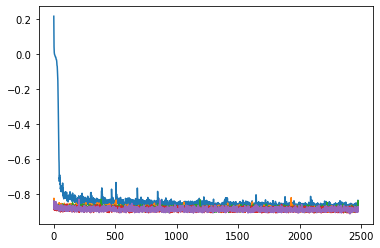

In [12]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=32)
Fold = 1

all_scores = []
all_preds = []
all_xval = []
all_yval = []
histories = []


for train_index, val_index in kf.split(X):
    
    print ('Fold: ',Fold)
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    batch_size = 4   
    train_generator= data_aug(X_train,y_train,batch_size)
        
    
    # Fit the model for without Data Augmentation - COMMENT THIS OUT FOR DATA AUGMENTATION
    history = model.fit_generator(
          train_generator,
          steps_per_epoch = len(y_train) // 4,
          epochs = 2478,
          validation_data = (X_val, y_val),
          validation_steps = len(y_val) // 4,
          verbose = 1
    )
  
    #Save each fold model
    model_name = '/data2/ysdata/Results_fin/tt/model/ResUnet_Fold_'+str(Fold)+'.h5'
    model.save(model_name)
    
    plt.plot(history.history['loss'], label='train' + str(Fold))
    
    scores = model.evaluate(X_val, y_val, verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    all_scores.append(scores[2])
    
    histories.append(history)
    pred = model.predict(X_val)
    all_preds.append(pred)
    
    all_xval.append(X_val)
    all_yval.append(y_val)
    
    Fold = Fold +1

In [13]:
all_scores

[0.90318763256073,
 0.8749056458473206,
 0.8893659710884094,
 0.7656003832817078,
 0.8927464485168457]

In [16]:
print("%s: %.3f%%" % ("Mean Dice: ",np.mean(all_scores)))
print("%s: %.3f%%" % ("Standard Deviation: +/-", np.std(all_scores)))

Mean Dice: : 0.865%
Standard Deviation: +/-: 0.051%


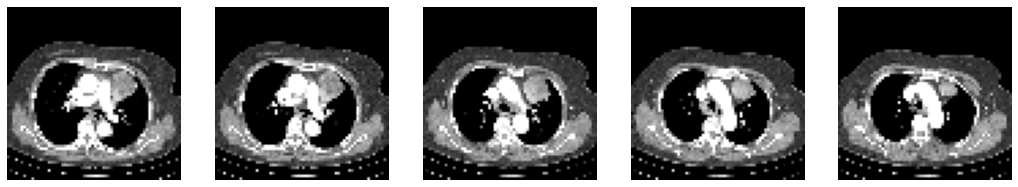

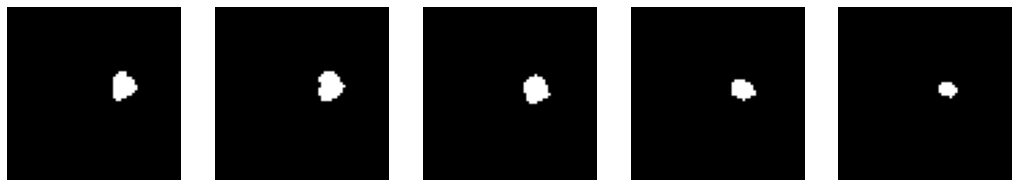

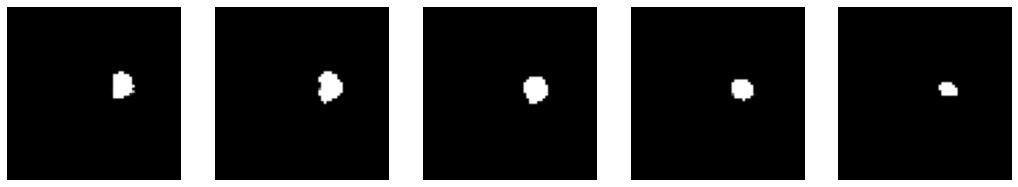

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (18,18))

slice_indices =[42,43,45,46,47]
for ind in range(5):
    pred_slice = all_xval[1][:,slice_indices[ind],:,:]
    axes[ind].imshow(pred_slice[3], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (18,18))

slice_indices =[42,43,45,46,47]
for ind in range(5):
    pred_slice = all_yval[1][:,slice_indices[ind],:,:]
    axes[ind].imshow(pred_slice[3], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (18,18))

slice_indices =[42,43,45,46,47]
for ind in range(5):
    pred_slice = all_preds[1][:,slice_indices[ind],:,:]
    axes[ind].imshow(pred_slice[3], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

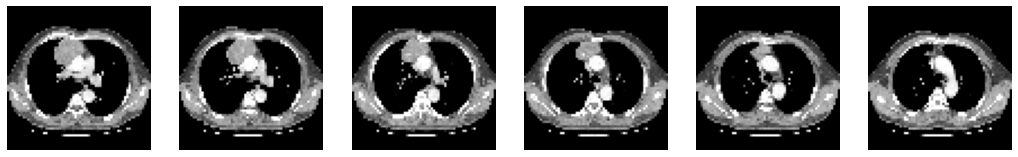

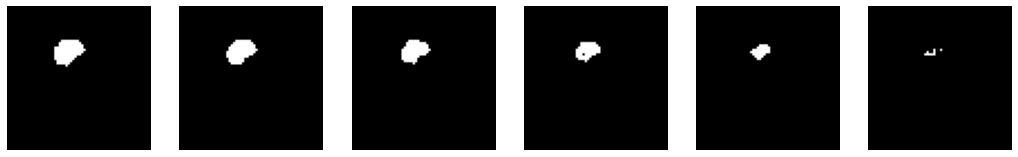

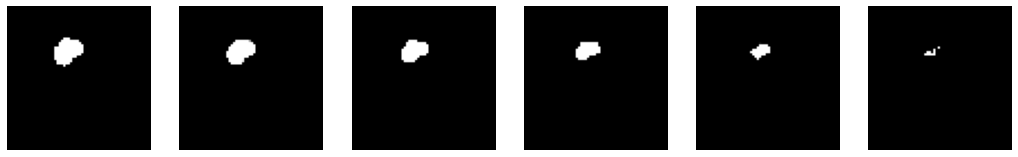

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize = (18,18))

slice_indices =[35,36,37,38,39,40,41]
for ind in range(6):
    X_test_slice = X_val[:,slice_indices[ind],:,:]
    axes[ind].imshow(X_test_slice[8], cmap='gray')
    axes[ind].axis('off')
    
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=6, figsize = (18,18))

slice_indices =[35,36,37,38,39,40,41]
for ind in range(6):
    y_test_slice = y_val[:,slice_indices[ind],:,:]
    axes[ind].imshow(y_test_slice[8], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize = (18,18))

slice_indices =[35,36,37,38,39,40,41]
for ind in range(6):
    pred_slice = all_preds[4][:,slice_indices[ind],:,:]
    axes[ind].imshow(pred_slice[8], cmap='gray')
    axes[ind].axis('off')
    
plt.show()

In [20]:
#Reference
#https://www.kaggle.com/eduardomineo/u-net-lung-segmentation-montgomery-shenzhen
#https://github.com/mrkolarik/3D-brain-segmentation
#https://github.com/zhixuhao/unet